## Part 1: Newton Method with Hessian Modification (NM-HM)

This part implements the Newton method with Hessian modification, as described in Section 3.4 of the Nocedal & Wright (NW) textbook.

The standard Newton step $p_k^N$ at iteration $k$ is obtained by solving the linear system:

$$\nabla^2 f(x_k) p_k^N = -\nabla f(x_k)$$

where $\nabla f(x_k)$ is the gradient and $\nabla^2 f(x_k)$ is the Hessian of the objective function $f$ at the current iterate $x_k$.

However, the Hessian $\nabla^2 f(x_k)$ may not be positive definite when $x_k$ is far from the solution. If the Hessian is not positive definite, the Newton direction $p_k^N$ may not be a descent direction (i.e., $\nabla f(x_k)^T p_k^N \ge 0$), and the standard Newton method can fail.

To ensure that the search direction is always a descent direction and that the method is globally convergent, we modify the Hessian matrix. The NM-HM algorithm replaces the true Hessian $\nabla^2 f(x_k)$ with a modified, positive definite matrix $B_k$. The search direction $p_k$ is then computed by solving:

$$B_k p_k = -\nabla f(x_k)$$

The modification ensures $B_k$ is sufficiently positive definite. A common strategy (Algorithm 3.3 in NW) is to add a multiple of the identity matrix to the Hessian:

$$B_k = \nabla^2 f(x_k) + E_k = \nabla^2 f(x_k) + \tau_k I$$

where $\tau_k \ge 0$ is chosen such that $B_k$ is positive definite. $\tau_k = 0$ if $\nabla^2 f(x_k)$ is already sufficiently positive definite. Otherwise, $\tau_k$ is increased until $B_k$ passes a positive definiteness test (e.g., attempting Cholesky factorization).

Once the descent direction $p_k$ is computed, a line search is performed to find a suitable step length $\alpha_k$ that satisfies certain conditions (e.g., Armijo or Wolfe conditions). The next iterate is then calculated as:

$$x_{k+1} = x_k + \alpha_k p_k$$

The algorithm terminates when a stopping criterion is met, such as the norm of the gradient being sufficiently small (e.g., $||\nabla f(x_k)|| < \epsilon$).

For our specific objective function $f(x) = \frac{1}{2} \sum_{j=1}^m (\phi(x; a_j) - b_j)^2 = \frac{1}{2} ||r(x)||^2$, the gradient and Hessian are given by:

$$\nabla f(x) = J(x)^T r(x)$$
$$\nabla^2 f(x) = J(x)^T J(x) + \sum_{j=1}^m r_j(x) \nabla^2 r_j(x)$$

where $r(x)$ is the vector of residuals $r_j(x) = \phi(x; a_j) - b_j$, $J(x)$ is the Jacobian of $r(x)$, and $\nabla^2 r_j(x)$ is the Hessian of the $j$-th residual component.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import approx_fprime

In [34]:
# Constants
l = 4  # Number of Gaussians
m = 100 # Number of data points
t_min, t_max = -2 * np.pi, 2 * np.pi

# Generate data points
a_vals = np.linspace(t_min, t_max, m)  # Renamed t_points to a_vals to match user's code
b_vals = np.sin(a_vals)  # Renamed b_points to b_vals to match user's code

# --- Helper Functions ---

def phi(x, t):
    """Calculates the sum of Gaussians phi(x; t)."""
    value = 0.0
    for i in range(l):
        alpha_i = x[3*i]
        mu_i = x[3*i + 1]
        sigma_i = x[3*i + 2]
        # Ensure sigma is positive to avoid division by zero or complex numbers
        if sigma_i <= 1e-8:
            sigma_i = 1e-8
        value += alpha_i * np.exp(-(t - mu_i)**2 / (2 * sigma_i**2))
    return value

def objective_function(x):
    """Calculates the nonlinear least-squares objective function f(x)."""
    residuals = np.array([phi(x, aj) - bj for aj, bj in zip(a_vals, b_vals)])
    return 0.5 * np.sum(residuals**2)

def residuals_vector(x):
    """Calculates the residual vector r(x)."""
    return np.array([phi(x, aj) - bj for aj, bj in zip(a_vals, b_vals)])

def jacobian_matrix(x):
    """Calculates the Jacobian matrix J(x) of the residuals."""
    J = np.zeros((m, 3 * l))
    for j in range(m): # Iterate over data points
        aj = a_vals[j]
        for i in range(l): # Iterate over Gaussians
            alpha_i = x[3*i]
            mu_i = x[3*i + 1]
            sigma_i = x[3*i + 2]

            # Handle potential division by zero or small sigma
            if sigma_i <= 1e-8:
                sigma_i = 1e-8 # Use a small positive value

            exp_term = np.exp(-(aj - mu_i)**2 / (2 * sigma_i**2))

            # Derivative w.r.t. alpha_i
            J[j, 3*i] = exp_term
            # Derivative w.r.t. mu_i
            J[j, 3*i + 1] = alpha_i * exp_term * (aj - mu_i) / (sigma_i**2)
            # Derivative w.r.t. sigma_i
            J[j, 3*i + 2] = alpha_i * exp_term * (aj - mu_i)**2 / (sigma_i**3)
    return J

def gradient(x):
    """Calculates the gradient ∇f(x) = J(x)^T r(x)."""
    J = jacobian_matrix(x)
    r = residuals_vector(x)
    return J.T @ r

def hessian_second_order_term(x):
    """Calculates the second-order term sum(r_j(x) * ∇²r_j(x)) for the Hessian."""
    H_so = np.zeros((3 * l, 3 * l))
    r = residuals_vector(x)

    for j in range(m): # Iterate over data points
        aj = a_vals[j]
        rj = r[j]
        if abs(rj) < 1e-10: # Skip if residual is negligible
            continue

        # Compute Hessian of the j-th residual r_j = phi(x; aj) - bj
        Hessian_phi_j = np.zeros((3 * l, 3 * l))
        for i in range(l): # Iterate over Gaussians
            alpha_i = x[3*i]
            mu_i = x[3*i + 1]
            sigma_i = x[3*i + 2]

            if sigma_i <= 1e-8:
                sigma_i = 1e-8

            exp_term = np.exp(-(aj - mu_i)**2 / (2 * sigma_i**2))
            term1 = (aj - mu_i) / sigma_i**2
            term2 = (aj - mu_i)**2 / sigma_i**3
            term3 = (aj - mu_i)**2 / sigma_i**4
            term4 = (aj - mu_i)**3 / sigma_i**5
            term5 = (aj - mu_i)**4 / sigma_i**6

            # Second derivatives involving alpha_i
            Hessian_phi_j[3*i, 3*i+1] = exp_term * term1 # d^2/(d_alpha_i d_mu_i)
            Hessian_phi_j[3*i+1, 3*i] = Hessian_phi_j[3*i, 3*i+1]
            Hessian_phi_j[3*i, 3*i+2] = exp_term * term2 # d^2/(d_alpha_i d_sigma_i)
            Hessian_phi_j[3*i+2, 3*i] = Hessian_phi_j[3*i, 3*i+2]

            # Second derivatives involving mu_i
            Hessian_phi_j[3*i+1, 3*i+1] = alpha_i * exp_term * (term3 - 1/sigma_i**2) # d^2/(d_mu_i^2)
            Hessian_phi_j[3*i+1, 3*i+2] = alpha_i * exp_term * term1 * (term3 - 2/sigma_i**2) # d^2/(d_mu_i d_sigma_i)
            Hessian_phi_j[3*i+2, 3*i+1] = Hessian_phi_j[3*i+1, 3*i+2]

            # Second derivatives involving sigma_i
            Hessian_phi_j[3*i+2, 3*i+2] = alpha_i * exp_term * term2 * (term3 - 3/sigma_i**2) # d^2/(d_sigma_i^2)

        H_so += rj * Hessian_phi_j

    return H_so

def hessian(x):
    """Calculates the full Hessian ∇²f(x) = J(x)^T J(x) + sum(r_j(x) * ∇²r_j(x))."""
    J = jacobian_matrix(x)
    H_gn = J.T @ J # Gauss-Newton approximation
    H_so = hessian_second_order_term(x) # Second-order term
    return H_gn + H_so

def plot_results(x, title):
    """Plots the fitted Gaussian sum against the original sin(t)."""
    t_fine = np.linspace(t_min, t_max, 500)
    y_fit = phi(x, t_fine)
    y_true = np.sin(t_fine)

    plt.figure(figsize=(10, 6))
    plt.plot(t_fine, y_true, label='sin(t)', linewidth=2)
    plt.plot(t_fine, y_fit, label='Fitted $\phi(x; t)$', linestyle='--', linewidth=2)
    plt.scatter(a_vals, b_vals, label='Data points ($a_j, b_j$)', color='red', s=10)
    plt.title(title)
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.legend()
    plt.grid(True)
    plt.ylim(-1.5, 1.5)
    plt.show()

# --- Backtracking Line Search ---
def backtracking_line_search(x, p, grad_f, obj_func, alpha0=1.0, c1=1e-4, rho=0.5):
    """Performs backtracking line search to satisfy the Armijo condition."""
    alpha = alpha0
    f_x = obj_func(x)
    slope = grad_f.T @ p

    # Ensure initial step size is reasonable and check descent direction
    if slope >= 0:
        print("Warning: Search direction is not a descent direction.")
        pass # Allow proceeding but slope condition in Armijo won't be met strictly

    while obj_func(x + alpha * p) > f_x + c1 * alpha * slope:
        alpha *= rho
        if alpha < 1e-10: # Prevent infinite loop / too small step
            return 0 # Indicate failure or return smallest possible step
    return alpha

def evaluate_runs(optimizer_func, x_star, num_runs=5, scales=[0.5, 1.0, 1.5, 2.0, 3.0], tol=1e-6, max_iter=2000):
    """Evaluates multiple runs of an optimization method with different starting points.
    
    Args:
        optimizer_func: Function that takes x0 and returns (x_final, history)
        x_star: Target solution or best known solution
        num_runs: Number of runs to perform
        scales: Scaling factors for random initial points
        tol: Tolerance for convergence
        max_iter: Maximum iterations
        
    Returns:
        List of results for each run
    """
    results = []
    
    for i, scale in enumerate(scales[:num_runs]):
        print(f"\n--- Run {i + 1} (scale = {scale}) ---")
        x0 = np.random.randn(3 * l) * scale
        
        start_time = time.time()
        x_final, history = optimizer_func(x0)
        end_time = time.time()
        runtime = end_time - start_time
        
        distance = np.linalg.norm(x_final - x_star)
        
        # Compute convergence metrics if enough iterations
        if len(history) >= 2:
            k = len(history) - 2
            xk = history[k]
            xk1 = history[k + 1]
            lk = np.linalg.norm(xk1 - x_star) / np.linalg.norm(xk - x_star)
            qk = np.linalg.norm(xk1 - x_star) / (np.linalg.norm(xk - x_star) ** 2)
        else:
            lk = None
            qk = None
            print("Insufficient iterations for convergence analysis.")
        
        print(f"Stopping criterion: ||g|| < {tol} or max_iter = {max_iter}")
        print(f"Final iterate x̄:\n{x_final}")
        print(f"Distance to x*: {distance:.6f}")
        
        if lk is not None:
            print(f"ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = {lk:.6f}")
            print(f"q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = {qk:.6f}")
        
        print(f"Runtime: {runtime:.4f} seconds")
        
        # Plotting result
        plt.figure()
        plt.plot(a_vals, b_vals, label="sin(t)")
        plt.plot(a_vals, phi(x_final, a_vals), '--', label="phi(x̄; t)")
        plt.title(f"Run {i + 1}: phi(x̄; t) vs sin(t)")
        plt.xlabel("t")
        plt.ylabel("Function value")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        results.append({
            'x0': x0,
            'x_final': x_final,
            'distance': distance,
            'lk': lk,
            'qk': qk,
            'runtime': runtime
        })
    
    return results

def standard_newton_method(x0, tol=1e-6, max_iter=2000):
    """Implements the standard Newton method without Hessian modification.
    
    Args:
        x0 (np.ndarray): Initial guess for the parameters.
        tol (float): Tolerance for the norm of the gradient to declare convergence.
        max_iter (int): Maximum number of iterations.
        
    Returns:
        tuple: (final_x, history)
               history: list of all iterates for convergence analysis
    """
    x = np.copy(x0)
    history = [x.copy()]  # Store all iterates for convergence analysis
    
    print(f"Starting Standard Newton from initial point with norm: {np.linalg.norm(x0):.4f}")
    
    for k in range(max_iter):
        g = gradient(x)
        grad_norm = np.linalg.norm(g)
        
        # Print progress (optional)
        if k % 10 == 0:
            print(f"Iter {k}: f(x) = {objective_function(x):.6e}, ||∇f(x)|| = {grad_norm:.6e}")
        
        # Stopping criterion
        if grad_norm < tol:
            print(f"Converged in {k} iterations.")
            print(f"Final f(x) = {objective_function(x):.6e}, ||∇f(x)|| = {grad_norm:.6e}")
            return x, history
        
        # Compute Hessian
        H = hessian(x)
        
        # Solve the linear system H * p = -g
        try:
            p = np.linalg.solve(H, -g)
        except np.linalg.LinAlgError:
            print("Error: Hessian is singular or ill-conditioned. Standard Newton failed.")
            return x, history  # Return current state
        
        # Perform line search
        alpha = backtracking_line_search(x, p, g, objective_function, alpha0=1.0)
        
        if alpha <= 0:  # Line search failed to find a step
            print(f"Warning: Line search failed at iteration {k}. Stopping.")
            return x, history  # Return current state
        
        # Update iterate
        x = x + alpha * p
        history.append(x.copy())  # Store the new iterate
    
    # If loop finishes, max_iter was reached
    print(f"Maximum iterations ({max_iter}) reached.")
    print(f"Final f(x) = {objective_function(x):.6e}, ||∇f(x)|| = {np.linalg.norm(gradient(x)):.6e}")
    return x, history

def classify_convergence(history, x_star):
    """Classifies the convergence rate based on the sequence of iterates.
    
    Args:
        history (list): List of iterates from the optimization method.
        x_star (np.ndarray): Target solution or best known solution.
        
    Returns:
        tuple: (linear_counts, superlinear_counts, quadratic_counts)
               Counts of iterations classified as having linear, superlinear, or quadratic convergence.
    """
    linear_counts = 0
    superlinear_counts = 0
    quadratic_counts = 0
    n = len(history)
    
    # We need at least 3 iterates to classify convergence
    if n < 3:
        return linear_counts, superlinear_counts, quadratic_counts
    
    # We analyze the last few steps, say last 5 steps (if available)
    start_idx = max(0, n - 6)
    
    for k in range(start_idx, n - 2):
        xk = history[k]
        xk1 = history[k + 1]
        xk2 = history[k + 2]
        
        dist_k = np.linalg.norm(xk - x_star)
        dist_k1 = np.linalg.norm(xk1 - x_star)
        dist_k2 = np.linalg.norm(xk2 - x_star)
        
        if dist_k < 1e-10 or dist_k1 < 1e-10:
            continue
        
        # Linear ratio: ||x_{k+1} - x*|| / ||x_k - x*||
        ell_k = dist_k1 / dist_k
        
        # Quadratic ratio: ||x_{k+1} - x*|| / ||x_k - x*||^2
        q_k = dist_k1 / (dist_k ** 2)
        
        # Classify
        # Thresholds can be tuned depending on your problem
        if ell_k < 0.1:  # Strong superlinear or quadratic
            if q_k < 10:  # Bounded q_k suggests quadratic
                quadratic_counts += 1
            else:
                superlinear_counts += 1
        elif ell_k < 0.9:  # Mild superlinear
            superlinear_counts += 1
        else:  # Linear or worse
            linear_counts += 1
    
    return linear_counts, superlinear_counts, quadratic_counts

def run_comprehensive_analysis(methods, method_names, x_star, scales, num_runs_per_scale=3, tol=1e-6, max_iter=2000):
    """Runs comprehensive analysis of multiple optimization methods.
    
    Args:
        methods (list): List of optimization method functions.
        method_names (list): List of method names for reporting.
        x_star (np.ndarray): Target solution or best known solution.
        scales (list): List of scales for generating initial points.
        num_runs_per_scale (int): Number of random runs per scale.
        tol (float): Tolerance for convergence.
        max_iter (int): Maximum iterations.
        
    Returns:
        dict: Results dictionary with statistics for each method.
    """
    n_methods = len(methods)
    n_scales = len(scales)
    
    # Initialize results dictionary
    results = {
        name: {
            'success_rate': 0,
            'converged_to_x_star': 0,
            'converged_to_other': 0,
            'failed': 0,
            'avg_runtime': 0,
            'linear_rate': 0,
            'superlinear_rate': 0,
            'quadratic_rate': 0,
            'iterations': [],
            'distances': [],
            'runtimes': [],
            'average_final_norm': [],
        } for name in method_names
    }
    
    total_runs = n_scales * num_runs_per_scale
    
    # Run experiments
    for scale_idx, scale in enumerate(scales):
        print(f"\n=== Scale {scale} ===")
        
        for run in range(num_runs_per_scale):
            print(f"\n--- Run {run + 1}/{num_runs_per_scale} with scale {scale} ---")
            
            # Generate random initial point
            np.random.seed(42 + scale_idx * 100 + run)  # For reproducibility with different seeds
            x0 = x_star + np.random.randn(len(x_star)) * scale
            
            # Ensure sigma parameters are positive
            for i in range(l):
                if x0[3*i + 2] <= 0:
                    x0[3*i + 2] = np.abs(x0[3*i + 2]) + 0.1  # Make sigma > 0.1
            
            # Run each method
            for method_idx, (method, name) in enumerate(zip(methods, method_names)):
                print(f"\nRunning {name}...")
                
                try:
                    start_time = time.time()
                    x_final, history = method(x0, tol=tol, max_iter=max_iter)
                    runtime = time.time() - start_time
                    
                    # Calculate distance to x_star
                    distance = np.linalg.norm(x_final - x_star)
                    
                    # Classify convergence
                    lin, superlin, quad = classify_convergence(history, x_star)
                    
                    # Update results
                    results[name]['iterations'].append(len(history) - 1)
                    results[name]['distances'].append(distance)
                    results[name]['runtimes'].append(runtime)
                    
                    results[name]['linear_rate'] += lin
                    results[name]['superlinear_rate'] += superlin
                    results[name]['quadratic_rate'] += quad
                    
                    # Check if converged to x_star or another point
                    if distance < 0.1:  # Threshold for considering convergence to x_star
                        results[name]['converged_to_x_star'] += 1
                        results[name]['success_rate'] += 1
                        print(f"{name} converged to x* in {len(history) - 1} iterations. Distance: {distance:.6f}")
                    else:
                        # Check if it converged to another point (local minimizer)
                        grad_norm = np.linalg.norm(gradient(x_final))
                        results[name]['average_final_norm'].append(grad_norm)
                        if grad_norm < tol:
                            results[name]['converged_to_other'] += 1
                            results[name]['success_rate'] += 1
                            print(f"{name} converged to a different local minimizer. Distance to x*: {distance:.6f}")
                        else:
                            results[name]['failed'] += 1
                            print(f"{name} failed to converge. Final gradient norm: {grad_norm:.6f}")
                    
                    print(f"Runtime: {runtime:.4f} seconds")
                    print(f"Convergence rates: Linear={lin}, Superlinear={superlin}, Quadratic={quad}")
                    
                    # Plot the result for this method and run
                    t_plot = np.linspace(t_min, t_max, 500)
                    plt.figure(figsize=(10, 6))
                    plt.plot(t_plot, np.sin(t_plot), label='sin(t)')
                    plt.plot(t_plot, phi(x_final, t_plot), '--', label=f'{name} approx')
                    plt.plot(t_plot, phi(x_star, t_plot), ':', label='x* approx')
                    plt.title(f"{name} - Scale {scale}, Run {run + 1}")
                    plt.xlabel("t")
                    plt.ylabel("Function value")
                    plt.legend()
                    plt.grid(True)
                    plt.show()
                    
                except Exception as e:
                    print(f"{name} failed with error: {e}")
                    results[name]['failed'] += 1
    
    # Calculate averages and percentages
    for name in method_names:
        if results[name]['runtimes']:
            results[name]['avg_runtime'] = np.mean(results[name]['runtimes'])
        
        results[name]['success_rate'] = results[name]['success_rate'] / total_runs * 100
        results[name]['converged_to_x_star'] = results[name]['converged_to_x_star'] / total_runs * 100
        results[name]['converged_to_other'] = results[name]['converged_to_other'] / total_runs * 100
        results[name]['failed'] = results[name]['failed'] / total_runs * 100
        results[name]['average_final_norm'] = np.mean(results[name]['average_final_norm']) if results[name]['average_final_norm'] else 0
    
    return results

def print_analysis_summary(results, method_names):
    """Prints a summary of the analysis results.
    
    Args:
        results (dict): Results dictionary from run_comprehensive_analysis.
        method_names (list): List of method names.
    """
    print("\n=== ANALYSIS SUMMARY ===\n")
    
    # Print table header
    header = f"{'Method':<20} | {'Success %':<10} | {'To x*':<10} | {'To other':<10} | {'Failed':<10} | {'Avg Time':<10} | {'Linear':<8} | {'Superlin':<8} | {'Quadratic':<8}"
    print(header)
    print("-" * len(header))
    
    # Print results for each method
    for name in method_names:
        r = results[name]
        print(f"{name:<20} | {r['success_rate']:<10.1f} | {r['converged_to_x_star']:<10.1f} | {r['converged_to_other']:<10.1f} | {r['failed']:<10.1f} | {r['avg_runtime']:<10.4f} | {r['linear_rate']:<8} | {r['superlinear_rate']:<8} | {r['quadratic_rate']:<8}")
    
    print("\n=== DETAILED ANALYSIS ===\n")
    
    for name in method_names:
        r = results[name]
        print(f"\n{name}:")
        print(f"  Success rate: {r['success_rate']:.1f}%")
        print(f"  Converged to x*: {r['converged_to_x_star']:.1f}%")
        print(f"  Converged to other local minimizer: {r['converged_to_other']:.1f}%")
        print(f"  Failed to converge: {r['failed']:.1f}%")
        print(f"  Average runtime: {r['avg_runtime']:.4f} seconds")
        print(f"Average final gradient norm: {r['average_final_norm']:.6f}")
        
        if r['iterations']:
            print(f"  Average iterations: {np.mean(r['iterations']):.1f}")
            print(f"  Min/Max iterations: {np.min(r['iterations'])}/{np.max(r['iterations'])}")
        
        print(f"  Convergence rate counts:")
        print(f"    Linear: {r['linear_rate']}")
        print(f"    Superlinear: {r['superlinear_rate']}")
        print(f"    Quadratic: {r['quadratic_rate']}")

def plot_comparison_charts(results, method_names):
    """Plots comparison charts for the different methods.
    
    Args:
        results (dict): Results dictionary from run_comprehensive_analysis.
        method_names (list): List of method names.
    """
    # Plot success rates
    plt.figure(figsize=(12, 6))
    
    success_data = [results[name]['success_rate'] for name in method_names]
    x_star_data = [results[name]['converged_to_x_star'] for name in method_names]
    other_data = [results[name]['converged_to_other'] for name in method_names]
    failed_data = [results[name]['failed'] for name in method_names]
    
    x = np.arange(len(method_names))
    width = 0.2
    
    plt.bar(x - 1.5*width, success_data, width, label='Overall Success')
    plt.bar(x - 0.5*width, x_star_data, width, label='To x*')
    plt.bar(x + 0.5*width, other_data, width, label='To Other Minimizer')
    plt.bar(x + 1.5*width, failed_data, width, label='Failed')
    
    plt.xlabel('Method')
    plt.ylabel('Percentage (%)')
    plt.title('Success Rates by Method')
    plt.xticks(x, method_names)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Plot average runtimes
    plt.figure(figsize=(10, 6))
    runtime_data = [results[name]['avg_runtime'] for name in method_names]
    plt.bar(method_names, runtime_data)
    plt.xlabel('Method')
    plt.ylabel('Average Runtime (seconds)')
    plt.title('Average Runtime by Method')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Plot convergence rate distribution
    plt.figure(figsize=(12, 6))
    linear_data = [results[name]['linear_rate'] for name in method_names]
    superlinear_data = [results[name]['superlinear_rate'] for name in method_names]
    quadratic_data = [results[name]['quadratic_rate'] for name in method_names]
    
    x = np.arange(len(method_names))
    width = 0.25
    
    plt.bar(x - width, linear_data, width, label='Linear')
    plt.bar(x, superlinear_data, width, label='Superlinear')
    plt.bar(x + width, quadratic_data, width, label='Quadratic')
    
    plt.xlabel('Method')
    plt.ylabel('Count')
    plt.title('Convergence Rate Distribution by Method')
    plt.xticks(x, method_names)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
def hybrid_gn_bfgs(x0, tol=1e-6, max_iter=100, gamma=0.5):
    """Implements the Gauss-Newton-BFGS hybrid method (Section 10.3).
    
    This method combines Gauss-Newton with BFGS updates for large-residual problems.
    
    Args:
        x0 (np.ndarray): Initial guess for the parameters.
        tol (float): Tolerance for the norm of the gradient to declare convergence.
        max_iter (int): Maximum number of iterations.
        gamma (float): Weighting factor for BFGS update (0 = pure GN, 1 = pure BFGS).

    Returns:
        tuple: (final_x, history)
               history: list of all iterates for convergence analysis
    """
    x = np.copy(x0)
    n = len(x)
    I = np.eye(n)
    
    # Initialize BFGS approximation to identity matrix
    B_bfgs = np.eye(n)
    
    history = [x.copy()]  # Store all iterates for convergence analysis

    print(f"Starting Hybrid GN-BFGS from initial point with norm: {np.linalg.norm(x0):.4f}")

    for k in range(max_iter):
        g = gradient(x)
        grad_norm = np.linalg.norm(g)

        # Print progress
        if k % 10 == 0:
            print(f"Iter {k}: f(x) = {objective_function(x):.6e}, ||∇f(x)|| = {grad_norm:.6e}")

        # Stopping criterion
        if grad_norm < tol:
            print(f"Converged in {k} iterations.")
            print(f"Final f(x) = {objective_function(x):.6e}, ||∇f(x)|| = {grad_norm:.6e}")
            return x, history

        # Calculate Jacobian and GN Hessian approximation
        J = jacobian_matrix(x)
        B_gn = J.T @ J

        # Form the hybrid Hessian approximation
        B_hybrid = (1 - gamma) * B_gn + gamma * B_bfgs

        # Solve the system for the search direction
        try:
            p = np.linalg.solve(B_hybrid, -g)
        except np.linalg.LinAlgError:
            print(f"Warning: Linear system solve failed. Using least squares.")
            p, residuals, rank, s = np.linalg.lstsq(B_hybrid, -g, rcond=None)

        # Perform line search
        alpha = backtracking_line_search(x, p, g, objective_function, alpha0=1.0)

        if alpha <= 0:  # Line search failed
            print(f"Warning: Line search failed at iteration {k}. Stopping.")
            return x, history

        # Store old values before update
        x_old = x.copy()
        g_old = g.copy()
        
        # Update iterate
        x = x + alpha * p
        history.append(x.copy())
        
        # BFGS update for next iteration
        s = x - x_old  # Step
        y = gradient(x) - g_old  # Gradient difference
        
        # Skip BFGS update if s^T y is too small (indicates poor curvature information)
        sy = s @ y
        if sy > 1e-8:
            # Standard BFGS update formula
            Bs = B_bfgs @ s
            B_bfgs = B_bfgs - np.outer(Bs, Bs) / (s @ Bs) + np.outer(y, y) / sy

    # If loop finishes, max_iter was reached
    print(f"Maximum iterations ({max_iter}) reached.")
    print(f"Final f(x) = {objective_function(x):.6e}, ||∇f(x)|| = {np.linalg.norm(gradient(x)):.6e}")
    return x, history



<>:125: SyntaxWarning: invalid escape sequence '\p'
<>:125: SyntaxWarning: invalid escape sequence '\p'
/var/folders/1s/v4_12g5n7qb6lp59j07qy4kc0000gp/T/ipykernel_11715/3660086940.py:125: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(t_fine, y_fit, label='Fitted $\phi(x; t)$', linestyle='--', linewidth=2)


In [35]:
def newton_hessian_modification(x0, tol=1e-6, max_iter=2000, beta=1e-3):
    """Implements the Newton method with Hessian modification (Algorithm 3.2/3.3).
    
    This version is adapted to work with the evaluate_runs function.

    Args:
        x0 (np.ndarray): Initial guess for the parameters.
        tol (float): Tolerance for the norm of the gradient to declare convergence.
        max_iter (int): Maximum number of iterations.
        beta (float): Initial factor for Hessian modification (see Alg 3.3).

    Returns:
        tuple: (final_x, history)
               history: list of all iterates for convergence analysis
    """
    x = np.copy(x0)
    n_params = len(x0)
    identity_mat = np.identity(n_params)
    history = [x.copy()]  # Store all iterates for convergence analysis

    print(f"Starting NM-HM from initial point with norm: {np.linalg.norm(x0):.4f}")

    for k in range(max_iter):
        g = gradient(x)
        grad_norm = np.linalg.norm(g)

        # Print progress (optional)
        if k % 10 == 0:
            print(f"Iter {k}: f(x) = {objective_function(x):.6e}, ||∇f(x)|| = {grad_norm:.6e}")

        # Stopping criterion
        if grad_norm < tol:
            print(f"Converged in {k} iterations.")
            print(f"Final f(x) = {objective_function(x):.6e}, ||∇f(x)|| = {grad_norm:.6e}")
            return x, history

        # Compute Hessian
        H = hessian(x)

        # Hessian Modification (Algorithm 3.3 inspired)
        tau = 0
        min_diag = np.min(np.diag(H))
        if min_diag <= 0:
            tau = -min_diag + beta

        while True:
            B = H + tau * identity_mat
            try:
                # Attempt Cholesky factorization to check for positive definiteness
                L = np.linalg.cholesky(B)
                # If successful, B is positive definite
                break
            except np.linalg.LinAlgError:
                # Cholesky failed, increase tau
                if tau == 0:
                    tau = beta
                else:
                    tau = max(2 * tau, beta)  # Increase tau
                if tau > 1e20:  # Avoid excessively large tau
                    print("Error: Hessian modification failed, tau too large.")
                    return x, history  # Return current state

        # Solve the linear system B * p = -g
        try:
            p = np.linalg.solve(B, -g)
        except np.linalg.LinAlgError:
            print("Error: Linear system solve failed even after modification.")
            return x, history  # Return current state

        # Perform line search
        alpha = backtracking_line_search(x, p, g, objective_function, alpha0=1.0)

        if alpha <= 0:  # Line search failed to find a step
            print(f"Warning: Line search failed at iteration {k}. Stopping.")
            return x, history  # Return current state

        # Update iterate
        x = x + alpha * p
        history.append(x.copy())  # Store the new iterate

    # If loop finishes, max_iter was reached
    print(f"Maximum iterations ({max_iter}) reached.")
    print(f"Final f(x) = {objective_function(x):.6e}, ||∇f(x)|| = {np.linalg.norm(gradient(x)):.6e}")
    return x, history

# Example usage with evaluate_runs
# First, define a target solution x_star (this should be your best known solution)
# x_star = np.array([...])  # Fill in with your target solution

# Define a wrapper function for the optimizer to match the expected interface
def nm_hm_wrapper(x0):
    return newton_hessian_modification(x0)

# Run the evaluation
# results_nmhm = evaluate_runs(nm_hm_wrapper, x_star)



--- Run 1 (scale = 0.5) ---
Starting NM-HM from initial point with norm: 2.0631
Iter 0: f(x) = 2.507909e+01, ||∇f(x)|| = 3.178474e+00
Iter 10: f(x) = 2.486973e+01, ||∇f(x)|| = 2.996200e+00
Iter 20: f(x) = 2.481113e+01, ||∇f(x)|| = 3.981783e+00
Iter 30: f(x) = 2.468079e+01, ||∇f(x)|| = 2.690984e+00
Iter 40: f(x) = 2.462133e+01, ||∇f(x)|| = 2.425618e+00
Iter 50: f(x) = 2.458121e+01, ||∇f(x)|| = 2.302027e+00
Iter 60: f(x) = 2.453581e+01, ||∇f(x)|| = 2.272468e+00
Iter 70: f(x) = 2.449211e+01, ||∇f(x)|| = 2.281915e+00
Iter 80: f(x) = 2.444528e+01, ||∇f(x)|| = 2.329200e+00
Iter 90: f(x) = 2.435018e+01, ||∇f(x)|| = 2.495587e+00
Iter 100: f(x) = 2.422264e+01, ||∇f(x)|| = 2.744254e+00
Iter 110: f(x) = 2.406451e+01, ||∇f(x)|| = 3.047632e+00
Iter 120: f(x) = 1.907720e+01, ||∇f(x)|| = 2.579853e+00
Iter 130: f(x) = 1.907518e+01, ||∇f(x)|| = 2.680644e+00
Iter 140: f(x) = 1.907290e+01, ||∇f(x)|| = 2.806592e+00
Iter 150: f(x) = 1.907023e+01, ||∇f(x)|| = 2.951844e+00
Iter 160: f(x) = 1.906694e+01, ||∇

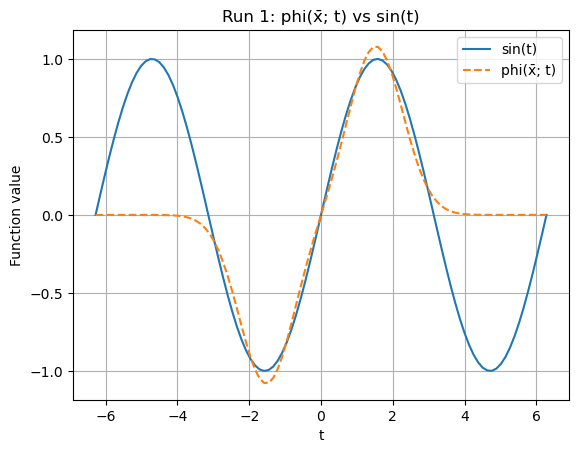


--- Run 2 (scale = 1.0) ---
Starting NM-HM from initial point with norm: 2.0263
Iter 0: f(x) = 2.766524e+01, ||∇f(x)|| = 1.487934e+01
Iter 10: f(x) = 1.262600e+01, ||∇f(x)|| = 4.447943e-01
Iter 20: f(x) = 1.253513e+01, ||∇f(x)|| = 2.653208e-02
Iter 30: f(x) = 1.253511e+01, ||∇f(x)|| = 4.292002e-05
Converged in 37 iterations.
Final f(x) = 1.253511e+01, ||∇f(x)|| = 4.161960e-07
Stopping criterion: ||g|| < 1e-06 or max_iter = 2000
Final iterate x̄:
[ 1.07804107  1.52518721  0.75679608 -0.54900658 -2.24580763  0.41159475
 -0.94070428 -1.24253328  0.63672482 -0.179054    1.18366946 -0.11078697]
Distance to x*: 4.432607
ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = 1.000000
q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = 0.225601
Runtime: 0.1990 seconds


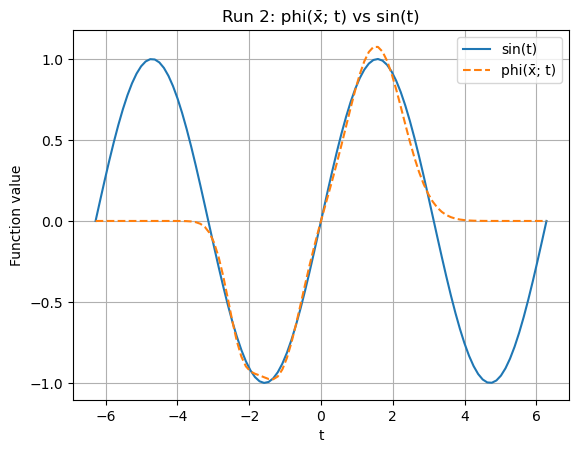


--- Run 3 (scale = 1.5) ---
Starting NM-HM from initial point with norm: 5.4345
Iter 0: f(x) = 2.475000e+01, ||∇f(x)|| = 0.000000e+00
Converged in 0 iterations.
Final f(x) = 2.475000e+01, ||∇f(x)|| = 0.000000e+00
Insufficient iterations for convergence analysis.
Stopping criterion: ||g|| < 1e-06 or max_iter = 2000
Final iterate x̄:
[ 0.46248847  2.68211392 -3.58906856  0.94016538  0.040684   -0.25729558
  2.12306012 -1.3696125  -0.97250509 -0.93415161 -0.30104941 -0.02547093]
Distance to x*: 6.483770
Runtime: 0.0035 seconds


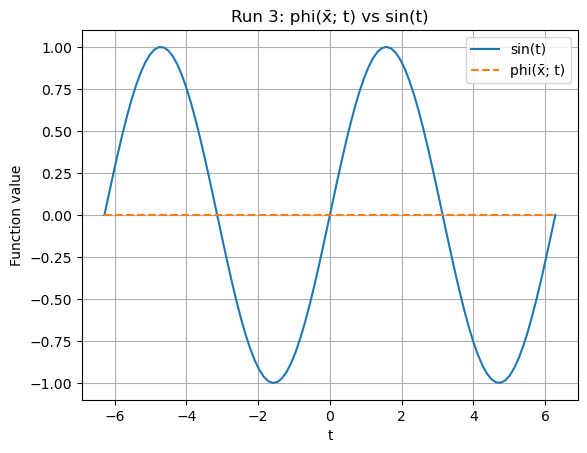


--- Run 4 (scale = 2.0) ---
Starting NM-HM from initial point with norm: 8.5581
Iter 0: f(x) = 5.055537e+02, ||∇f(x)|| = 3.240389e+02
Iter 10: f(x) = 5.012067e+02, ||∇f(x)|| = 3.093738e+02
Iter 20: f(x) = 4.985843e+02, ||∇f(x)|| = 3.004403e+02
Iter 30: f(x) = 4.958929e+02, ||∇f(x)|| = 2.939602e+02
Iter 40: f(x) = 4.943406e+02, ||∇f(x)|| = 2.894066e+02
Iter 50: f(x) = 4.928930e+02, ||∇f(x)|| = 2.854050e+02
Iter 60: f(x) = 4.914032e+02, ||∇f(x)|| = 2.821328e+02
Iter 70: f(x) = 4.898617e+02, ||∇f(x)|| = 2.794297e+02
Iter 80: f(x) = 4.882583e+02, ||∇f(x)|| = 2.771671e+02
Iter 90: f(x) = 4.865811e+02, ||∇f(x)|| = 2.752425e+02
Iter 100: f(x) = 4.848155e+02, ||∇f(x)|| = 2.735740e+02
Iter 110: f(x) = 4.829425e+02, ||∇f(x)|| = 2.720953e+02
Iter 120: f(x) = 4.809360e+02, ||∇f(x)|| = 2.707509e+02
Iter 130: f(x) = 4.787587e+02, ||∇f(x)|| = 2.694921e+02
Iter 140: f(x) = 4.763523e+02, ||∇f(x)|| = 2.682714e+02
Iter 150: f(x) = 4.736167e+02, ||∇f(x)|| = 2.670343e+02
Iter 160: f(x) = 4.703489e+02, ||∇

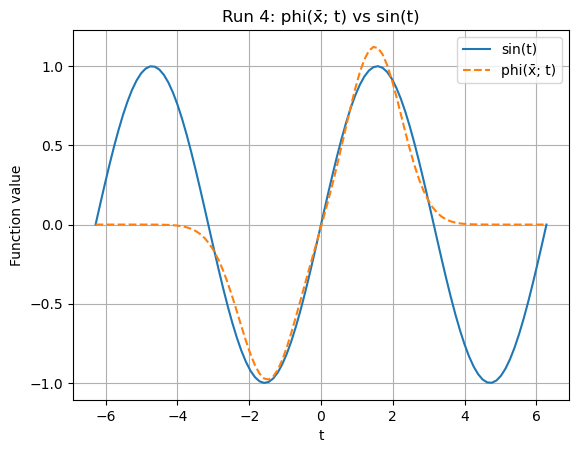


--- Run 5 (scale = 3.0) ---
Starting NM-HM from initial point with norm: 10.4956
Iter 0: f(x) = 1.372930e+02, ||∇f(x)|| = 9.093273e+01
Iter 10: f(x) = 1.271041e+01, ||∇f(x)|| = 1.966035e-04
Converged in 13 iterations.
Final f(x) = 1.271041e+01, ||∇f(x)|| = 4.480339e-07
Stopping criterion: ||g|| < 1e-06 or max_iter = 2000
Final iterate x̄:
[ 1.06118365 -1.30177929 -1.49408293 -1.10139068 -1.57079636  0.70710671
 -1.08207092  4.73831043  0.74094542  1.9374344  -7.31829818 -1.1099121 ]
Distance to x*: 10.031429
ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = 1.000000
q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = 0.099687
Runtime: 0.0775 seconds


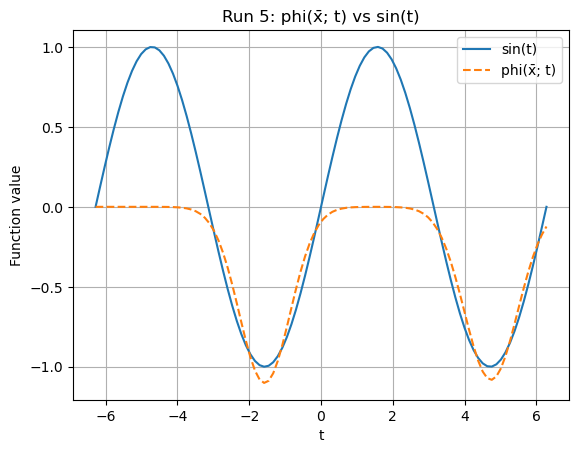

In [36]:
x_star = np.array([1.0, 0.0, 1.0] * l)  # Example target solution, adjust as needed
results_nmhm = evaluate_runs(nm_hm_wrapper, x_star)

## Part 2: Gauss-Newton Method (GNM)

This part implements the Gauss-Newton method, as described in Section 10.3 of the Nocedal & Wright (NW) textbook.

The Gauss-Newton method is specifically designed for minimizing nonlinear least-squares objective functions of the form:

$$f(x) = \frac{1}{2} \sum_{j=1}^m r_j(x)^2 = \frac{1}{2} ||r(x)||^2$$

where $r(x) = (r_1(x), ..., r_m(x))^T$ is the vector of residual functions.

The gradient and Hessian of this objective function are:

$$\nabla f(x) = J(x)^T r(x)$$
$$\nabla^2 f(x) = J(x)^T J(x) + \sum_{j=1}^m r_j(x) \nabla^2 r_j(x)$$

where $J(x)$ is the Jacobian of the residual vector $r(x)$.

The key idea of the Gauss-Newton method is to approximate the Hessian by neglecting the second-order term involving $\nabla^2 r_j(x)$. This approximation is reasonable when the residuals $r_j(x)$ are small near the solution or when the functions $r_j(x)$ are nearly linear (i.e., $\nabla^2 r_j(x)$ is small).

The Gauss-Newton approximation of the Hessian is:

$$B_{GN}(x) = J(x)^T J(x)$$

This matrix $B_{GN}(x)$ is always positive semidefinite, and it is positive definite if the Jacobian $J(x)$ has full column rank.

Instead of the standard Newton step, the Gauss-Newton step $p_k^{GN}$ at iteration $k$ is obtained by solving the linear system using the approximated Hessian:

$$J(x_k)^T J(x_k) p_k^{GN} = -J(x_k)^T r(x_k)$$

This system is equivalent to the normal equations for the linear least-squares problem:

$$\min_{p} \frac{1}{2} ||J(x_k) p + r(x_k)||^2$$

This means the Gauss-Newton direction $p_k^{GN}$ minimizes the linearized model of the residuals around $x_k$. If $J(x_k)$ has full rank, $p_k^{GN}$ is guaranteed to be a descent direction for $f(x)$.

Similar to the Newton method, a line search is performed to find a suitable step length $\alpha_k$ satisfying conditions like Armijo or Wolfe. The next iterate is:

$$x_{k+1} = x_k + \alpha_k p_k^{GN}$$

The algorithm terminates when a stopping criterion is met, such as $||\nabla f(x_k)|| < \epsilon$ or $||J(x_k)^T r(x_k)|| < \epsilon$.

Advantages of GNM include not needing to compute the second derivatives $\nabla^2 r_j(x)$ and potentially fast convergence (similar to Newton's method) when the neglected term is small. A disadvantage is that it can converge slowly or fail if the neglected term is large (large residual problems) or if the Jacobian becomes rank-deficient.

In [37]:
def gauss_newton_method(x0, tol=1e-6, max_iter=2000):
    """Implements the Gauss-Newton method (Section 10.3).
    
    This version is adapted to work with the evaluate_runs function.

    Args:
        x0 (np.ndarray): Initial guess for the parameters.
        tol (float): Tolerance for the norm of the gradient to declare convergence.
        max_iter (int): Maximum number of iterations.

    Returns:
        tuple: (final_x, history)
               history: list of all iterates for convergence analysis
    """
    x = np.copy(x0)
    history = [x.copy()]  # Store all iterates for convergence analysis

    print(f"Starting GNM from initial point with norm: {np.linalg.norm(x0):.4f}")

    for k in range(max_iter):
        g = gradient(x)  # g = J^T * r
        grad_norm = np.linalg.norm(g)

        # Print progress (optional)
        if k % 10 == 0:
            print(f"Iter {k}: f(x) = {objective_function(x):.6e}, ||∇f(x)|| = {grad_norm:.6e}")

        # Stopping criterion
        if grad_norm < tol:
            print(f"Converged in {k} iterations.")
            print(f"Final f(x) = {objective_function(x):.6e}, ||∇f(x)|| = {grad_norm:.6e}")
            return x, history

        # Calculate Jacobian
        J = jacobian_matrix(x)

        # Form the Gauss-Newton approximate Hessian B_gn = J^T J
        B_gn = J.T @ J

        # Solve the Gauss-Newton system: B_gn * p = -g
        try:
            # Check if B_gn is likely singular or ill-conditioned before solve
            cond_num = np.linalg.cond(B_gn)
            if cond_num > 1 / np.finfo(B_gn.dtype).eps:
                print(f"Warning: Iter {k}: Hessian approximation J^T J is ill-conditioned (cond={cond_num:.2e}). Using lstsq.")
                p, residuals, rank, s = np.linalg.lstsq(B_gn, -g, rcond=None)
            else:
                p = np.linalg.solve(B_gn, -g)

        except np.linalg.LinAlgError as e:
            print(f"Error: Linear system solve failed at iteration {k}: {e}")
            # Attempt recovery with pseudo-inverse
            try:
                print("Attempting pseudo-inverse.")
                B_pinv = np.linalg.pinv(B_gn)
                p = -B_pinv @ g
            except np.linalg.LinAlgError:
                print("Pseudo-inverse failed. Stopping.")
                return x, history  # Return current state

        # Perform line search
        alpha = backtracking_line_search(x, p, g, objective_function, alpha0=1.0)

        if alpha <= 0:  # Line search failed to find a step
            print(f"Warning: Line search failed at iteration {k}. Stopping.")
            return x, history  # Return current state

        # Update iterate
        x = x + alpha * p
        history.append(x.copy())  # Store the new iterate

    # If loop finishes, max_iter was reached
    print(f"Maximum iterations ({max_iter}) reached.")
    print(f"Final f(x) = {objective_function(x):.6e}, ||∇f(x)|| = {np.linalg.norm(gradient(x)):.6e}")
    return x, history

# Example usage with evaluate_runs
# First, define a target solution x_star (this should be your best known solution)
# x_star = np.array([...])  # Fill in with your target solution

# Define a wrapper function for the optimizer to match the expected interface
def gnm_wrapper(x0):
    return gauss_newton_method(x0)

# Run the evaluation
# results_gnm = evaluate_runs(gnm_wrapper, x_star)





--- Run 1 (scale = 0.5) ---
Starting GNM from initial point with norm: 1.8742
Iter 0: f(x) = 2.996744e+01, ||∇f(x)|| = 1.676771e+01
Iter 10: f(x) = 1.404016e+01, ||∇f(x)|| = 5.069681e+01
Iter 20: f(x) = 1.403146e+01, ||∇f(x)|| = 5.978536e+01
Iter 30: f(x) = 1.402609e+01, ||∇f(x)|| = 6.724179e+01
Iter 40: f(x) = 1.402278e+01, ||∇f(x)|| = 7.339087e+01
Iter 50: f(x) = 1.402063e+01, ||∇f(x)|| = 8.009224e+01
Iter 60: f(x) = 1.401914e+01, ||∇f(x)|| = 8.561084e+01
Iter 70: f(x) = 1.401770e+01, ||∇f(x)|| = 9.075172e+01
Iter 80: f(x) = 1.401707e+01, ||∇f(x)|| = 9.695913e+01
Iter 90: f(x) = 1.401617e+01, ||∇f(x)|| = 1.009823e+02
Iter 100: f(x) = 1.401537e+01, ||∇f(x)|| = 1.051171e+02
Iter 110: f(x) = 1.401481e+01, ||∇f(x)|| = 1.098100e+02
Iter 120: f(x) = 1.401457e+01, ||∇f(x)|| = 1.151989e+02
Iter 130: f(x) = 1.401411e+01, ||∇f(x)|| = 1.185308e+02
Iter 140: f(x) = 1.401367e+01, ||∇f(x)|| = 1.218277e+02
Iter 150: f(x) = 1.401329e+01, ||∇f(x)|| = 1.254179e+02
Iter 160: f(x) = 1.401301e+01, ||∇f(

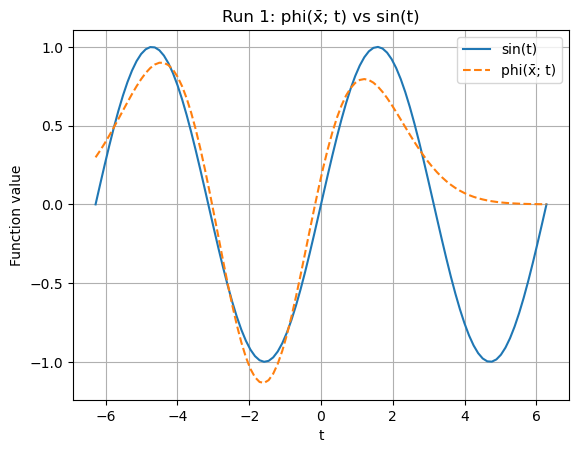


--- Run 2 (scale = 1.0) ---
Starting GNM from initial point with norm: 2.0283
Iter 0: f(x) = 2.538484e+01, ||∇f(x)|| = 1.044297e+01
Iter 10: f(x) = 1.862841e+01, ||∇f(x)|| = 3.813010e-01
Iter 20: f(x) = 1.862090e+01, ||∇f(x)|| = 4.711731e-03
Iter 30: f(x) = 1.862090e+01, ||∇f(x)|| = 5.489503e-05
Converged in 38 iterations.
Final f(x) = 1.862090e+01, ||∇f(x)|| = 8.435445e-07
Stopping criterion: ||g|| < 1e-06 or max_iter = 2000
Final iterate x̄:
[ -0.83631947  -2.07290424   0.47362494   0.60573971   0.3482142
  -0.13989967  -0.83631766  -1.06868648   0.47362407  -0.43050079
 -10.7789588   -4.15131465]
Distance to x*: 12.612759
ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = 1.000000
q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = 0.079285
Runtime: 0.0891 seconds


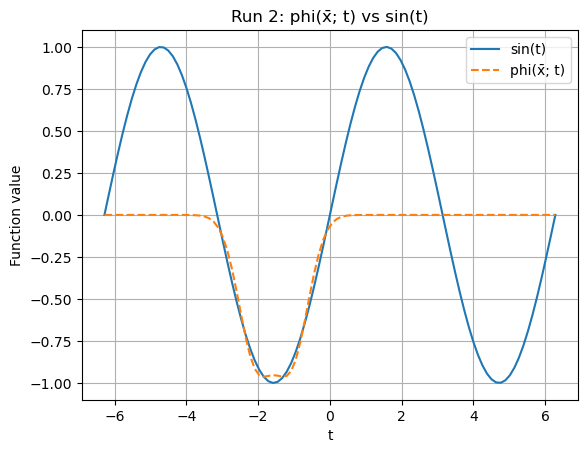


--- Run 3 (scale = 1.5) ---
Starting GNM from initial point with norm: 5.3344
Iter 0: f(x) = 3.529142e+01, ||∇f(x)|| = 3.504404e+01
Converged in 9 iterations.
Final f(x) = 1.876122e+01, ||∇f(x)|| = 7.416232e-07
Stopping criterion: ||g|| < 1e-06 or max_iter = 2000
Final iterate x̄:
[ 0.52100799 -8.1258666  -4.84063979  1.10139062  1.57079633  0.70710676
  1.91600968 -1.07143887 -0.1904199   1.66799472  1.21114523 -0.06721507]
Distance to x*: 10.459057
ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = 1.000000
q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = 0.095611
Runtime: 0.0213 seconds


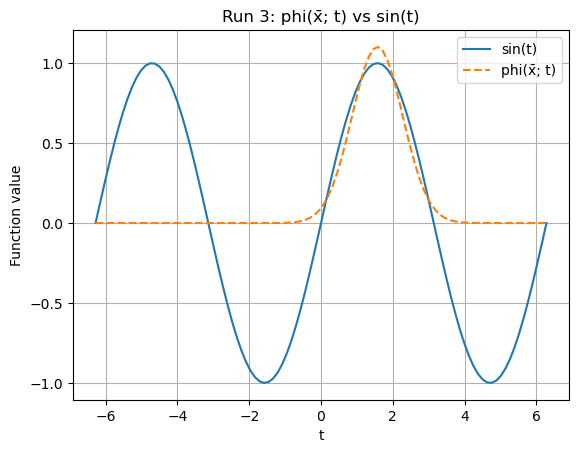


--- Run 4 (scale = 2.0) ---
Starting GNM from initial point with norm: 5.7942
Iter 0: f(x) = 8.627655e+01, ||∇f(x)|| = 6.596060e+01
Iter 10: f(x) = 1.876122e+01, ||∇f(x)|| = 1.043260e-03
Converged in 11 iterations.
Final f(x) = 1.876122e+01, ||∇f(x)|| = 1.433259e-07
Stopping criterion: ||g|| < 1e-06 or max_iter = 2000
Final iterate x̄:
[-6.23830092e-01 -2.24328828e+00 -1.77869770e+00  1.26609167e+00
 -2.47928625e+00 -6.99937815e-01  1.67820708e-01 -2.54493316e+02
 -8.43274736e+01 -1.10139063e+00 -1.57079633e+00  7.07106777e-01]
Distance to x*: 268.476786
ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = 1.000000
q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = 0.003725
Runtime: 0.0263 seconds


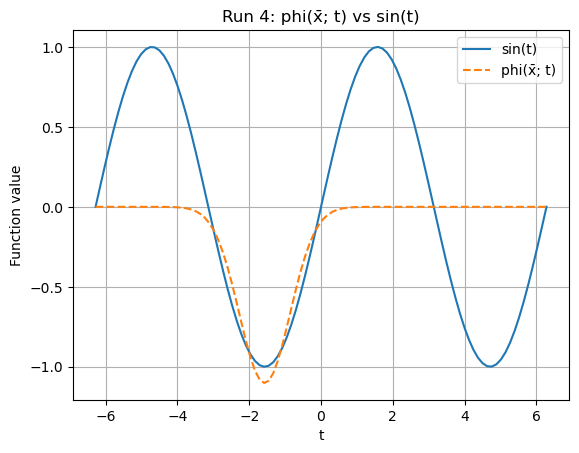


--- Run 5 (scale = 3.0) ---
Starting GNM from initial point with norm: 10.6931
Iter 0: f(x) = 2.757659e+02, ||∇f(x)|| = 1.411822e+02
Converged in 2 iterations.
Final f(x) = 2.475000e+01, ||∇f(x)|| = 0.000000e+00
Stopping criterion: ||g|| < 1e-06 or max_iter = 2000
Final iterate x̄:
[-5.06447997 -0.6043622  -1.92197265  4.6705415  -1.5706839  -4.96000127
 -2.21767198  1.4347658  -2.18663194 -0.66377481 -1.25529044 -0.15919652]
Distance to x*: 11.198074
ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = 0.985543
q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = 0.086738
Runtime: 0.0054 seconds


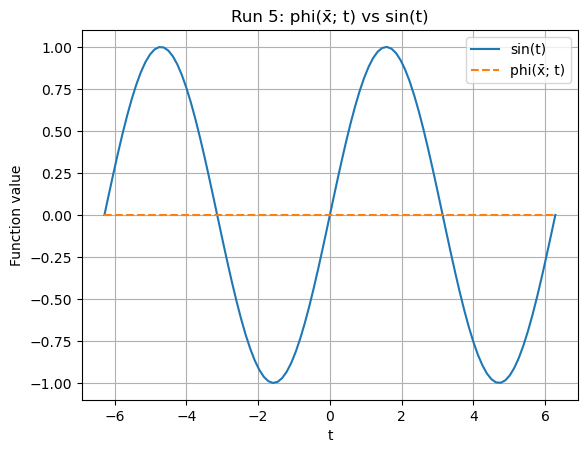

In [38]:
x_star = np.array([1.0, 0.0, 1.0] * l)  # Example target solution, adjust as needed
results_gnm = evaluate_runs(gnm_wrapper, x_star)



## Multi-Method Analysis for Optimization Methods

This section implements a comprehensive analysis of multiple optimization methods as required by the project:

1. **Standard Newton Method**: The classical Newton method without any Hessian modification
2. **Newton Method with Hessian Modification (NM-HM)**: Newton method with positive definite Hessian enforcement
3. **Gauss-Newton Method (GNM)**: Specialized for nonlinear least-squares problems

The analysis focuses on three key aspects:

### 1. Global vs Local Convergence

We test each method with various starting points at different distances from the target solution $x^*$:
- Starting points close to $x^*$ (scales 0.1, 0.5)
- Starting points at moderate distances (scales 1.0, 2.0)
- Starting points far from $x^*$ (scales 3.0+)

For each run, we track:
- Whether the method converges to $x^*$
- Whether it converges to a different local minimizer
- Whether it fails to converge at all

This helps us understand the basin of attraction for each method and its robustness to initial conditions.

### 2. Rate of Convergence

For each successful run, we classify the convergence rate as:
- **Linear**: When $\|x_{k+1} - x^*\| / \|x_k - x^*\| \approx$ constant < 1
- **Superlinear**: When $\|x_{k+1} - x^*\| / \|x_k - x^*\| \to 0$
- **Quadratic**: When $\|x_{k+1} - x^*\| / \|x_k - x^*\|^2 \approx$ constant

This classification helps us verify the theoretical convergence properties of each method.

### 3. Runtime Performance

We measure:
- Average runtime per method
- Average number of iterations to convergence
- Success rate across all runs

The comprehensive analysis provides insights into which method performs best for this specific nonlinear least-squares problem of approximating $\sin(t)$ with a sum of Gaussians.


Finding target solution x_star...
Starting Hybrid GN-BFGS from initial point with norm: 9.6901
Iter 0: f(x) = 3.446452e+01, ||∇f(x)|| = 2.638276e+01
Iter 10: f(x) = 6.939336e-01, ||∇f(x)|| = 2.144246e+00
Iter 20: f(x) = 6.737065e-02, ||∇f(x)|| = 8.904285e-02
Iter 30: f(x) = 6.237456e-02, ||∇f(x)|| = 9.655520e-02
Iter 40: f(x) = 2.893698e-02, ||∇f(x)|| = 4.309361e-01
Iter 50: f(x) = 1.098998e-02, ||∇f(x)|| = 7.212314e-02
Iter 60: f(x) = 8.657000e-03, ||∇f(x)|| = 1.299811e-01
Iter 70: f(x) = 8.307124e-03, ||∇f(x)|| = 6.726542e-03
Iter 80: f(x) = 8.306518e-03, ||∇f(x)|| = 9.551883e-05
Iter 90: f(x) = 8.306515e-03, ||∇f(x)|| = 9.552375e-05
Iter 100: f(x) = 8.306511e-03, ||∇f(x)|| = 9.552885e-05
Iter 110: f(x) = 8.306508e-03, ||∇f(x)|| = 9.553397e-05
Iter 120: f(x) = 8.306504e-03, ||∇f(x)|| = 9.553909e-05
Iter 130: f(x) = 8.306501e-03, ||∇f(x)|| = 9.554421e-05
Iter 140: f(x) = 8.306497e-03, ||∇f(x)|| = 9.554933e-05
Iter 150: f(x) = 8.306494e-03, ||∇f(x)|| = 9.555446e-05
Iter 160: f(x) = 8.3

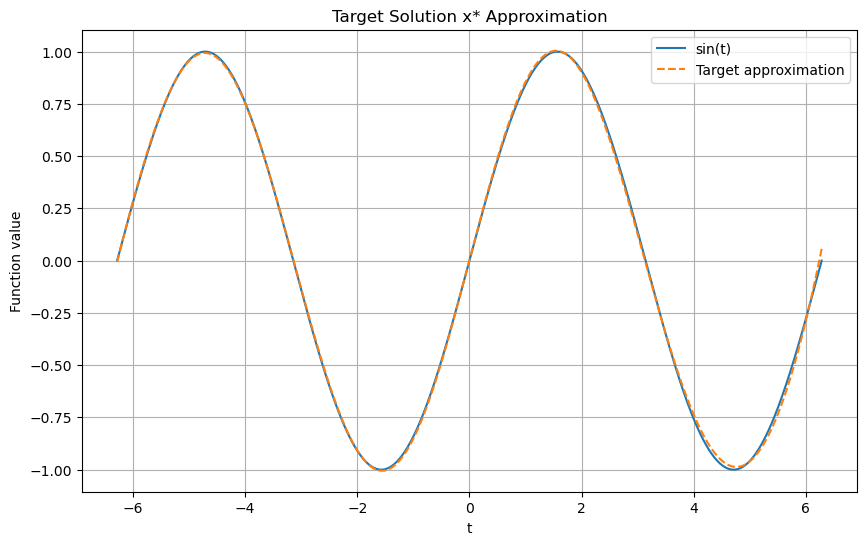

Target solution parameters:
Gaussian 1: alpha=4.1949, mu=-4.6012, sigma=1.9991
Gaussian 2: alpha=-6.7318, mu=20.4029, sigma=20.8555
Gaussian 3: alpha=4.6012, mu=1.4556, sigma=1.9205
Gaussian 4: alpha=94.6050, mu=23.4453, sigma=7.1283

Running comprehensive analysis...

=== Scale 0.1 ===

--- Run 1/3 with scale 0.1 ---

Running Standard Newton...
Starting Standard Newton from initial point with norm: 102.5802
Iter 0: f(x) = 9.910143e-01, ||∇f(x)|| = 1.925482e+01
Standard Newton failed to converge. Final gradient norm: 0.028216
Runtime: 0.0787 seconds
Convergence rates: Linear=2, Superlinear=2, Quadratic=0


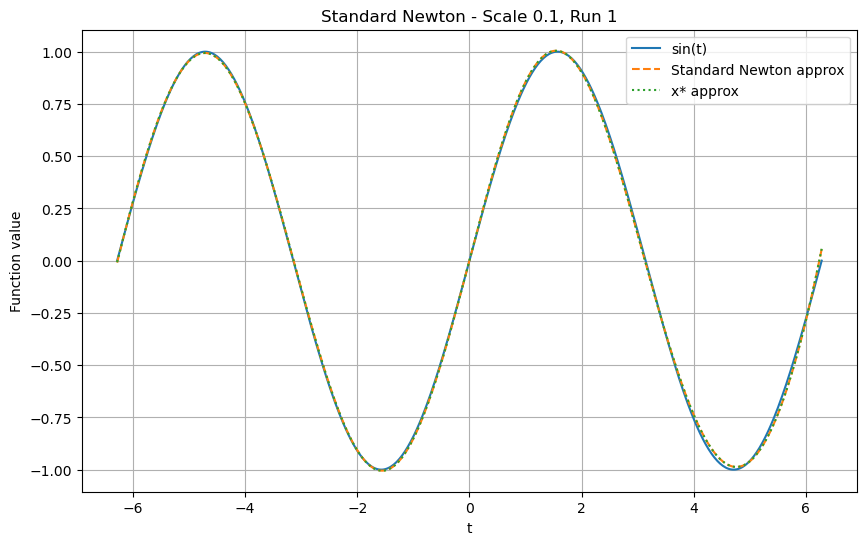


Running Newton with HM...
Starting NM-HM from initial point with norm: 102.5802
Iter 0: f(x) = 9.910143e-01, ||∇f(x)|| = 1.925482e+01
Iter 10: f(x) = 8.291603e-03, ||∇f(x)|| = 1.682119e-03
Iter 20: f(x) = 8.266448e-03, ||∇f(x)|| = 3.235024e-03
Iter 30: f(x) = 8.227853e-03, ||∇f(x)|| = 5.156818e-03
Iter 40: f(x) = 8.157913e-03, ||∇f(x)|| = 8.198880e-03
Iter 50: f(x) = 7.998476e-03, ||∇f(x)|| = 1.479492e-02
Iter 60: f(x) = 7.680233e-03, ||∇f(x)|| = 6.758931e-02
Iter 70: f(x) = 7.606047e-03, ||∇f(x)|| = 7.421765e-04
Iter 80: f(x) = 7.600046e-03, ||∇f(x)|| = 4.789616e-04
Iter 90: f(x) = 7.595458e-03, ||∇f(x)|| = 2.733780e-04
Iter 100: f(x) = 7.591511e-03, ||∇f(x)|| = 1.650410e-04
Iter 110: f(x) = 7.587875e-03, ||∇f(x)|| = 1.079044e-04
Converged in 113 iterations.
Final f(x) = 7.586820e-03, ||∇f(x)|| = 9.659810e-05
Newton with HM converged to a different local minimizer. Distance to x*: 6.332259
Runtime: 0.6194 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


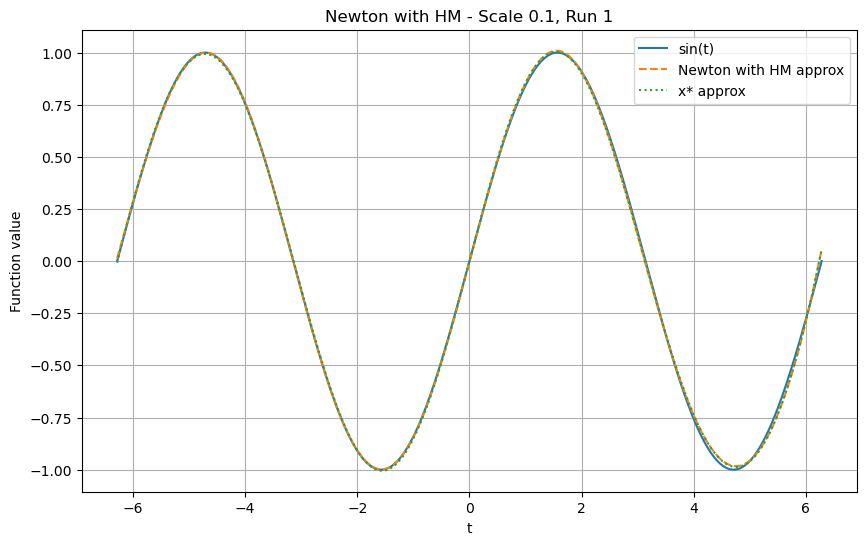


Running Gauss-Newton...
Starting GNM from initial point with norm: 102.5802
Iter 0: f(x) = 9.910143e-01, ||∇f(x)|| = 1.925482e+01
Iter 10: f(x) = 9.908258e-01, ||∇f(x)|| = 1.923837e+01
Iter 20: f(x) = 9.905932e-01, ||∇f(x)|| = 1.922193e+01
Iter 30: f(x) = 9.903219e-01, ||∇f(x)|| = 1.920551e+01
Iter 40: f(x) = 9.901648e-01, ||∇f(x)|| = 1.918391e+01
Iter 50: f(x) = 9.899263e-01, ||∇f(x)|| = 1.915770e+01
Iter 60: f(x) = 9.895121e-01, ||∇f(x)|| = 1.913045e+01
Iter 70: f(x) = 9.890195e-01, ||∇f(x)|| = 1.910108e+01
Iter 80: f(x) = 9.885883e-01, ||∇f(x)|| = 1.905461e+01
Iter 90: f(x) = 9.876959e-01, ||∇f(x)|| = 1.900023e+01
Iter 100: f(x) = 9.863300e-01, ||∇f(x)|| = 1.890312e+01
Iter 110: f(x) = 9.834550e-01, ||∇f(x)|| = 1.864581e+01
Iter 120: f(x) = 9.544173e-01, ||∇f(x)|| = 1.592888e+01
Iter 130: f(x) = 2.706343e-05, ||∇f(x)|| = 1.614714e-03
Converged in 131 iterations.
Final f(x) = 2.705749e-05, ||∇f(x)|| = 9.622077e-06
Gauss-Newton converged to a different local minimizer. Distance to x*

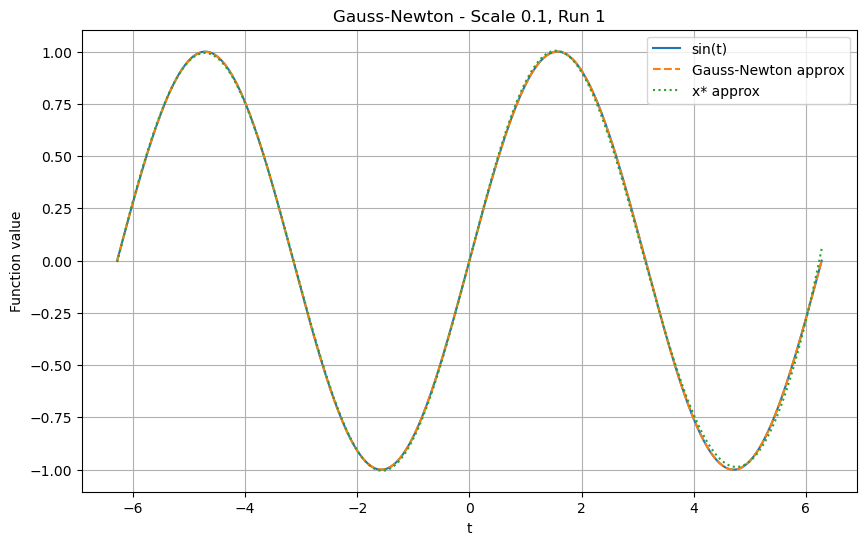


Running Hybrid GN-BFGS...
Starting Hybrid GN-BFGS from initial point with norm: 102.5802
Iter 0: f(x) = 9.910143e-01, ||∇f(x)|| = 1.925482e+01
Iter 10: f(x) = 8.303552e-03, ||∇f(x)|| = 9.473632e-03
Iter 20: f(x) = 8.280428e-03, ||∇f(x)|| = 4.255205e-02
Iter 30: f(x) = 8.258473e-03, ||∇f(x)|| = 1.341612e-03
Iter 40: f(x) = 8.233639e-03, ||∇f(x)|| = 3.737425e-02
Iter 50: f(x) = 8.148512e-03, ||∇f(x)|| = 2.463382e-02
Iter 60: f(x) = 7.903459e-03, ||∇f(x)|| = 4.497216e-02
Iter 70: f(x) = 7.753208e-03, ||∇f(x)|| = 1.241664e-03
Iter 80: f(x) = 7.698326e-03, ||∇f(x)|| = 4.439203e-02
Iter 90: f(x) = 7.641972e-03, ||∇f(x)|| = 5.670366e-03
Iter 100: f(x) = 7.633256e-03, ||∇f(x)|| = 4.582173e-04
Iter 110: f(x) = 7.633243e-03, ||∇f(x)|| = 2.338603e-04
Iter 120: f(x) = 7.633235e-03, ||∇f(x)|| = 2.332230e-04
Iter 130: f(x) = 7.633227e-03, ||∇f(x)|| = 2.331774e-04
Iter 140: f(x) = 7.633219e-03, ||∇f(x)|| = 2.331681e-04
Iter 150: f(x) = 7.633210e-03, ||∇f(x)|| = 2.331607e-04
Iter 160: f(x) = 7.633202

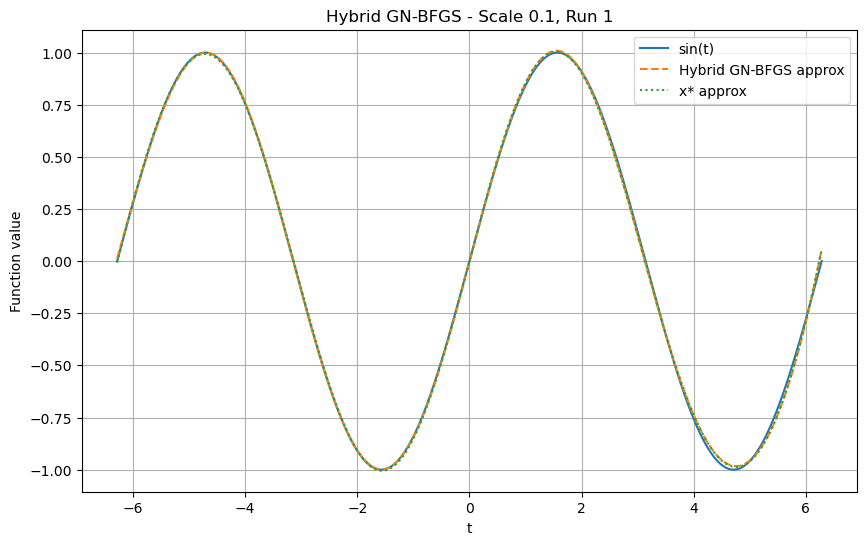


--- Run 2/3 with scale 0.1 ---

Running Standard Newton...
Starting Standard Newton from initial point with norm: 102.5310
Iter 0: f(x) = 4.848109e+00, ||∇f(x)|| = 5.828175e+01
Standard Newton failed to converge. Final gradient norm: 3.967835
Runtime: 0.0881 seconds
Convergence rates: Linear=3, Superlinear=1, Quadratic=0


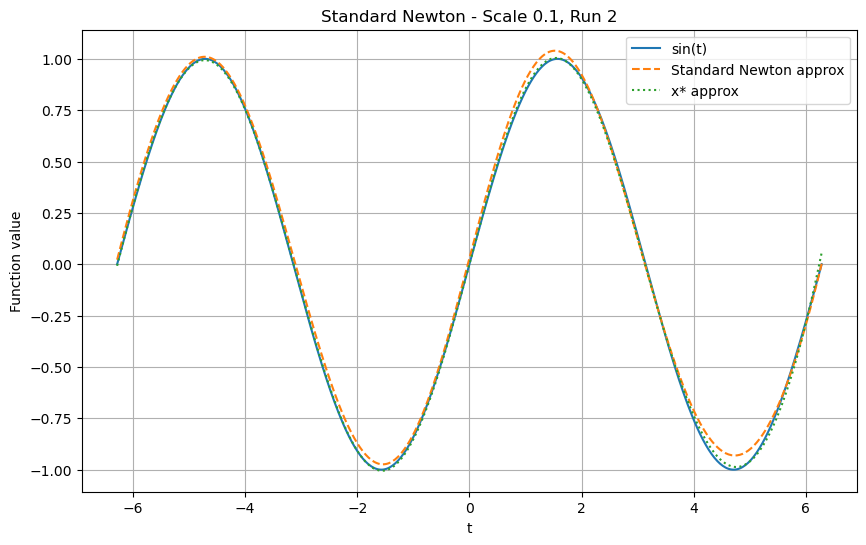


Running Newton with HM...
Starting NM-HM from initial point with norm: 102.5310
Iter 0: f(x) = 4.848109e+00, ||∇f(x)|| = 5.828175e+01
Iter 10: f(x) = 8.306268e-03, ||∇f(x)|| = 8.156209e-03
Iter 20: f(x) = 8.281081e-03, ||∇f(x)|| = 4.939332e-03
Iter 30: f(x) = 8.250896e-03, ||∇f(x)|| = 5.041232e-03
Iter 40: f(x) = 8.201382e-03, ||∇f(x)|| = 6.695978e-03
Iter 50: f(x) = 8.102570e-03, ||∇f(x)|| = 1.055467e-02
Iter 60: f(x) = 7.852876e-03, ||∇f(x)|| = 1.929943e-02
Iter 70: f(x) = 7.595366e-03, ||∇f(x)|| = 3.364615e-02
Iter 80: f(x) = 7.577045e-03, ||∇f(x)|| = 5.666818e-04
Iter 90: f(x) = 7.572292e-03, ||∇f(x)|| = 3.403010e-04
Iter 100: f(x) = 7.568418e-03, ||∇f(x)|| = 1.998882e-04
Iter 110: f(x) = 7.564957e-03, ||∇f(x)|| = 1.253644e-04
Converged in 116 iterations.
Final f(x) = 7.562987e-03, ||∇f(x)|| = 9.844086e-05
Newton with HM converged to a different local minimizer. Distance to x*: 7.421813
Runtime: 0.6445 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


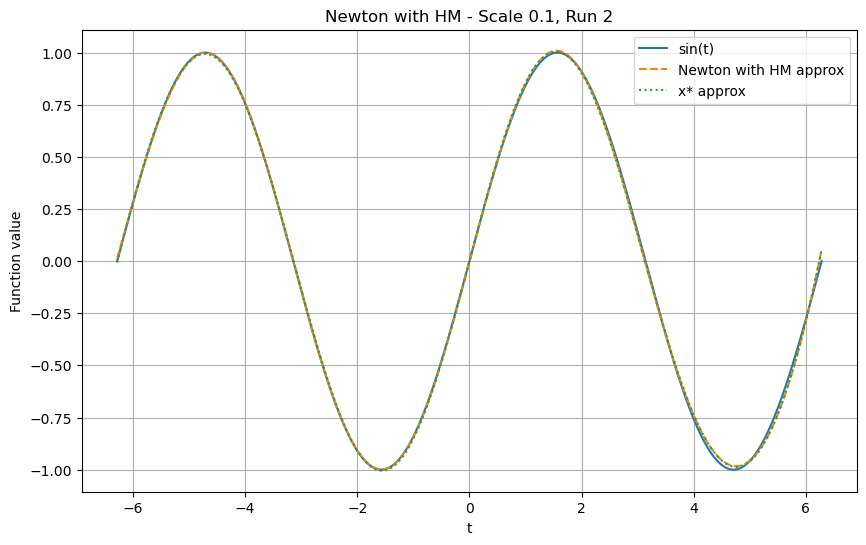


Running Gauss-Newton...
Starting GNM from initial point with norm: 102.5310
Iter 0: f(x) = 4.848109e+00, ||∇f(x)|| = 5.828175e+01
Iter 10: f(x) = 4.843025e+00, ||∇f(x)|| = 5.737075e+01
Iter 20: f(x) = 2.920618e+00, ||∇f(x)|| = 2.285708e+01
Iter 30: f(x) = 2.705749e-05, ||∇f(x)|| = 1.788347e-05
Converged in 30 iterations.
Final f(x) = 2.705749e-05, ||∇f(x)|| = 1.788347e-05
Gauss-Newton converged to a different local minimizer. Distance to x*: 95.342858
Runtime: 0.2123 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


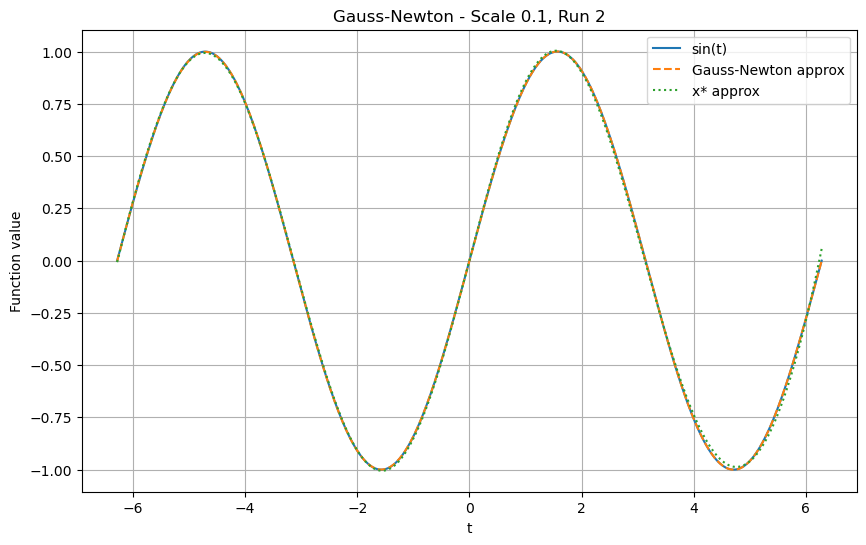


Running Hybrid GN-BFGS...
Starting Hybrid GN-BFGS from initial point with norm: 102.5310
Iter 0: f(x) = 4.848109e+00, ||∇f(x)|| = 5.828175e+01
Iter 10: f(x) = 8.327298e-03, ||∇f(x)|| = 4.316571e-02
Iter 20: f(x) = 8.290557e-03, ||∇f(x)|| = 1.575326e-02
Iter 30: f(x) = 8.261496e-03, ||∇f(x)|| = 3.316627e-03
Iter 40: f(x) = 8.254675e-03, ||∇f(x)|| = 6.829775e-04
Iter 50: f(x) = 8.236071e-03, ||∇f(x)|| = 4.679593e-02
Iter 60: f(x) = 8.142741e-03, ||∇f(x)|| = 9.476244e-02
Iter 70: f(x) = 7.824512e-03, ||∇f(x)|| = 7.265248e-02
Iter 80: f(x) = 7.752423e-03, ||∇f(x)|| = 8.088067e-04
Iter 90: f(x) = 7.751995e-03, ||∇f(x)|| = 1.623677e-03
Iter 100: f(x) = 7.751545e-03, ||∇f(x)|| = 1.621685e-03
Iter 110: f(x) = 7.751095e-03, ||∇f(x)|| = 1.619677e-03
Iter 120: f(x) = 7.750645e-03, ||∇f(x)|| = 1.617653e-03
Iter 130: f(x) = 7.750196e-03, ||∇f(x)|| = 1.615613e-03
Iter 140: f(x) = 7.749747e-03, ||∇f(x)|| = 1.613557e-03
Iter 150: f(x) = 7.749297e-03, ||∇f(x)|| = 1.611485e-03
Iter 160: f(x) = 7.748849

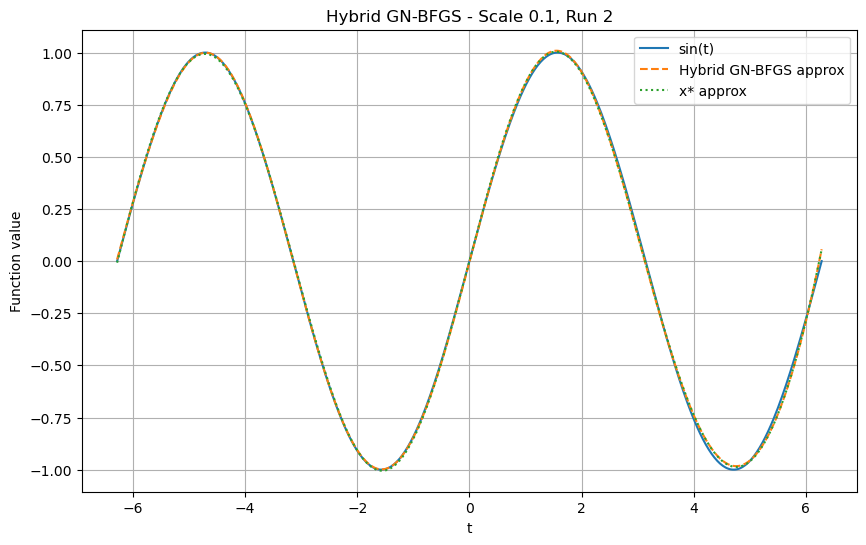


--- Run 3/3 with scale 0.1 ---

Running Standard Newton...
Starting Standard Newton from initial point with norm: 102.5289
Iter 0: f(x) = 1.049907e+00, ||∇f(x)|| = 1.648489e+01
Standard Newton failed to converge. Final gradient norm: 15.080198
Runtime: 0.0348 seconds
Convergence rates: Linear=0, Superlinear=0, Quadratic=0


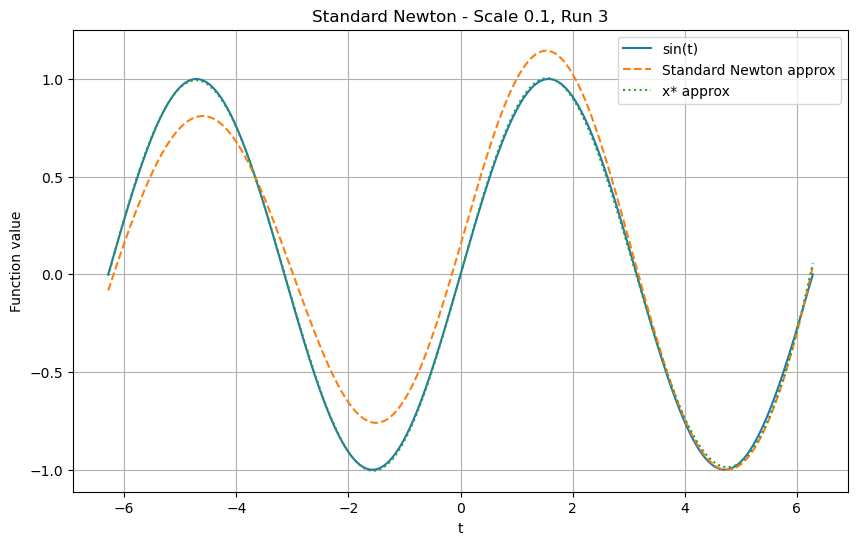


Running Newton with HM...
Starting NM-HM from initial point with norm: 102.5289
Iter 0: f(x) = 1.049907e+00, ||∇f(x)|| = 1.648489e+01
Iter 10: f(x) = 8.326484e-03, ||∇f(x)|| = 5.290430e-02
Iter 20: f(x) = 8.279217e-03, ||∇f(x)|| = 2.855501e-03
Iter 30: f(x) = 8.248346e-03, ||∇f(x)|| = 4.374146e-03
Iter 40: f(x) = 8.196131e-03, ||∇f(x)|| = 6.650519e-03
Iter 50: f(x) = 8.089855e-03, ||∇f(x)|| = 1.107221e-02
Iter 60: f(x) = 7.855727e-03, ||∇f(x)|| = 1.756959e-01
Iter 70: f(x) = 7.583900e-03, ||∇f(x)|| = 2.041271e-03
Iter 80: f(x) = 7.572005e-03, ||∇f(x)|| = 5.114229e-04
Iter 90: f(x) = 7.567304e-03, ||∇f(x)|| = 3.236838e-04
Iter 100: f(x) = 7.563430e-03, ||∇f(x)|| = 1.913964e-04
Iter 110: f(x) = 7.559944e-03, ||∇f(x)|| = 1.209041e-04
Converged in 115 iterations.
Final f(x) = 7.558282e-03, ||∇f(x)|| = 9.904083e-05
Newton with HM converged to a different local minimizer. Distance to x*: 7.889408
Runtime: 0.6553 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


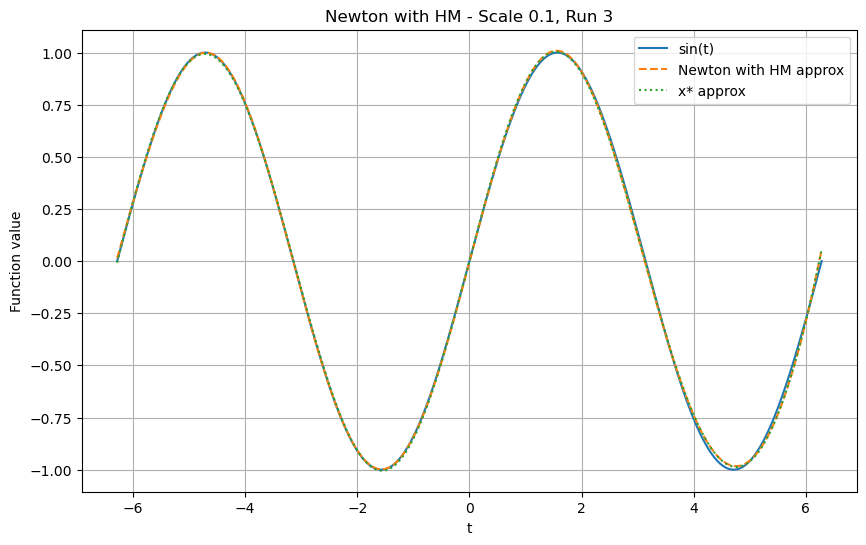


Running Gauss-Newton...
Starting GNM from initial point with norm: 102.5289
Iter 0: f(x) = 1.049907e+00, ||∇f(x)|| = 1.648489e+01
Iter 10: f(x) = 1.049722e+00, ||∇f(x)|| = 1.649322e+01
Iter 20: f(x) = 1.049490e+00, ||∇f(x)|| = 1.650428e+01
Iter 30: f(x) = 1.049071e+00, ||∇f(x)|| = 1.651137e+01
Iter 40: f(x) = 1.048506e+00, ||∇f(x)|| = 1.651541e+01
Iter 50: f(x) = 1.048160e+00, ||∇f(x)|| = 1.653374e+01
Iter 60: f(x) = 1.047267e+00, ||∇f(x)|| = 1.654188e+01
Iter 70: f(x) = 1.046409e+00, ||∇f(x)|| = 1.655660e+01
Iter 80: f(x) = 1.044622e+00, ||∇f(x)|| = 1.655774e+01
Iter 90: f(x) = 1.041770e+00, ||∇f(x)|| = 1.653345e+01
Iter 100: f(x) = 1.034473e+00, ||∇f(x)|| = 1.635401e+01
Iter 110: f(x) = 9.916466e-01, ||∇f(x)|| = 1.518069e+01
Converged in 118 iterations.
Final f(x) = 2.705749e-05, ||∇f(x)|| = 1.521460e-05
Gauss-Newton converged to a different local minimizer. Distance to x*: 95.342782
Runtime: 0.9910 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


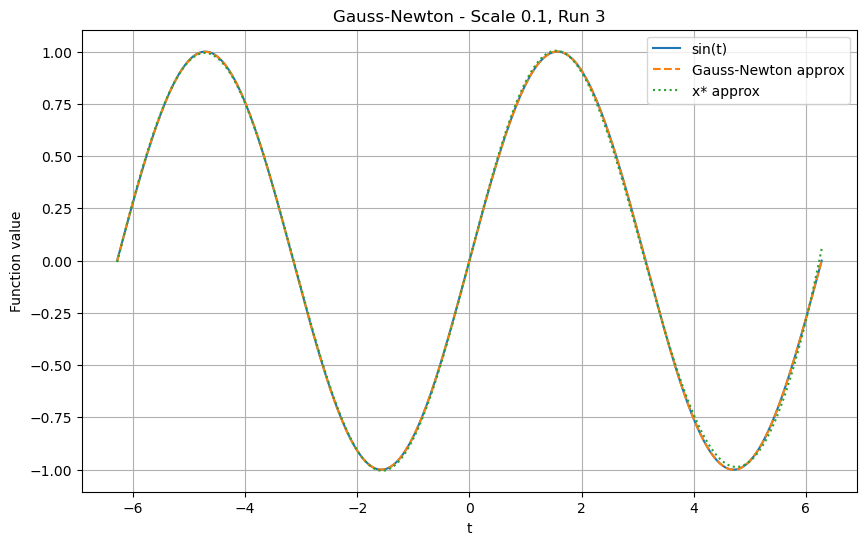


Running Hybrid GN-BFGS...
Starting Hybrid GN-BFGS from initial point with norm: 102.5289
Iter 0: f(x) = 1.049907e+00, ||∇f(x)|| = 1.648489e+01
Iter 10: f(x) = 8.316129e-03, ||∇f(x)|| = 3.029936e-03
Iter 20: f(x) = 8.315800e-03, ||∇f(x)|| = 3.040311e-04
Iter 30: f(x) = 8.315582e-03, ||∇f(x)|| = 2.976554e-04
Iter 40: f(x) = 8.315366e-03, ||∇f(x)|| = 2.958542e-04
Iter 50: f(x) = 8.315152e-03, ||∇f(x)|| = 2.954285e-04
Iter 60: f(x) = 8.314940e-03, ||∇f(x)|| = 2.954774e-04
Iter 70: f(x) = 8.314730e-03, ||∇f(x)|| = 2.957033e-04
Iter 80: f(x) = 8.314522e-03, ||∇f(x)|| = 2.959979e-04
Iter 90: f(x) = 8.314316e-03, ||∇f(x)|| = 2.963193e-04
Iter 100: f(x) = 8.314112e-03, ||∇f(x)|| = 2.966510e-04
Iter 110: f(x) = 8.313909e-03, ||∇f(x)|| = 2.969859e-04
Iter 120: f(x) = 8.313709e-03, ||∇f(x)|| = 2.973211e-04
Iter 130: f(x) = 8.313511e-03, ||∇f(x)|| = 2.976550e-04
Iter 140: f(x) = 8.313314e-03, ||∇f(x)|| = 2.979867e-04
Iter 150: f(x) = 8.313119e-03, ||∇f(x)|| = 2.983154e-04
Iter 160: f(x) = 8.312926

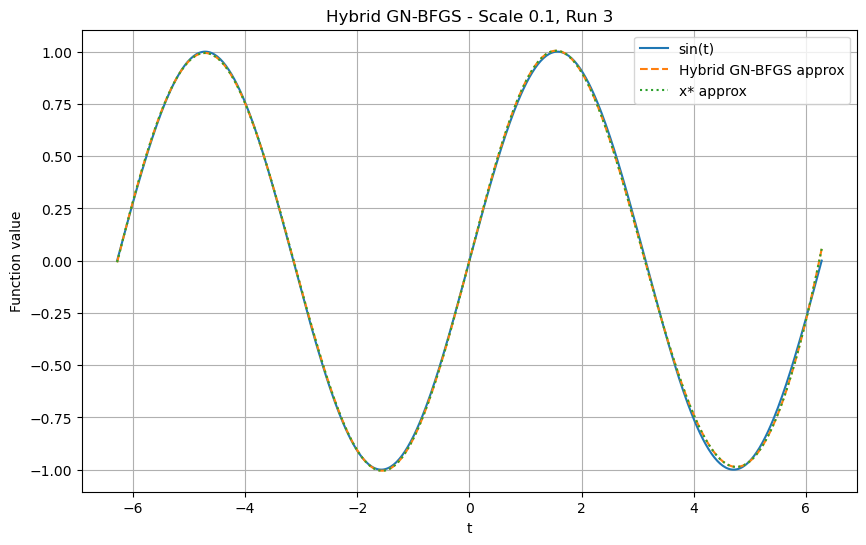


=== Scale 0.5 ===

--- Run 1/3 with scale 0.5 ---

Running Standard Newton...
Starting Standard Newton from initial point with norm: 102.2038
Iter 0: f(x) = 1.289721e+02, ||∇f(x)|| = 3.653002e+02
Standard Newton failed to converge. Final gradient norm: 13.942767
Runtime: 0.0560 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


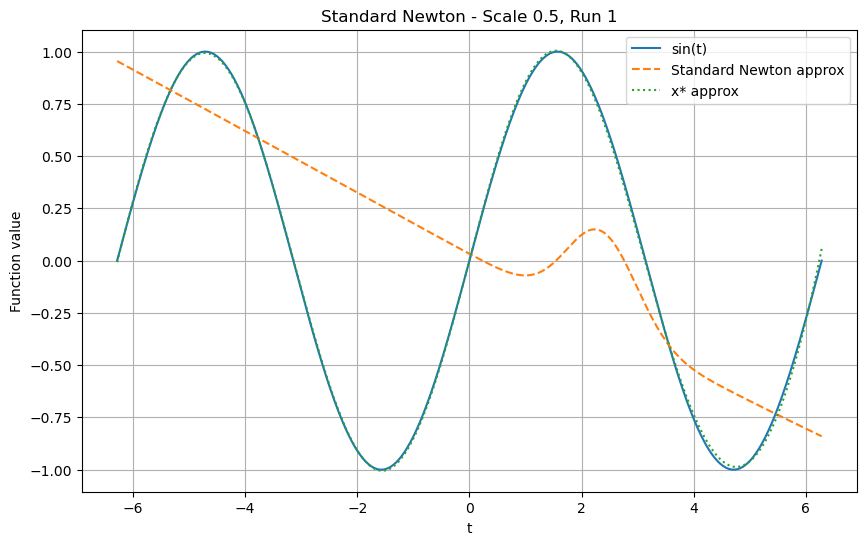


Running Newton with HM...
Starting NM-HM from initial point with norm: 102.2038
Iter 0: f(x) = 1.289721e+02, ||∇f(x)|| = 3.653002e+02
Iter 10: f(x) = 8.284471e-03, ||∇f(x)|| = 1.561375e-02
Iter 20: f(x) = 8.230523e-03, ||∇f(x)|| = 9.065439e-03
Iter 30: f(x) = 8.159014e-03, ||∇f(x)|| = 9.458443e-03
Iter 40: f(x) = 8.001357e-03, ||∇f(x)|| = 1.484205e-02
Iter 50: f(x) = 7.693163e-03, ||∇f(x)|| = 1.742993e-02
Iter 60: f(x) = 7.583434e-03, ||∇f(x)|| = 3.942224e-04
Iter 70: f(x) = 7.578508e-03, ||∇f(x)|| = 3.584281e-04
Iter 80: f(x) = 7.574617e-03, ||∇f(x)|| = 2.122100e-04
Iter 90: f(x) = 7.571177e-03, ||∇f(x)|| = 1.319267e-04
Converged in 97 iterations.
Final f(x) = 7.568909e-03, ||∇f(x)|| = 9.903890e-05
Newton with HM converged to a different local minimizer. Distance to x*: 6.948906
Runtime: 0.5292 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


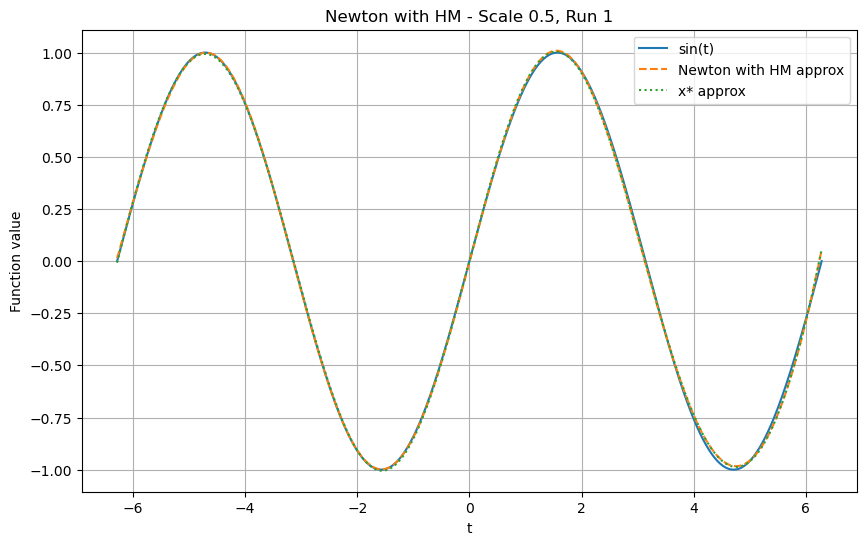


Running Gauss-Newton...
Starting GNM from initial point with norm: 102.2038
Iter 0: f(x) = 1.289721e+02, ||∇f(x)|| = 3.653002e+02
Iter 10: f(x) = 1.869918e+01, ||∇f(x)|| = 5.970957e-03
Iter 20: f(x) = 1.869918e+01, ||∇f(x)|| = 2.694334e-04
Converged in 24 iterations.
Final f(x) = 1.869918e+01, ||∇f(x)|| = 7.807022e-05
Gauss-Newton converged to a different local minimizer. Distance to x*: 11434.372543
Runtime: 0.0553 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


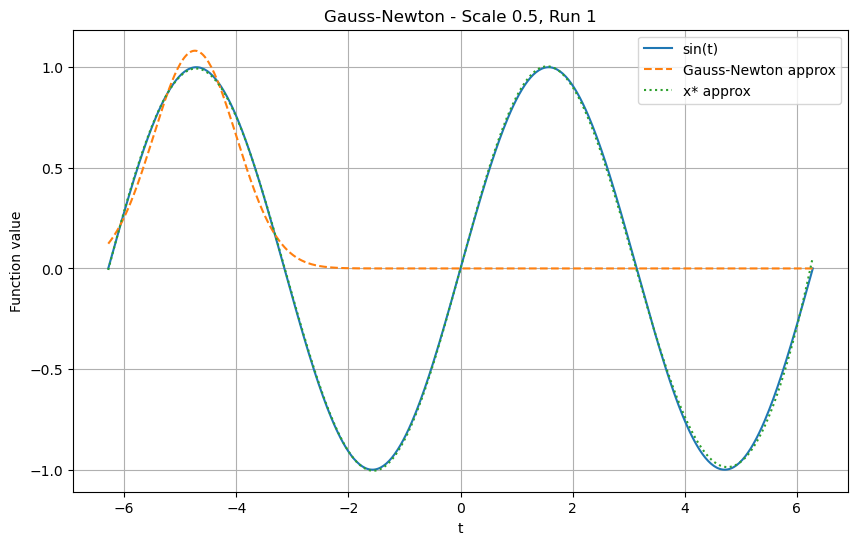


Running Hybrid GN-BFGS...
Starting Hybrid GN-BFGS from initial point with norm: 102.2038
Iter 0: f(x) = 1.289721e+02, ||∇f(x)|| = 3.653002e+02
Iter 10: f(x) = 9.382543e-03, ||∇f(x)|| = 6.188611e-02
Iter 20: f(x) = 8.316561e-03, ||∇f(x)|| = 5.777642e-04
Iter 30: f(x) = 8.261244e-03, ||∇f(x)|| = 6.560618e-03
Iter 40: f(x) = 8.245461e-03, ||∇f(x)|| = 1.003813e-02
Iter 50: f(x) = 8.243595e-03, ||∇f(x)|| = 9.710279e-03
Iter 60: f(x) = 8.135363e-03, ||∇f(x)|| = 6.953296e-02
Iter 70: f(x) = 7.636452e-03, ||∇f(x)|| = 3.444100e-03
Iter 80: f(x) = 7.634778e-03, ||∇f(x)|| = 1.308333e-03
Iter 90: f(x) = 7.634699e-03, ||∇f(x)|| = 1.419010e-03
Iter 100: f(x) = 7.634622e-03, ||∇f(x)|| = 1.438257e-03
Iter 110: f(x) = 7.634544e-03, ||∇f(x)|| = 1.439636e-03
Iter 120: f(x) = 7.634467e-03, ||∇f(x)|| = 1.437770e-03
Iter 130: f(x) = 7.634391e-03, ||∇f(x)|| = 1.435315e-03
Iter 140: f(x) = 7.634314e-03, ||∇f(x)|| = 1.432748e-03
Iter 150: f(x) = 7.634238e-03, ||∇f(x)|| = 1.430158e-03
Iter 160: f(x) = 7.634162

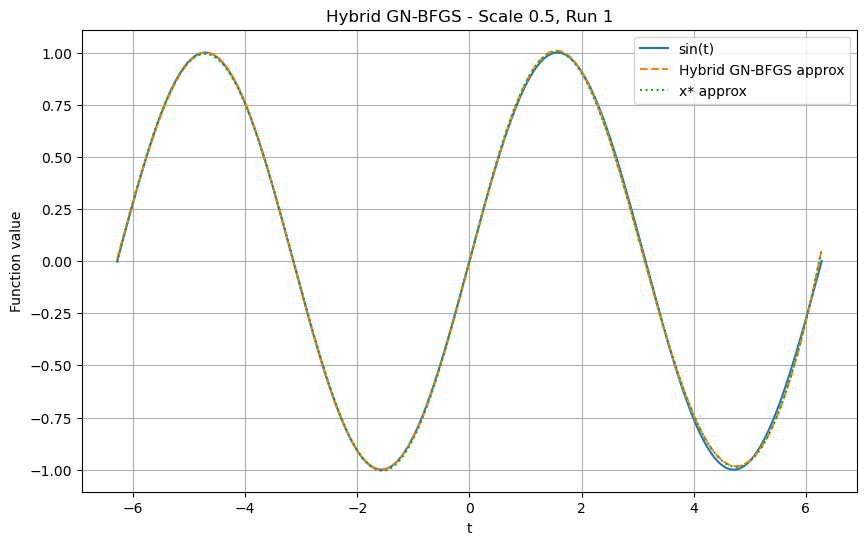


--- Run 2/3 with scale 0.5 ---

Running Standard Newton...
Starting Standard Newton from initial point with norm: 102.3444
Iter 0: f(x) = 9.844656e+01, ||∇f(x)|| = 1.882549e+02
Standard Newton failed to converge. Final gradient norm: 26.194700
Runtime: 0.0480 seconds
Convergence rates: Linear=2, Superlinear=0, Quadratic=0


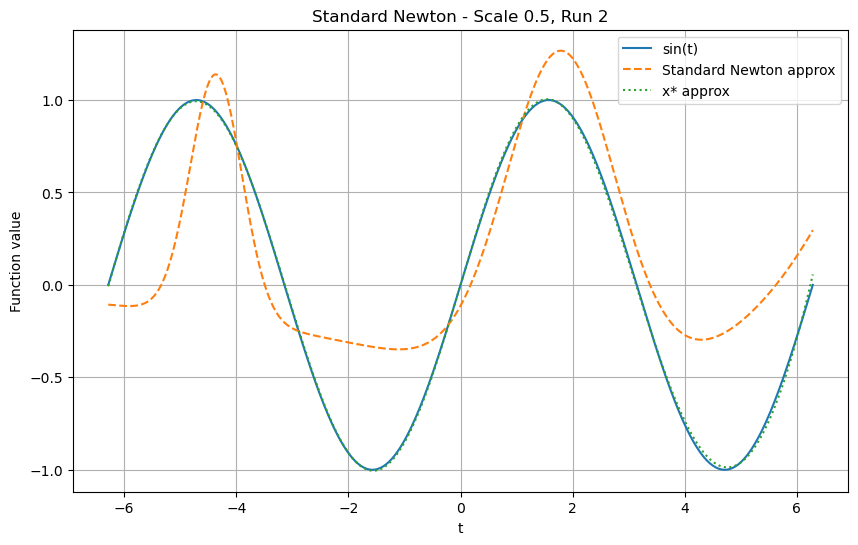


Running Newton with HM...
Starting NM-HM from initial point with norm: 102.3444
Iter 0: f(x) = 9.844656e+01, ||∇f(x)|| = 1.882549e+02
Iter 10: f(x) = 1.021544e-02, ||∇f(x)|| = 1.029340e+00
Iter 20: f(x) = 8.265698e-03, ||∇f(x)|| = 1.440283e-02
Iter 30: f(x) = 8.202772e-03, ||∇f(x)|| = 1.017398e-02
Iter 40: f(x) = 8.105233e-03, ||∇f(x)|| = 1.121934e-02
Iter 50: f(x) = 7.860078e-03, ||∇f(x)|| = 1.934201e-02
Iter 60: f(x) = 7.577890e-03, ||∇f(x)|| = 4.536787e-04
Iter 70: f(x) = 7.544404e-03, ||∇f(x)|| = 2.262622e-04
Iter 80: f(x) = 7.541286e-03, ||∇f(x)|| = 1.549978e-04
Iter 90: f(x) = 7.538461e-03, ||∇f(x)|| = 1.000058e-04
Converged in 91 iterations.
Final f(x) = 7.538188e-03, ||∇f(x)|| = 9.606488e-05
Newton with HM converged to a different local minimizer. Distance to x*: 8.282492
Runtime: 0.5419 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


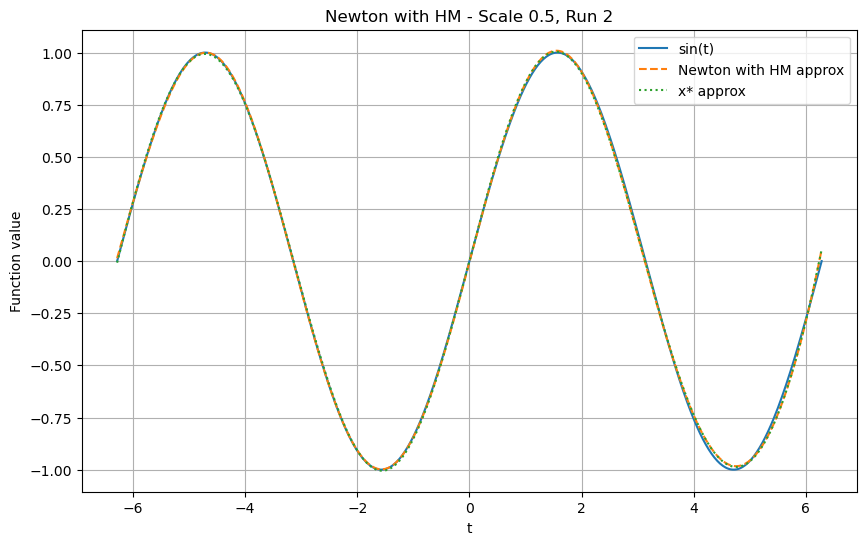


Running Gauss-Newton...
Starting GNM from initial point with norm: 102.3444
Iter 0: f(x) = 9.844656e+01, ||∇f(x)|| = 1.882549e+02
Iter 10: f(x) = 8.682845e+01, ||∇f(x)|| = 1.885226e+02
Iter 20: f(x) = 8.682415e+01, ||∇f(x)|| = 1.894360e+02
Iter 30: f(x) = 8.682165e+01, ||∇f(x)|| = 1.899496e+02
Iter 40: f(x) = 8.681965e+01, ||∇f(x)|| = 1.903719e+02
Iter 50: f(x) = 8.681870e+01, ||∇f(x)|| = 1.907610e+02
Iter 60: f(x) = 8.681724e+01, ||∇f(x)|| = 1.909335e+02
Iter 70: f(x) = 8.681604e+01, ||∇f(x)|| = 1.911200e+02
Iter 80: f(x) = 8.681518e+01, ||∇f(x)|| = 1.913230e+02
Iter 90: f(x) = 8.681474e+01, ||∇f(x)|| = 1.915449e+02
Iter 100: f(x) = 8.681414e+01, ||∇f(x)|| = 1.916704e+02
Iter 110: f(x) = 8.681339e+01, ||∇f(x)|| = 1.917511e+02
Iter 120: f(x) = 8.681270e+01, ||∇f(x)|| = 1.918353e+02
Iter 130: f(x) = 8.681209e+01, ||∇f(x)|| = 1.919231e+02
Iter 140: f(x) = 8.681157e+01, ||∇f(x)|| = 1.920149e+02
Iter 150: f(x) = 8.681114e+01, ||∇f(x)|| = 1.921111e+02
Iter 160: f(x) = 8.681083e+01, ||∇f(x)

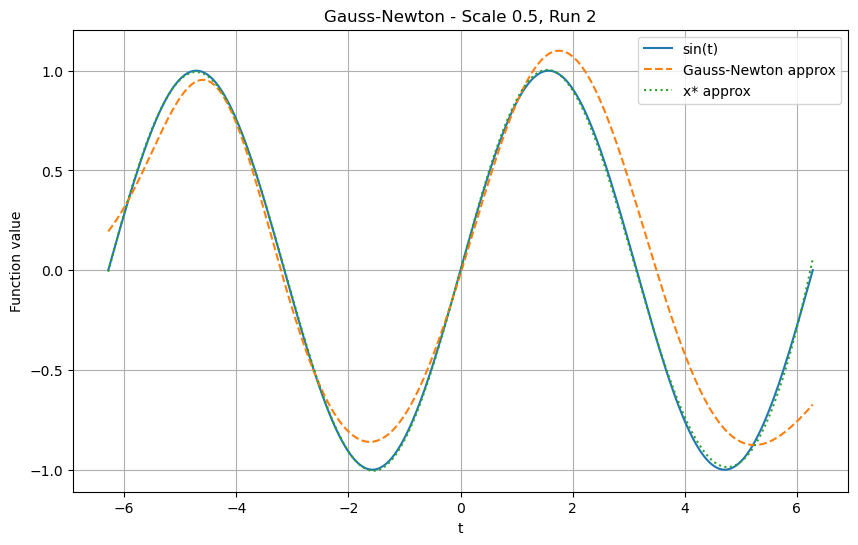


Running Hybrid GN-BFGS...
Starting Hybrid GN-BFGS from initial point with norm: 102.3444
Iter 0: f(x) = 9.844656e+01, ||∇f(x)|| = 1.882549e+02
Iter 10: f(x) = 1.870127e-02, ||∇f(x)|| = 6.590662e-01
Iter 20: f(x) = 8.342000e-03, ||∇f(x)|| = 1.362974e-03
Iter 30: f(x) = 8.277027e-03, ||∇f(x)|| = 2.778495e-02
Iter 40: f(x) = 8.271987e-03, ||∇f(x)|| = 1.412286e-03
Iter 50: f(x) = 8.180793e-03, ||∇f(x)|| = 5.301105e-02
Iter 60: f(x) = 7.625263e-03, ||∇f(x)|| = 3.676497e-02
Iter 70: f(x) = 7.615012e-03, ||∇f(x)|| = 2.105953e-02
Iter 80: f(x) = 7.597981e-03, ||∇f(x)|| = 5.608669e-03
Iter 90: f(x) = 7.597473e-03, ||∇f(x)|| = 3.303214e-04
Iter 100: f(x) = 7.597467e-03, ||∇f(x)|| = 3.319570e-04
Iter 110: f(x) = 7.597461e-03, ||∇f(x)|| = 3.319516e-04
Iter 120: f(x) = 7.597455e-03, ||∇f(x)|| = 3.319455e-04
Iter 130: f(x) = 7.597449e-03, ||∇f(x)|| = 3.319394e-04
Iter 140: f(x) = 7.597443e-03, ||∇f(x)|| = 3.319333e-04
Iter 150: f(x) = 7.597437e-03, ||∇f(x)|| = 3.319272e-04
Iter 160: f(x) = 7.597432

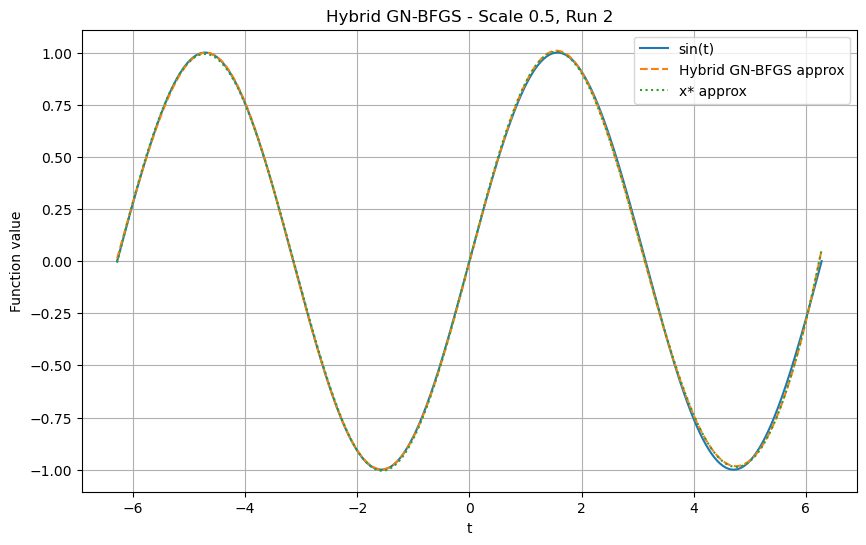


--- Run 3/3 with scale 0.5 ---

Running Standard Newton...
Starting Standard Newton from initial point with norm: 102.6133
Iter 0: f(x) = 9.429434e+01, ||∇f(x)|| = 3.231652e+02
Standard Newton failed to converge. Final gradient norm: 28.025426
Runtime: 0.0514 seconds
Convergence rates: Linear=1, Superlinear=2, Quadratic=0


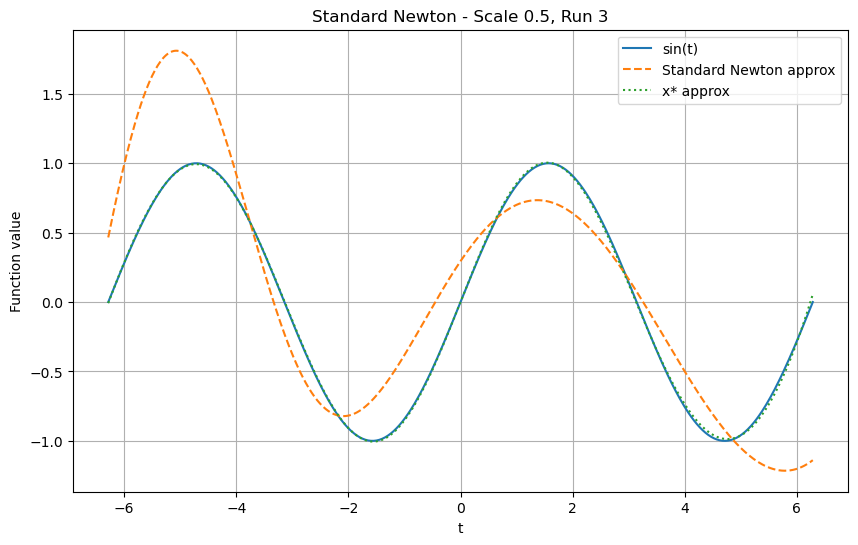


Running Newton with HM...
Starting NM-HM from initial point with norm: 102.6133
Iter 0: f(x) = 9.429434e+01, ||∇f(x)|| = 3.231652e+02
Iter 10: f(x) = 8.298544e-03, ||∇f(x)|| = 6.464435e-03
Iter 20: f(x) = 8.274141e-03, ||∇f(x)|| = 4.662150e-03
Iter 30: f(x) = 8.240106e-03, ||∇f(x)|| = 5.316069e-03
Iter 40: f(x) = 8.181209e-03, ||∇f(x)|| = 7.440768e-03
Iter 50: f(x) = 8.055088e-03, ||∇f(x)|| = 1.242119e-02
Iter 60: f(x) = 7.753774e-03, ||∇f(x)|| = 2.404953e-03
Iter 70: f(x) = 7.548703e-03, ||∇f(x)|| = 5.006950e-02
Iter 80: f(x) = 7.531120e-03, ||∇f(x)|| = 6.878029e-04
Iter 90: f(x) = 7.526338e-03, ||∇f(x)|| = 4.255695e-04
Iter 100: f(x) = 7.522724e-03, ||∇f(x)|| = 2.467909e-04
Iter 110: f(x) = 7.519673e-03, ||∇f(x)|| = 1.493845e-04
Iter 120: f(x) = 7.516896e-03, ||∇f(x)|| = 9.630212e-05
Converged in 120 iterations.
Final f(x) = 7.516896e-03, ||∇f(x)|| = 9.630212e-05
Newton with HM converged to a different local minimizer. Distance to x*: 9.804873
Runtime: 0.7665 seconds
Convergence rat

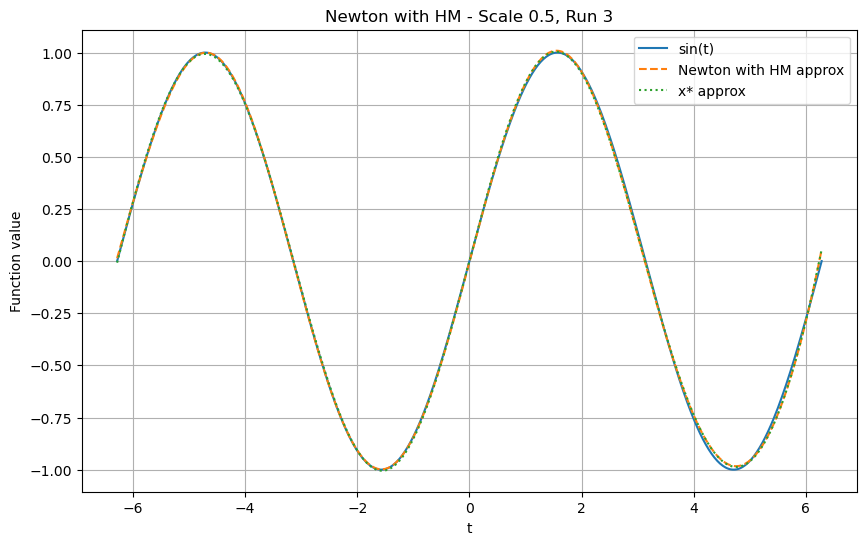


Running Gauss-Newton...
Starting GNM from initial point with norm: 102.6133
Iter 0: f(x) = 9.429434e+01, ||∇f(x)|| = 3.231652e+02
Iter 10: f(x) = 9.429307e+01, ||∇f(x)|| = 3.237419e+02
Iter 20: f(x) = 9.429053e+01, ||∇f(x)|| = 3.241188e+02
Iter 30: f(x) = 9.428721e+01, ||∇f(x)|| = 3.244090e+02
Iter 40: f(x) = 9.428413e+01, ||∇f(x)|| = 3.247024e+02
Iter 50: f(x) = 9.428131e+01, ||∇f(x)|| = 3.249997e+02
Iter 60: f(x) = 9.427878e+01, ||∇f(x)|| = 3.253009e+02
Iter 70: f(x) = 9.427657e+01, ||∇f(x)|| = 3.256062e+02
Iter 80: f(x) = 9.427470e+01, ||∇f(x)|| = 3.259160e+02
Iter 90: f(x) = 9.427321e+01, ||∇f(x)|| = 3.262304e+02
Iter 100: f(x) = 9.427213e+01, ||∇f(x)|| = 3.265496e+02
Iter 110: f(x) = 9.427151e+01, ||∇f(x)|| = 3.268742e+02
Iter 120: f(x) = 9.427083e+01, ||∇f(x)|| = 3.271532e+02
Iter 130: f(x) = 9.426910e+01, ||∇f(x)|| = 3.273159e+02
Iter 140: f(x) = 9.426743e+01, ||∇f(x)|| = 3.274797e+02
Iter 150: f(x) = 9.426584e+01, ||∇f(x)|| = 3.276450e+02
Iter 160: f(x) = 9.426434e+01, ||∇f(x)

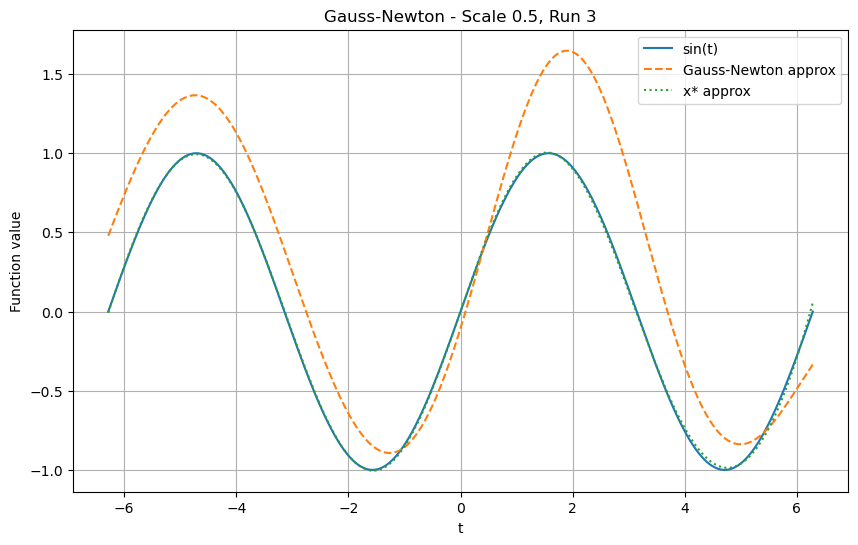


Running Hybrid GN-BFGS...
Starting Hybrid GN-BFGS from initial point with norm: 102.6133
Iter 0: f(x) = 9.429434e+01, ||∇f(x)|| = 3.231652e+02
Iter 10: f(x) = 2.344168e-01, ||∇f(x)|| = 5.182317e-01
Iter 20: f(x) = 1.124810e-02, ||∇f(x)|| = 6.767139e-01
Iter 30: f(x) = 9.320276e-03, ||∇f(x)|| = 1.445108e-02
Iter 40: f(x) = 8.334592e-03, ||∇f(x)|| = 1.968667e-02
Iter 50: f(x) = 8.130992e-03, ||∇f(x)|| = 4.978716e-02
Iter 60: f(x) = 7.739598e-03, ||∇f(x)|| = 3.401701e-03
Iter 70: f(x) = 7.727411e-03, ||∇f(x)|| = 1.200308e-03
Iter 80: f(x) = 7.727248e-03, ||∇f(x)|| = 1.205047e-03
Iter 90: f(x) = 7.727085e-03, ||∇f(x)|| = 1.203622e-03
Iter 100: f(x) = 7.726923e-03, ||∇f(x)|| = 1.202185e-03
Iter 110: f(x) = 7.726760e-03, ||∇f(x)|| = 1.200749e-03
Iter 120: f(x) = 7.726598e-03, ||∇f(x)|| = 1.199314e-03
Iter 130: f(x) = 7.726437e-03, ||∇f(x)|| = 1.197879e-03
Iter 140: f(x) = 7.726275e-03, ||∇f(x)|| = 1.196446e-03
Iter 150: f(x) = 7.726114e-03, ||∇f(x)|| = 1.195014e-03
Iter 160: f(x) = 7.725953

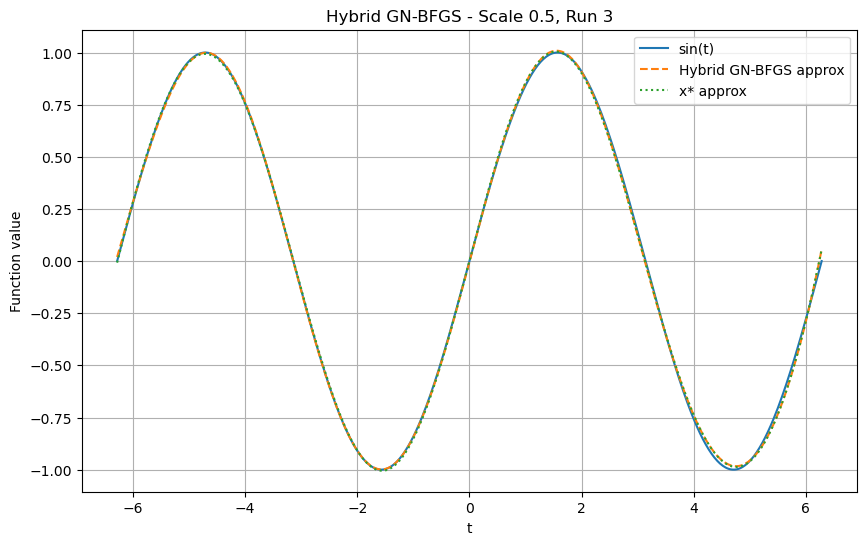


=== Scale 1.0 ===

--- Run 1/3 with scale 1.0 ---

Running Standard Newton...
Starting Standard Newton from initial point with norm: 101.7247
Iter 0: f(x) = 1.344495e+02, ||∇f(x)|| = 3.678335e+02
Standard Newton failed to converge. Final gradient norm: 8.558387
Runtime: 0.0723 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


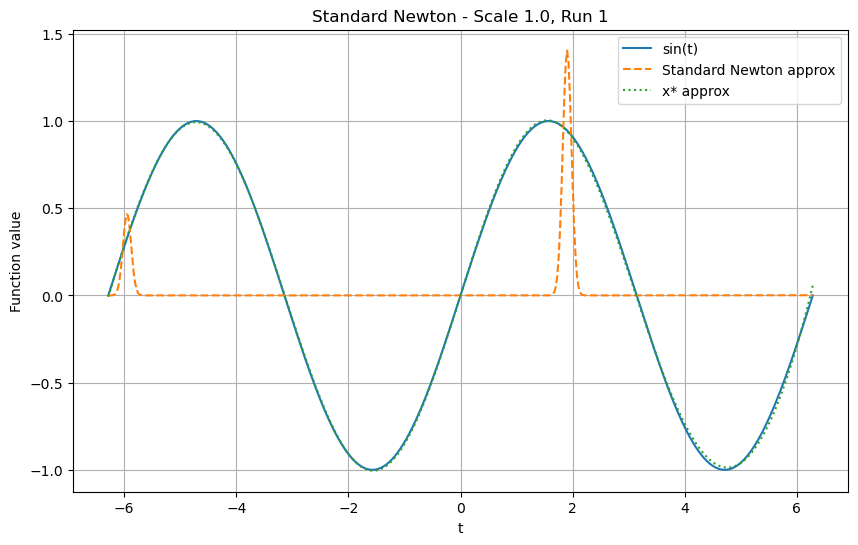


Running Newton with HM...
Starting NM-HM from initial point with norm: 101.7247
Iter 0: f(x) = 1.344495e+02, ||∇f(x)|| = 3.678335e+02
Iter 10: f(x) = 1.060822e-02, ||∇f(x)|| = 4.740103e-01
Iter 20: f(x) = 8.207011e-03, ||∇f(x)|| = 1.601078e-02
Iter 30: f(x) = 8.057144e-03, ||∇f(x)|| = 1.496127e-02
Iter 40: f(x) = 7.757492e-03, ||∇f(x)|| = 2.018724e-03
Iter 50: f(x) = 7.576399e-03, ||∇f(x)|| = 2.880996e-04
Converged in 55 iterations.
Final f(x) = 7.569868e-03, ||∇f(x)|| = 6.736370e-05
Newton with HM converged to a different local minimizer. Distance to x*: 7.027707
Runtime: 0.3811 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


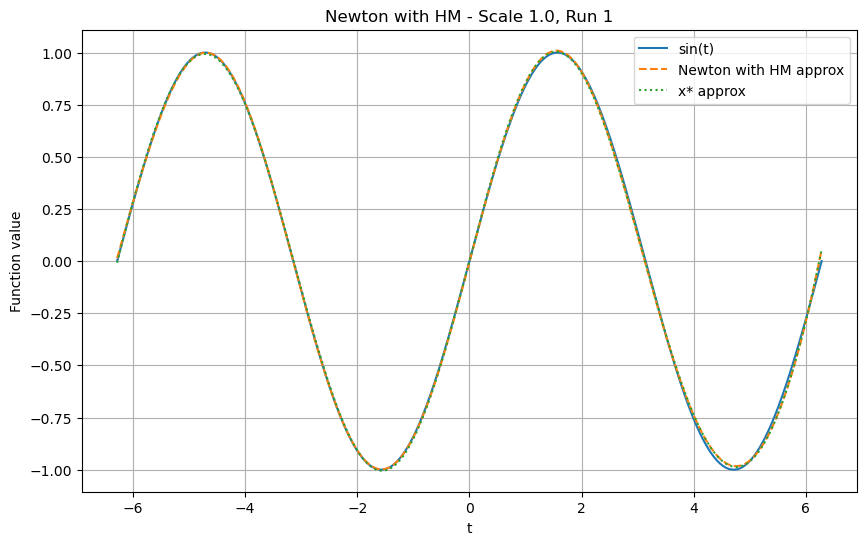


Running Gauss-Newton...
Starting GNM from initial point with norm: 101.7247
Iter 0: f(x) = 1.344495e+02, ||∇f(x)|| = 3.678335e+02
Iter 10: f(x) = 1.344481e+02, ||∇f(x)|| = 3.678918e+02
Iter 20: f(x) = 1.344468e+02, ||∇f(x)|| = 3.679493e+02
Iter 30: f(x) = 1.344459e+02, ||∇f(x)|| = 3.680064e+02
Iter 40: f(x) = 1.344451e+02, ||∇f(x)|| = 3.680631e+02
Iter 50: f(x) = 1.344447e+02, ||∇f(x)|| = 3.681198e+02
Iter 60: f(x) = 1.344445e+02, ||∇f(x)|| = 3.681735e+02
Iter 70: f(x) = 1.344432e+02, ||∇f(x)|| = 3.681997e+02
Iter 80: f(x) = 1.344420e+02, ||∇f(x)|| = 3.682260e+02
Iter 90: f(x) = 1.344409e+02, ||∇f(x)|| = 3.682524e+02
Iter 100: f(x) = 1.344398e+02, ||∇f(x)|| = 3.682789e+02
Iter 110: f(x) = 1.344387e+02, ||∇f(x)|| = 3.683056e+02
Iter 120: f(x) = 1.344377e+02, ||∇f(x)|| = 3.683326e+02
Iter 130: f(x) = 1.344368e+02, ||∇f(x)|| = 3.683598e+02
Iter 140: f(x) = 1.344359e+02, ||∇f(x)|| = 3.683873e+02
Iter 150: f(x) = 1.344351e+02, ||∇f(x)|| = 3.684151e+02
Iter 160: f(x) = 1.344343e+02, ||∇f(x)

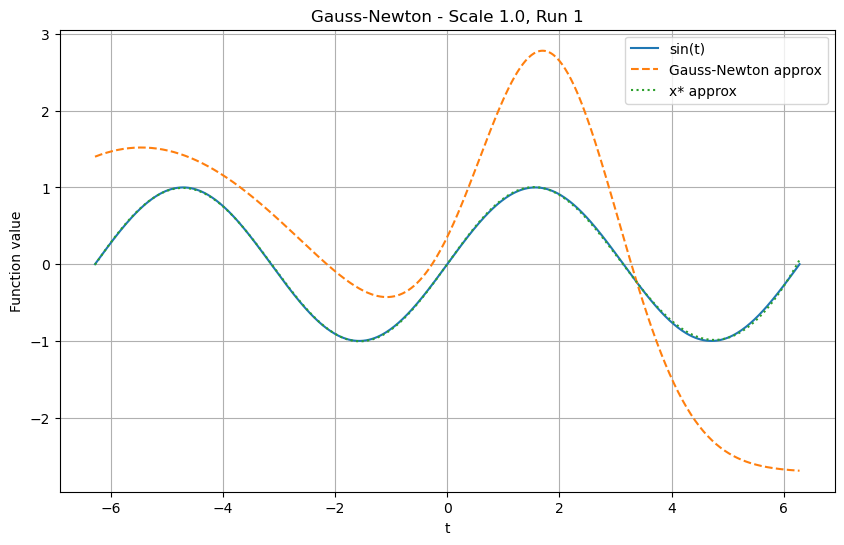


Running Hybrid GN-BFGS...
Starting Hybrid GN-BFGS from initial point with norm: 101.7247
Iter 0: f(x) = 1.344495e+02, ||∇f(x)|| = 3.678335e+02
Iter 10: f(x) = 2.122176e+01, ||∇f(x)|| = 1.006311e-01
Iter 20: f(x) = 2.117541e+01, ||∇f(x)|| = 1.004546e-01
Iter 30: f(x) = 2.111194e+01, ||∇f(x)|| = 1.878046e-02
Iter 40: f(x) = 2.110968e+01, ||∇f(x)|| = 4.880503e-03
Iter 50: f(x) = 2.110965e+01, ||∇f(x)|| = 1.000273e-03
Hybrid GN-BFGS failed to converge. Final gradient norm: 0.000103
Runtime: 0.2993 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


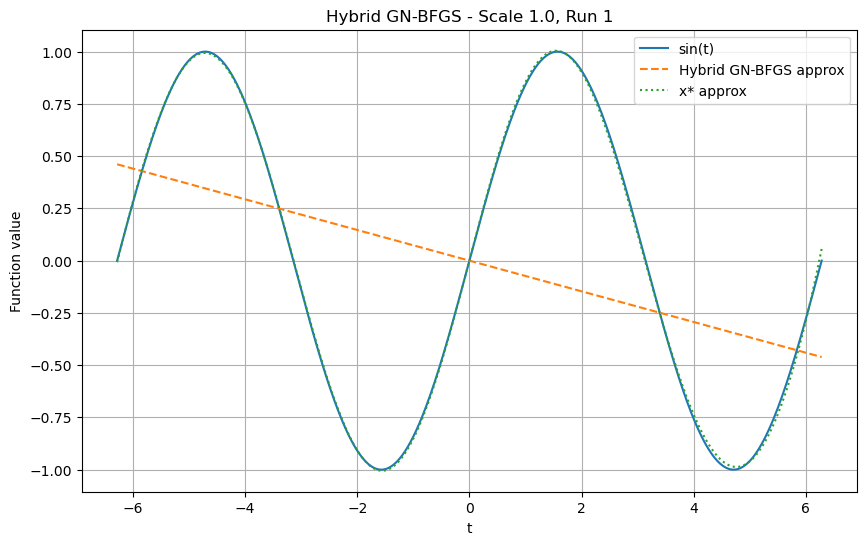


--- Run 2/3 with scale 1.0 ---

Running Standard Newton...
Starting Standard Newton from initial point with norm: 101.1872
Iter 0: f(x) = 1.517074e+02, ||∇f(x)|| = 1.873350e+02
Standard Newton failed to converge. Final gradient norm: 11.817901
Runtime: 0.0521 seconds
Convergence rates: Linear=3, Superlinear=0, Quadratic=0


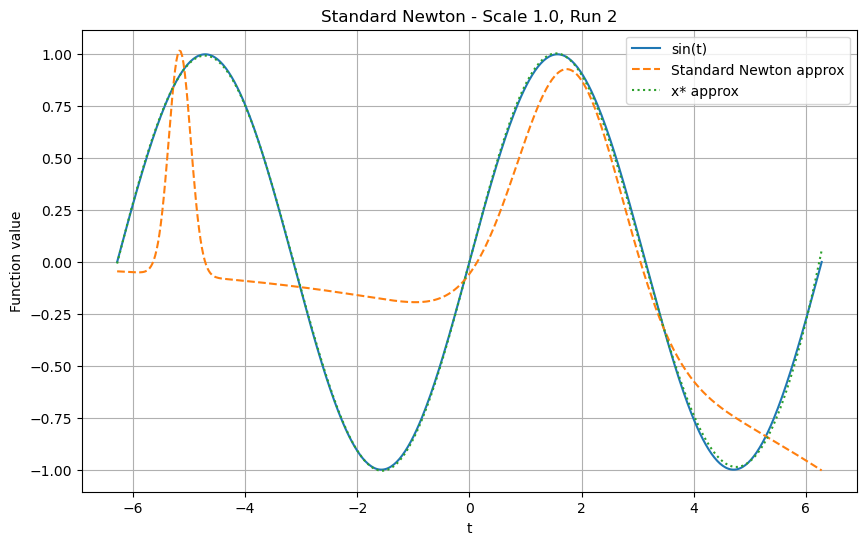


Running Newton with HM...
Starting NM-HM from initial point with norm: 101.1872
Iter 0: f(x) = 1.517074e+02, ||∇f(x)|| = 1.873350e+02
Iter 10: f(x) = 8.350453e-03, ||∇f(x)|| = 6.725915e-02
Iter 20: f(x) = 7.919759e-03, ||∇f(x)|| = 4.656601e-02
Iter 30: f(x) = 7.680778e-03, ||∇f(x)|| = 9.016458e-03
Iter 40: f(x) = 7.575583e-03, ||∇f(x)|| = 3.096355e-02
Iter 50: f(x) = 7.563560e-03, ||∇f(x)|| = 2.217612e-04
Converged in 55 iterations.
Final f(x) = 7.560717e-03, ||∇f(x)|| = 9.246850e-05
Newton with HM converged to a different local minimizer. Distance to x*: 8.624702
Runtime: 0.3380 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


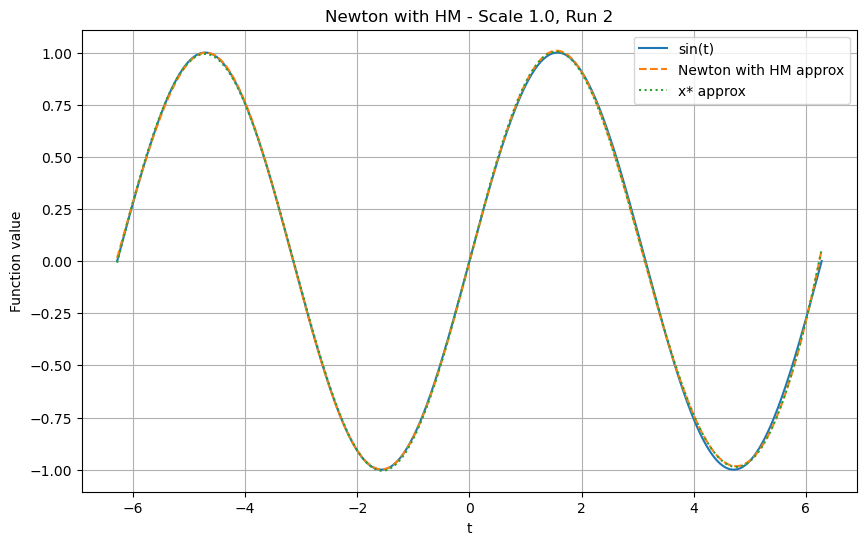


Running Gauss-Newton...
Starting GNM from initial point with norm: 101.1872
Iter 0: f(x) = 1.517074e+02, ||∇f(x)|| = 1.873350e+02
Iter 10: f(x) = 1.109189e+02, ||∇f(x)|| = 9.739551e+01
Iter 20: f(x) = 1.108871e+02, ||∇f(x)|| = 9.736055e+01
Iter 30: f(x) = 1.108354e+02, ||∇f(x)|| = 9.735211e+01
Iter 40: f(x) = 1.107933e+02, ||∇f(x)|| = 9.736037e+01
Iter 50: f(x) = 1.107017e+02, ||∇f(x)|| = 9.744080e+01
Iter 60: f(x) = 1.105933e+02, ||∇f(x)|| = 9.771334e+01
Iter 70: f(x) = 1.103763e+02, ||∇f(x)|| = 9.860219e+01
Iter 80: f(x) = 1.098675e+02, ||∇f(x)|| = 1.024265e+02
Iter 90: f(x) = 1.096436e+02, ||∇f(x)|| = 1.046266e+02
Iter 100: f(x) = 1.096436e+02, ||∇f(x)|| = 1.046188e+02
Iter 110: f(x) = 1.096436e+02, ||∇f(x)|| = 1.046109e+02
Iter 120: f(x) = 1.096436e+02, ||∇f(x)|| = 1.046030e+02
Iter 130: f(x) = 1.096436e+02, ||∇f(x)|| = 1.045951e+02
Iter 140: f(x) = 1.096436e+02, ||∇f(x)|| = 1.045873e+02
Iter 150: f(x) = 1.096436e+02, ||∇f(x)|| = 1.045794e+02
Iter 160: f(x) = 1.096436e+02, ||∇f(x)

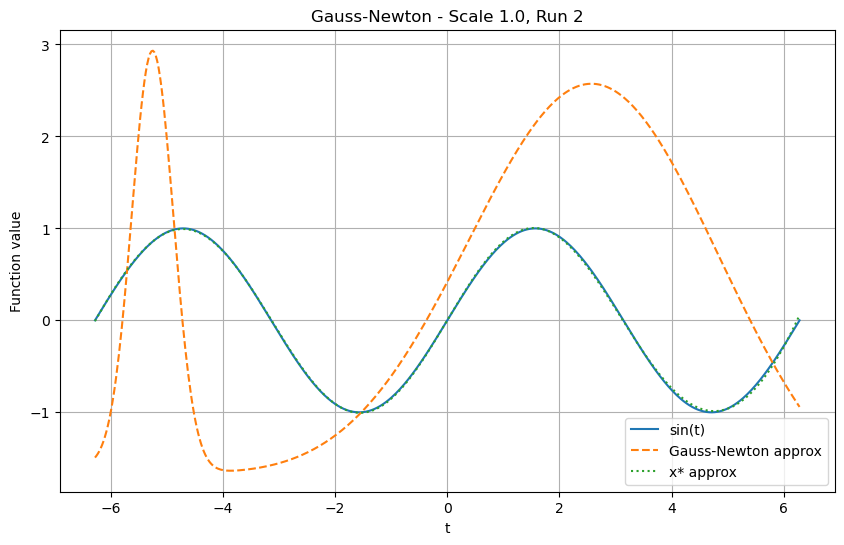


Running Hybrid GN-BFGS...
Starting Hybrid GN-BFGS from initial point with norm: 101.1872
Iter 0: f(x) = 1.517074e+02, ||∇f(x)|| = 1.873350e+02
Iter 10: f(x) = 1.417367e-01, ||∇f(x)|| = 3.677180e-01
Iter 20: f(x) = 8.968348e-03, ||∇f(x)|| = 2.252356e-01
Iter 30: f(x) = 8.607001e-03, ||∇f(x)|| = 1.275330e-01
Iter 40: f(x) = 8.077185e-03, ||∇f(x)|| = 1.206374e-02
Iter 50: f(x) = 7.730608e-03, ||∇f(x)|| = 2.683881e-02
Iter 60: f(x) = 7.671113e-03, ||∇f(x)|| = 4.688668e-05
Converged in 60 iterations.
Final f(x) = 7.671113e-03, ||∇f(x)|| = 4.688668e-05
Hybrid GN-BFGS converged to a different local minimizer. Distance to x*: 5.271814
Runtime: 0.2543 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


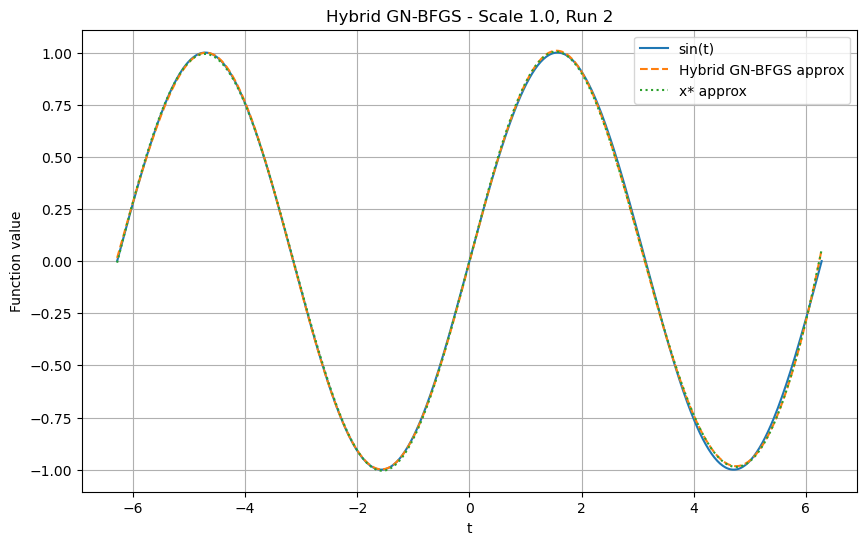


--- Run 3/3 with scale 1.0 ---

Running Standard Newton...
Starting Standard Newton from initial point with norm: 103.0697
Iter 0: f(x) = 5.424908e+02, ||∇f(x)|| = 4.924039e+02
Standard Newton failed to converge. Final gradient norm: 7.797576
Runtime: 0.0728 seconds
Convergence rates: Linear=3, Superlinear=0, Quadratic=0


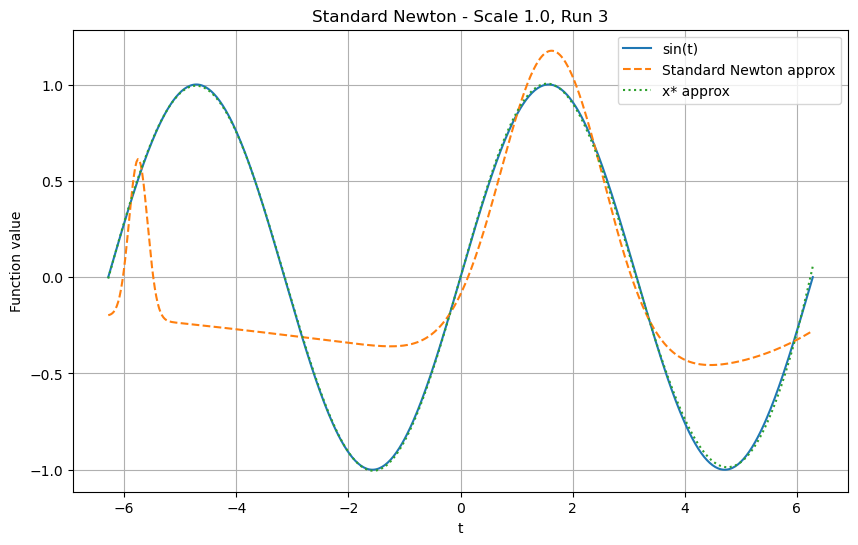


Running Newton with HM...
Starting NM-HM from initial point with norm: 103.0697
Iter 0: f(x) = 5.424908e+02, ||∇f(x)|| = 4.924039e+02
Iter 10: f(x) = 8.214390e-03, ||∇f(x)|| = 1.068735e-02
Iter 20: f(x) = 8.126899e-03, ||∇f(x)|| = 1.107492e-02
Iter 30: f(x) = 7.923924e-03, ||∇f(x)|| = 1.733876e-02
Iter 40: f(x) = 7.605280e-03, ||∇f(x)|| = 7.443081e-03
Iter 50: f(x) = 7.541361e-03, ||∇f(x)|| = 2.149205e-04
Iter 60: f(x) = 7.538222e-03, ||∇f(x)|| = 1.624225e-04
Iter 70: f(x) = 7.535402e-03, ||∇f(x)|| = 1.042708e-04
Converged in 72 iterations.
Final f(x) = 7.534860e-03, ||∇f(x)|| = 9.611635e-05
Newton with HM converged to a different local minimizer. Distance to x*: 8.466245
Runtime: 0.3621 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


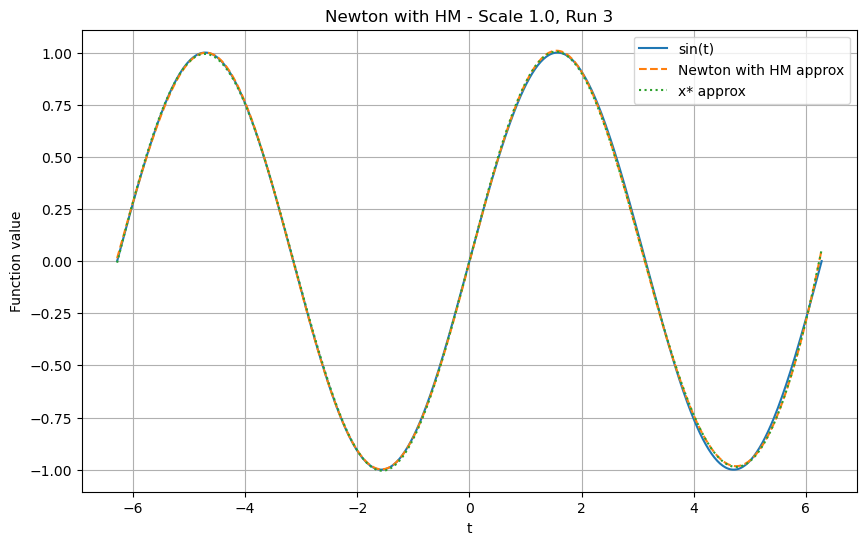


Running Gauss-Newton...
Starting GNM from initial point with norm: 103.0697
Iter 0: f(x) = 5.424908e+02, ||∇f(x)|| = 4.924039e+02
Iter 10: f(x) = 1.271041e+01, ||∇f(x)|| = 4.222095e-03
Converged in 17 iterations.
Final f(x) = 1.271041e+01, ||∇f(x)|| = 2.987493e-05
Gauss-Newton converged to a different local minimizer. Distance to x*: 10214.701193
Runtime: 0.0508 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


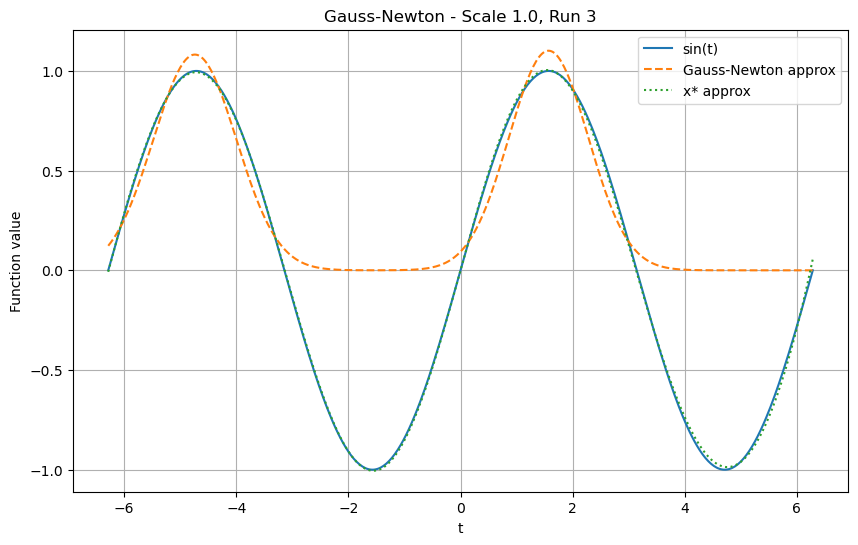


Running Hybrid GN-BFGS...
Starting Hybrid GN-BFGS from initial point with norm: 103.0697
Iter 0: f(x) = 5.424908e+02, ||∇f(x)|| = 4.924039e+02
Iter 10: f(x) = 9.962038e-03, ||∇f(x)|| = 6.611981e-01
Iter 20: f(x) = 8.207694e-03, ||∇f(x)|| = 4.555676e-03
Iter 30: f(x) = 8.126754e-03, ||∇f(x)|| = 9.133411e-02
Iter 40: f(x) = 7.901632e-03, ||∇f(x)|| = 5.459236e-02
Iter 50: f(x) = 7.703453e-03, ||∇f(x)|| = 5.063258e-03
Iter 60: f(x) = 7.702792e-03, ||∇f(x)|| = 1.069025e-03
Iter 70: f(x) = 7.702719e-03, ||∇f(x)|| = 1.068833e-03
Iter 80: f(x) = 7.702645e-03, ||∇f(x)|| = 1.068628e-03
Iter 90: f(x) = 7.702572e-03, ||∇f(x)|| = 1.068422e-03
Iter 100: f(x) = 7.702499e-03, ||∇f(x)|| = 1.068216e-03
Iter 110: f(x) = 7.702426e-03, ||∇f(x)|| = 1.068010e-03
Iter 120: f(x) = 7.702353e-03, ||∇f(x)|| = 1.067803e-03
Iter 130: f(x) = 7.702280e-03, ||∇f(x)|| = 1.067597e-03
Iter 140: f(x) = 7.702207e-03, ||∇f(x)|| = 1.067390e-03
Iter 150: f(x) = 7.702134e-03, ||∇f(x)|| = 1.067184e-03
Iter 160: f(x) = 7.702061

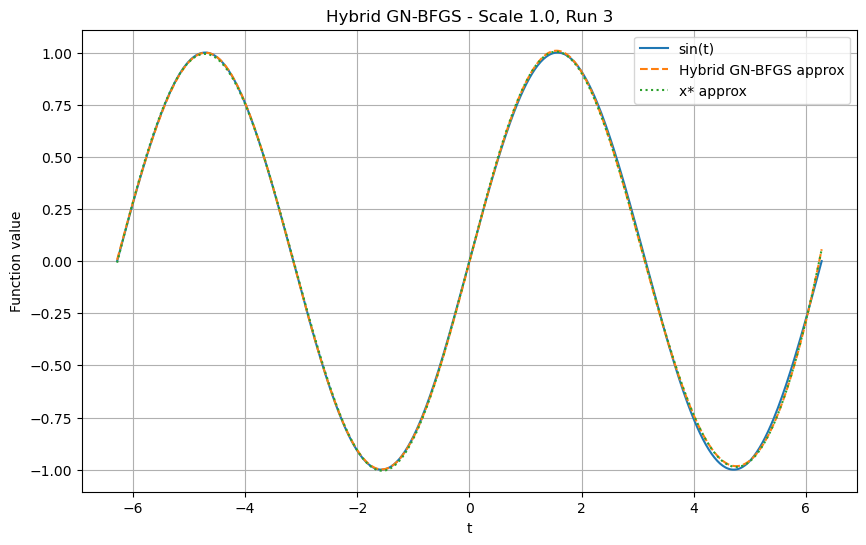


=== Scale 2.0 ===

--- Run 1/3 with scale 2.0 ---

Running Standard Newton...
Starting Standard Newton from initial point with norm: 100.4220
Iter 0: f(x) = 2.724598e+02, ||∇f(x)|| = 2.486181e+02
Error: Hessian is singular or ill-conditioned. Standard Newton failed.
Standard Newton failed to converge. Final gradient norm: 32.737792
Runtime: 0.0291 seconds
Convergence rates: Linear=3, Superlinear=0, Quadratic=0


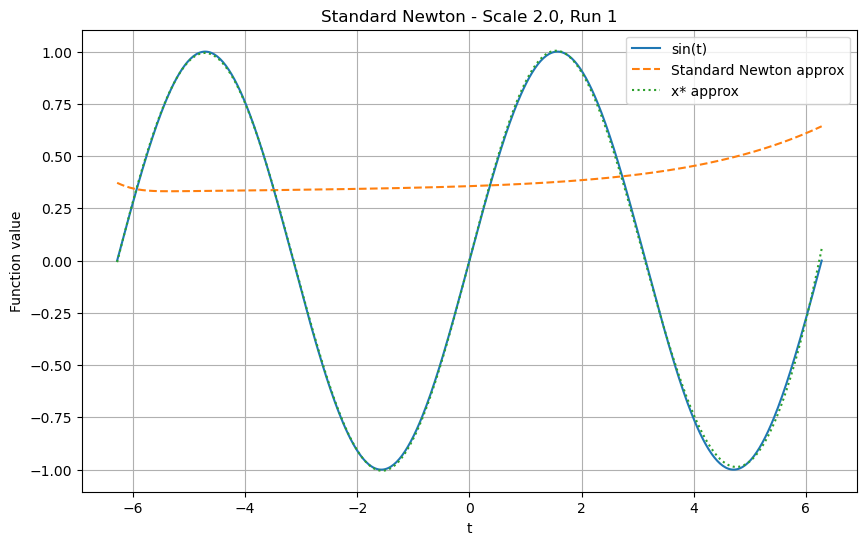


Running Newton with HM...
Starting NM-HM from initial point with norm: 100.4220
Iter 0: f(x) = 2.724598e+02, ||∇f(x)|| = 2.486181e+02
Iter 10: f(x) = 1.252391e-02, ||∇f(x)|| = 1.863020e-01
Iter 20: f(x) = 8.379930e-03, ||∇f(x)|| = 9.057571e-04
Iter 30: f(x) = 8.376383e-03, ||∇f(x)|| = 2.910681e-04
Iter 40: f(x) = 8.372850e-03, ||∇f(x)|| = 2.831230e-04
Iter 50: f(x) = 8.368696e-03, ||∇f(x)|| = 3.703427e-04
Iter 60: f(x) = 8.363683e-03, ||∇f(x)|| = 5.095519e-04
Iter 70: f(x) = 8.357493e-03, ||∇f(x)|| = 7.068019e-04
Iter 80: f(x) = 8.349644e-03, ||∇f(x)|| = 9.833742e-04
Iter 90: f(x) = 8.339371e-03, ||∇f(x)|| = 1.376020e-03
Iter 100: f(x) = 8.325385e-03, ||∇f(x)|| = 1.946585e-03
Iter 110: f(x) = 8.305335e-03, ||∇f(x)|| = 2.805153e-03
Iter 120: f(x) = 8.274432e-03, ||∇f(x)|| = 4.168231e-03
Iter 130: f(x) = 8.221275e-03, ||∇f(x)|| = 6.534154e-03
Iter 140: f(x) = 8.112409e-03, ||∇f(x)|| = 1.128617e-02
Iter 150: f(x) = 7.894789e-03, ||∇f(x)|| = 1.691568e-01
Iter 160: f(x) = 7.623033e-03, ||∇

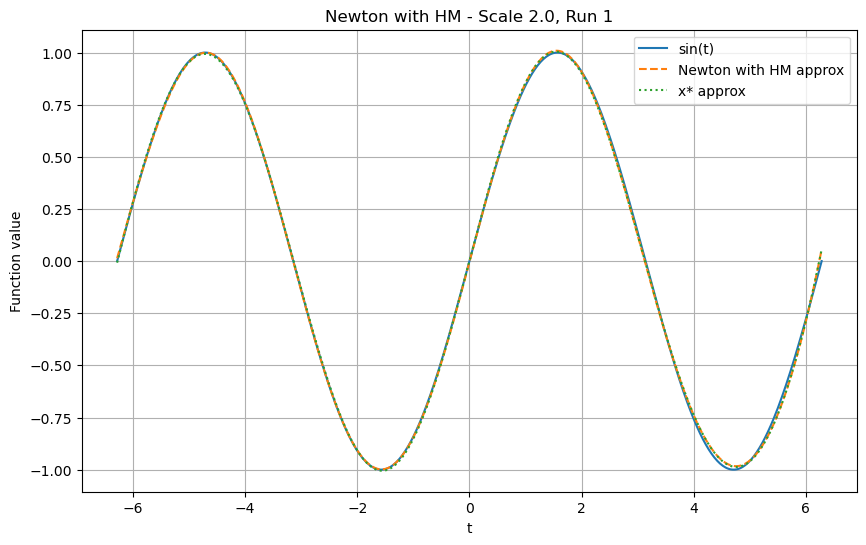


Running Gauss-Newton...
Starting GNM from initial point with norm: 100.4220
Iter 0: f(x) = 2.724598e+02, ||∇f(x)|| = 2.486181e+02
Iter 10: f(x) = 1.265114e+01, ||∇f(x)|| = 3.030035e-01
Iter 20: f(x) = 1.264837e+01, ||∇f(x)|| = 1.497617e-02
Iter 30: f(x) = 1.264836e+01, ||∇f(x)|| = 6.796724e-04
Converged in 37 iterations.
Final f(x) = 1.264836e+01, ||∇f(x)|| = 7.780277e-05
Gauss-Newton converged to a different local minimizer. Distance to x*: 2695628.825188
Runtime: 0.1212 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


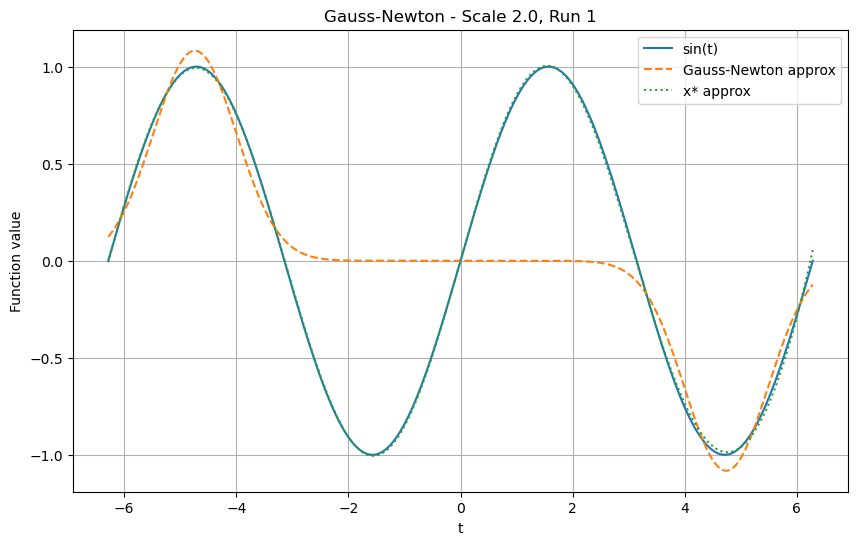


Running Hybrid GN-BFGS...
Starting Hybrid GN-BFGS from initial point with norm: 100.4220
Iter 0: f(x) = 2.724598e+02, ||∇f(x)|| = 2.486181e+02
Iter 10: f(x) = 1.710852e+01, ||∇f(x)|| = 2.626048e-01
Iter 20: f(x) = 1.707989e+01, ||∇f(x)|| = 8.063460e-01
Iter 30: f(x) = 1.706729e+01, ||∇f(x)|| = 5.771622e-03
Iter 40: f(x) = 1.706723e+01, ||∇f(x)|| = 4.206275e-06
Converged in 40 iterations.
Final f(x) = 1.706723e+01, ||∇f(x)|| = 4.206275e-06
Hybrid GN-BFGS converged to a different local minimizer. Distance to x*: 55046.418008
Runtime: 0.1586 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


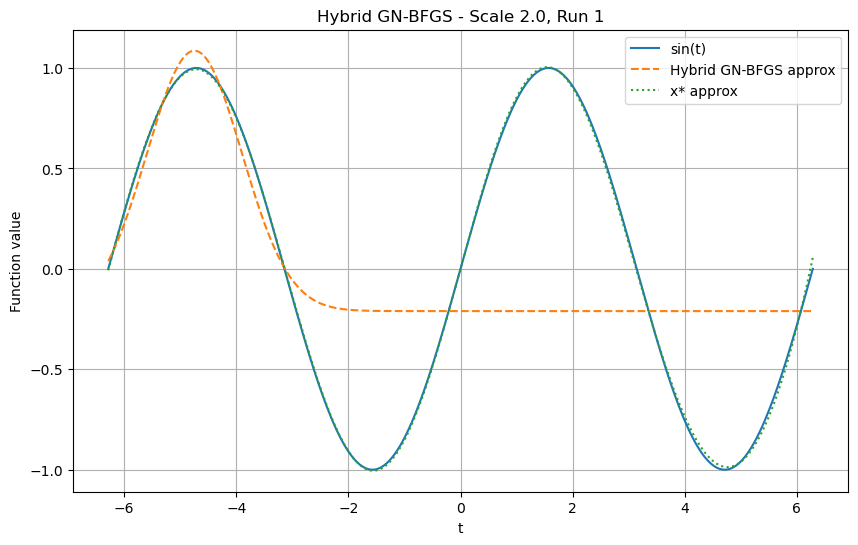


--- Run 2/3 with scale 2.0 ---

Running Standard Newton...
Starting Standard Newton from initial point with norm: 103.5586
Iter 0: f(x) = 6.727858e+02, ||∇f(x)|| = 9.461163e+02
Standard Newton failed to converge. Final gradient norm: 10.980379
Runtime: 0.0900 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


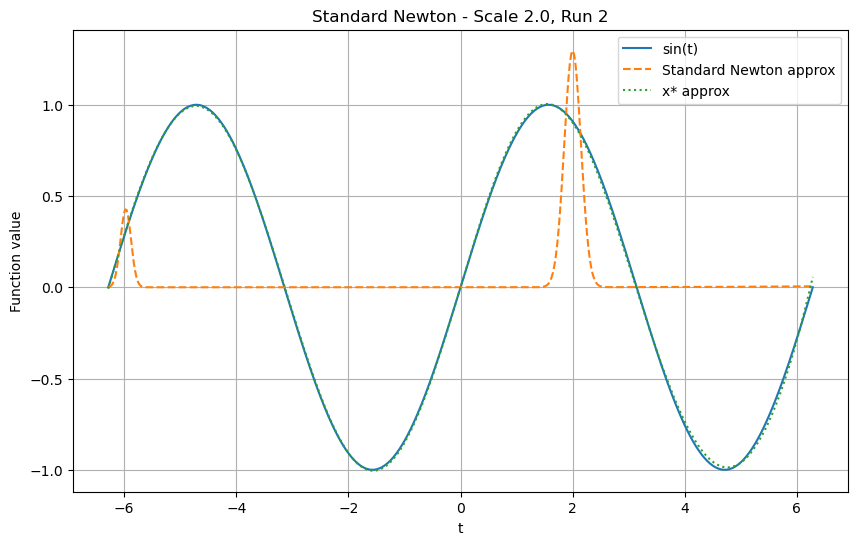


Running Newton with HM...
Starting NM-HM from initial point with norm: 103.5586
Iter 0: f(x) = 6.727858e+02, ||∇f(x)|| = 9.461163e+02
Iter 10: f(x) = 4.061120e+02, ||∇f(x)|| = 6.249385e+02
Iter 20: f(x) = 2.827097e+02, ||∇f(x)|| = 4.503652e+02
Iter 30: f(x) = 2.105128e+02, ||∇f(x)|| = 3.332100e+02
Iter 40: f(x) = 1.630448e+02, ||∇f(x)|| = 2.453129e+02
Iter 50: f(x) = 1.293106e+02, ||∇f(x)|| = 1.739436e+02
Iter 60: f(x) = 1.033280e+02, ||∇f(x)|| = 1.119180e+02
Iter 70: f(x) = 7.891560e+01, ||∇f(x)|| = 6.378680e+01
Iter 80: f(x) = 3.288859e-01, ||∇f(x)|| = 5.237326e+00
Iter 90: f(x) = 8.578152e-03, ||∇f(x)|| = 5.684921e-02
Iter 100: f(x) = 8.340874e-03, ||∇f(x)|| = 1.239891e-02
Iter 110: f(x) = 8.321860e-03, ||∇f(x)|| = 7.379386e-04
Converged in 119 iterations.
Final f(x) = 8.320625e-03, ||∇f(x)|| = 8.436869e-05
Newton with HM converged to a different local minimizer. Distance to x*: 14.695581
Runtime: 0.7227 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


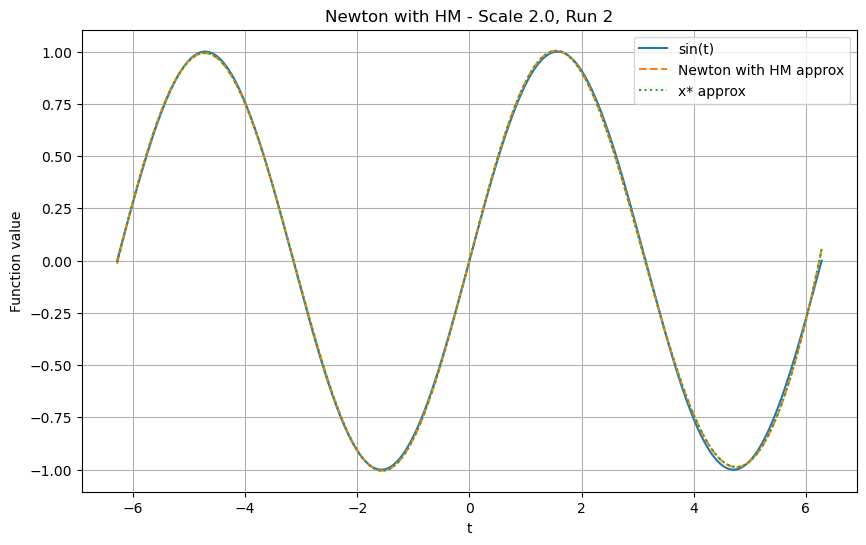


Running Gauss-Newton...
Starting GNM from initial point with norm: 103.5586
Iter 0: f(x) = 6.727858e+02, ||∇f(x)|| = 9.461163e+02
Iter 10: f(x) = 6.727843e+02, ||∇f(x)|| = 9.464749e+02
Iter 20: f(x) = 6.727831e+02, ||∇f(x)|| = 9.468370e+02
Iter 30: f(x) = 6.727821e+02, ||∇f(x)|| = 9.472027e+02
Iter 40: f(x) = 6.727813e+02, ||∇f(x)|| = 9.475723e+02
Iter 50: f(x) = 6.727808e+02, ||∇f(x)|| = 9.479460e+02
Iter 60: f(x) = 6.727807e+02, ||∇f(x)|| = 9.483241e+02
Iter 70: f(x) = 6.727792e+02, ||∇f(x)|| = 9.485326e+02
Iter 80: f(x) = 6.727777e+02, ||∇f(x)|| = 9.487232e+02
Iter 90: f(x) = 6.727762e+02, ||∇f(x)|| = 9.489149e+02
Iter 100: f(x) = 6.727747e+02, ||∇f(x)|| = 9.491079e+02
Iter 110: f(x) = 6.727733e+02, ||∇f(x)|| = 9.493021e+02
Iter 120: f(x) = 6.727720e+02, ||∇f(x)|| = 9.494976e+02
Iter 130: f(x) = 6.727707e+02, ||∇f(x)|| = 9.496945e+02
Iter 140: f(x) = 6.727694e+02, ||∇f(x)|| = 9.498928e+02
Iter 150: f(x) = 6.727682e+02, ||∇f(x)|| = 9.500925e+02
Iter 160: f(x) = 6.727670e+02, ||∇f(x)

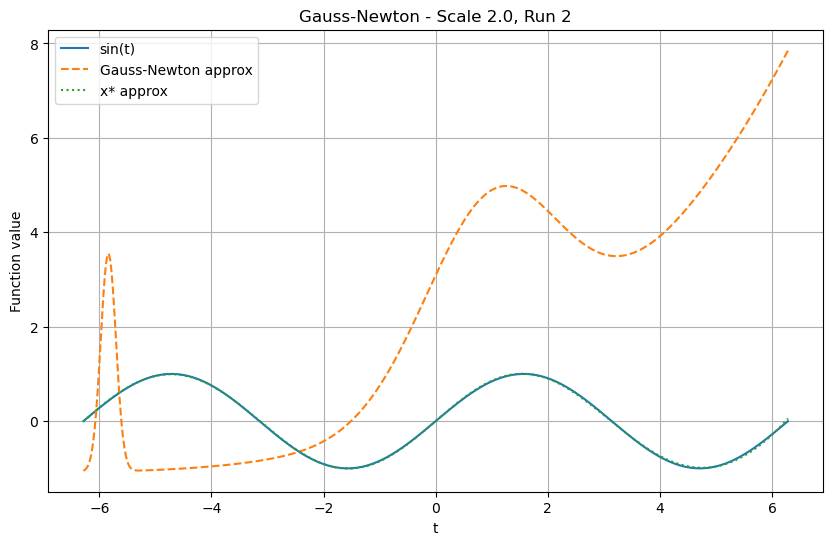


Running Hybrid GN-BFGS...
Starting Hybrid GN-BFGS from initial point with norm: 103.5586
Iter 0: f(x) = 6.727858e+02, ||∇f(x)|| = 9.461163e+02
Iter 10: f(x) = 1.818027e+00, ||∇f(x)|| = 1.755222e+00
Iter 20: f(x) = 2.976019e-01, ||∇f(x)|| = 2.482980e+00
Iter 30: f(x) = 1.759775e-01, ||∇f(x)|| = 1.391415e+00
Iter 40: f(x) = 1.111218e-01, ||∇f(x)|| = 4.382274e-01
Iter 50: f(x) = 5.630047e-02, ||∇f(x)|| = 1.292255e+00
Iter 60: f(x) = 4.028836e-02, ||∇f(x)|| = 1.174557e+00
Iter 70: f(x) = 3.816256e-02, ||∇f(x)|| = 1.515978e-02
Iter 80: f(x) = 3.642082e-02, ||∇f(x)|| = 2.620125e-01
Iter 90: f(x) = 3.326209e-02, ||∇f(x)|| = 2.690422e-01
Iter 100: f(x) = 3.130278e-02, ||∇f(x)|| = 3.147992e-01
Iter 110: f(x) = 2.867043e-02, ||∇f(x)|| = 3.531703e-01
Iter 120: f(x) = 2.169972e-02, ||∇f(x)|| = 3.975654e-01
Iter 130: f(x) = 1.242607e-02, ||∇f(x)|| = 4.538421e-02
Iter 140: f(x) = 1.121937e-02, ||∇f(x)|| = 8.077010e-02
Iter 150: f(x) = 9.446865e-03, ||∇f(x)|| = 8.200936e-02
Iter 160: f(x) = 8.915269

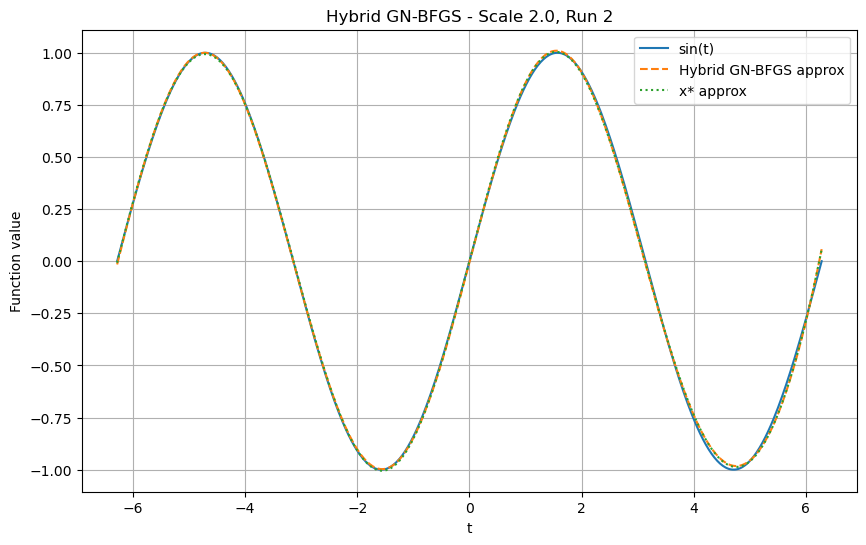


--- Run 3/3 with scale 2.0 ---

Running Standard Newton...
Starting Standard Newton from initial point with norm: 103.0536
Iter 0: f(x) = 1.215591e+03, ||∇f(x)|| = 1.534455e+03
Error: Hessian is singular or ill-conditioned. Standard Newton failed.
Standard Newton failed to converge. Final gradient norm: 50.419160
Runtime: 0.0242 seconds
Convergence rates: Linear=3, Superlinear=0, Quadratic=0


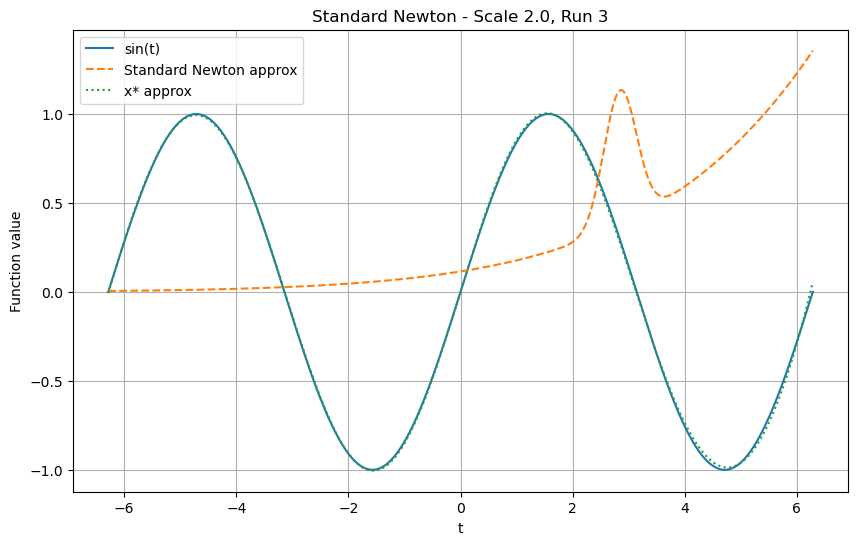


Running Newton with HM...
Starting NM-HM from initial point with norm: 103.0536
Iter 0: f(x) = 1.215591e+03, ||∇f(x)|| = 1.534455e+03
Iter 10: f(x) = 5.136323e-02, ||∇f(x)|| = 4.521232e+00
Iter 20: f(x) = 8.128444e-03, ||∇f(x)|| = 9.421332e-03
Iter 30: f(x) = 7.877765e-03, ||∇f(x)|| = 1.986250e-02
Iter 40: f(x) = 7.614277e-03, ||∇f(x)|| = 1.552506e-03
Iter 50: f(x) = 7.603741e-03, ||∇f(x)|| = 5.117181e-04
Iter 60: f(x) = 7.599441e-03, ||∇f(x)|| = 3.250177e-04
Iter 70: f(x) = 7.595964e-03, ||∇f(x)|| = 1.925702e-04
Iter 80: f(x) = 7.592876e-03, ||∇f(x)|| = 1.209928e-04
Converged in 85 iterations.
Final f(x) = 7.591413e-03, ||∇f(x)|| = 9.861627e-05
Newton with HM converged to a different local minimizer. Distance to x*: 7.029335
Runtime: 0.4656 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


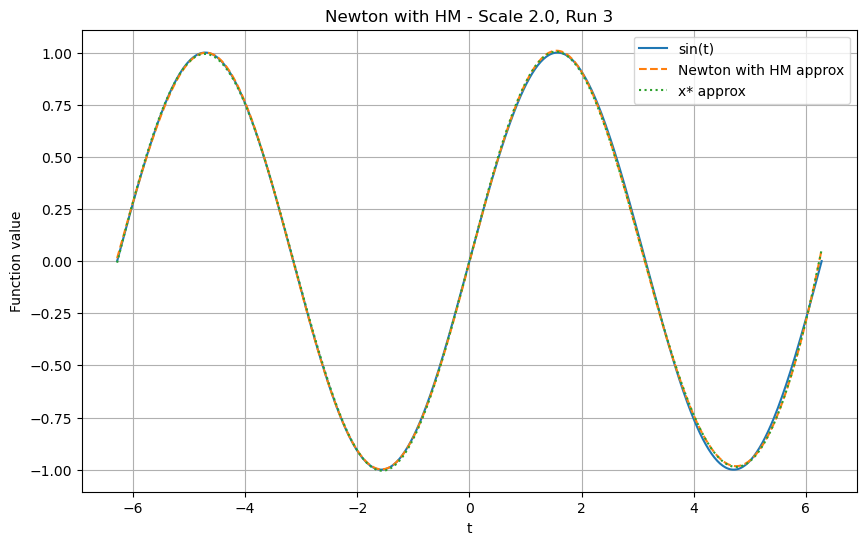


Running Gauss-Newton...
Starting GNM from initial point with norm: 103.0536
Iter 0: f(x) = 1.215591e+03, ||∇f(x)|| = 1.534455e+03
Iter 10: f(x) = 1.215583e+03, ||∇f(x)|| = 1.535793e+03
Iter 20: f(x) = 1.215575e+03, ||∇f(x)|| = 1.537148e+03
Iter 30: f(x) = 1.215568e+03, ||∇f(x)|| = 1.538519e+03
Iter 40: f(x) = 1.215561e+03, ||∇f(x)|| = 1.539907e+03
Iter 50: f(x) = 1.215556e+03, ||∇f(x)|| = 1.541313e+03
Iter 60: f(x) = 1.215552e+03, ||∇f(x)|| = 1.542737e+03
Iter 70: f(x) = 1.215550e+03, ||∇f(x)|| = 1.544179e+03
Iter 80: f(x) = 1.215548e+03, ||∇f(x)|| = 1.545642e+03
Iter 90: f(x) = 1.215544e+03, ||∇f(x)|| = 1.546597e+03
Iter 100: f(x) = 1.215539e+03, ||∇f(x)|| = 1.547334e+03
Iter 110: f(x) = 1.215533e+03, ||∇f(x)|| = 1.548075e+03
Iter 120: f(x) = 1.215528e+03, ||∇f(x)|| = 1.548822e+03
Iter 130: f(x) = 1.215524e+03, ||∇f(x)|| = 1.549574e+03
Iter 140: f(x) = 1.215519e+03, ||∇f(x)|| = 1.550331e+03
Iter 150: f(x) = 1.215515e+03, ||∇f(x)|| = 1.551093e+03
Iter 160: f(x) = 1.215511e+03, ||∇f(x)

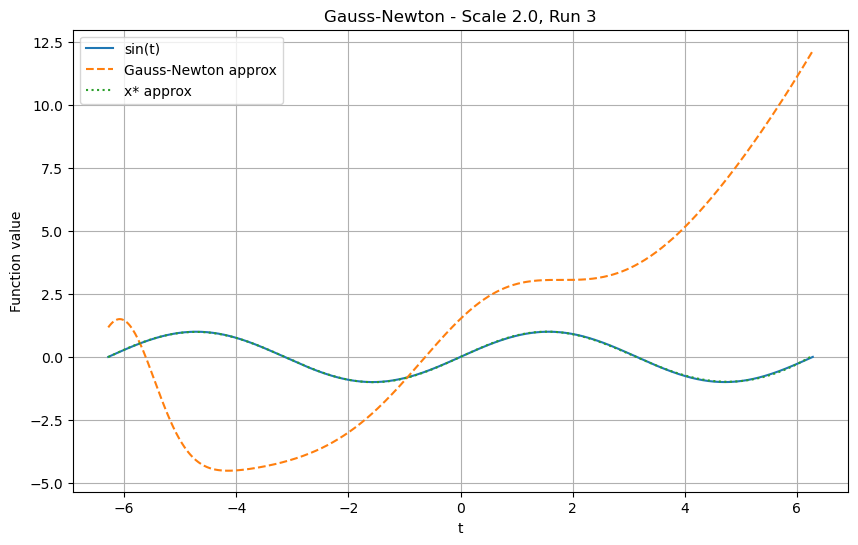


Running Hybrid GN-BFGS...
Starting Hybrid GN-BFGS from initial point with norm: 103.0536
Iter 0: f(x) = 1.215591e+03, ||∇f(x)|| = 1.534455e+03
Iter 10: f(x) = 1.180138e+00, ||∇f(x)|| = 3.793163e+00
Iter 20: f(x) = 1.397609e-01, ||∇f(x)|| = 1.057632e+00
Iter 30: f(x) = 8.557856e-02, ||∇f(x)|| = 5.278021e-01
Iter 40: f(x) = 7.207674e-02, ||∇f(x)|| = 4.077254e-01
Iter 50: f(x) = 6.171745e-02, ||∇f(x)|| = 1.028806e+00
Iter 60: f(x) = 5.380963e-02, ||∇f(x)|| = 7.833261e-02
Iter 70: f(x) = 4.893885e-02, ||∇f(x)|| = 4.671781e-01
Iter 80: f(x) = 4.522464e-02, ||∇f(x)|| = 1.949025e-01
Iter 90: f(x) = 4.295313e-02, ||∇f(x)|| = 1.678069e-01
Iter 100: f(x) = 4.195398e-02, ||∇f(x)|| = 1.572374e-01
Iter 110: f(x) = 4.183376e-02, ||∇f(x)|| = 1.093776e-02
Iter 120: f(x) = 4.038311e-02, ||∇f(x)|| = 2.494676e-01
Iter 130: f(x) = 3.466997e-02, ||∇f(x)|| = 3.043496e-01
Iter 140: f(x) = 2.946815e-02, ||∇f(x)|| = 1.515976e-01
Iter 150: f(x) = 2.538859e-02, ||∇f(x)|| = 3.033005e-01
Iter 160: f(x) = 2.331476

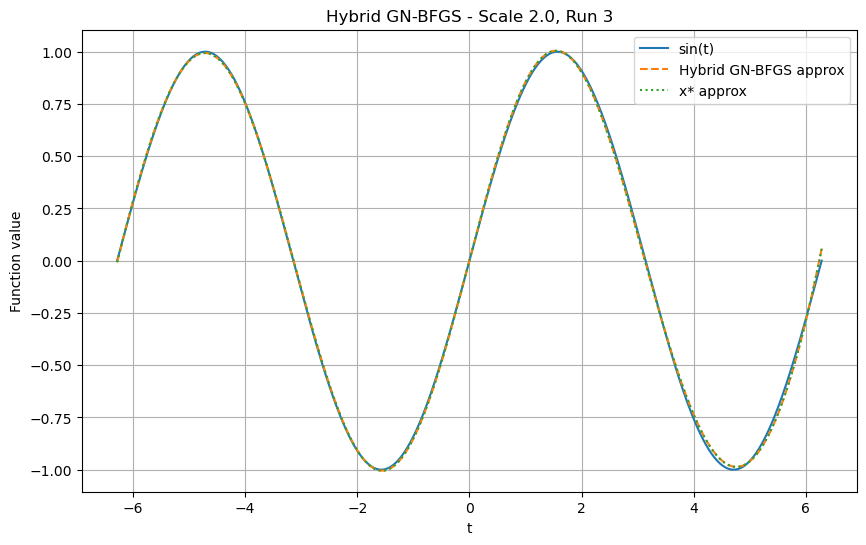


=== Scale 3.0 ===

--- Run 1/3 with scale 3.0 ---

Running Standard Newton...
Starting Standard Newton from initial point with norm: 100.3181
Iter 0: f(x) = 6.790896e+02, ||∇f(x)|| = 3.466300e+02
Standard Newton failed to converge. Final gradient norm: 1.543818
Runtime: 0.0694 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


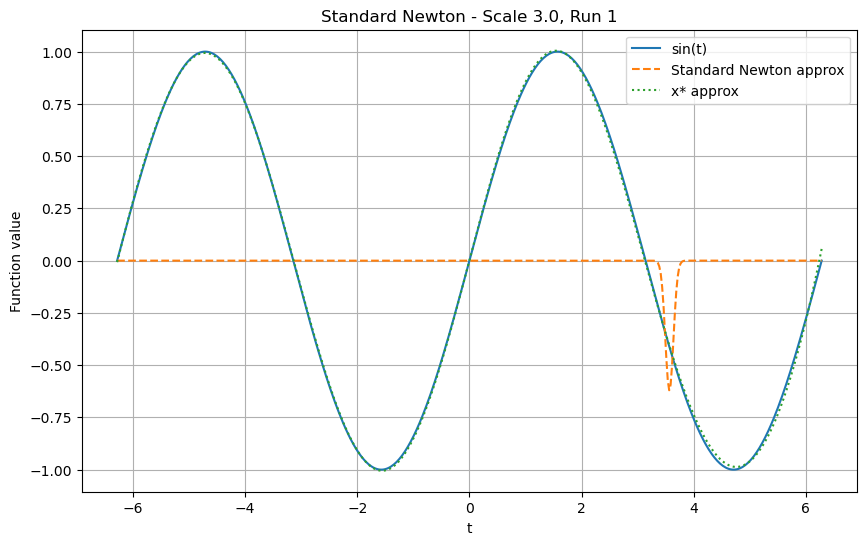


Running Newton with HM...
Starting NM-HM from initial point with norm: 100.3181
Iter 0: f(x) = 6.790896e+02, ||∇f(x)|| = 3.466300e+02
Iter 10: f(x) = 2.312874e+00, ||∇f(x)|| = 9.927154e+00
Iter 20: f(x) = 1.092093e-02, ||∇f(x)|| = 1.164552e+00
Iter 30: f(x) = 8.242943e-03, ||∇f(x)|| = 3.392949e-03
Iter 40: f(x) = 8.200366e-03, ||∇f(x)|| = 5.456833e-03
Iter 50: f(x) = 8.120711e-03, ||∇f(x)|| = 8.736418e-03
Iter 60: f(x) = 7.924380e-03, ||∇f(x)|| = 1.689578e-02
Iter 70: f(x) = 7.578643e-03, ||∇f(x)|| = 1.153205e-02
Converged in 76 iterations.
Final f(x) = 7.557681e-03, ||∇f(x)|| = 9.670082e-05
Newton with HM converged to a different local minimizer. Distance to x*: 7.412692
Runtime: 0.3831 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


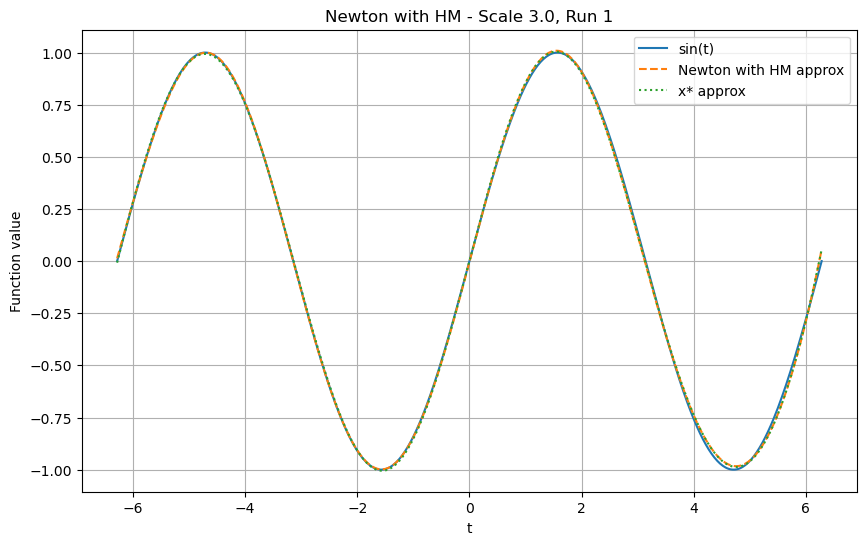


Running Gauss-Newton...
Starting GNM from initial point with norm: 100.3181
Iter 0: f(x) = 6.790896e+02, ||∇f(x)|| = 3.466300e+02
Converged in 3 iterations.
Final f(x) = 2.475000e+01, ||∇f(x)|| = 0.000000e+00
Gauss-Newton converged to a different local minimizer. Distance to x*: 28452.325618
Runtime: 0.0197 seconds
Convergence rates: Linear=2, Superlinear=0, Quadratic=0


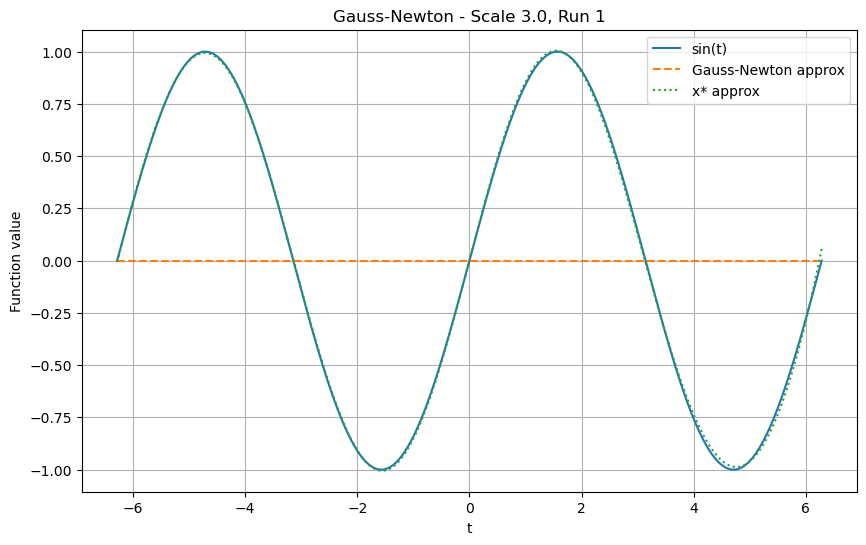


Running Hybrid GN-BFGS...
Starting Hybrid GN-BFGS from initial point with norm: 100.3181
Iter 0: f(x) = 6.790896e+02, ||∇f(x)|| = 3.466300e+02
Iter 10: f(x) = 1.262498e-02, ||∇f(x)|| = 1.202650e-01
Iter 20: f(x) = 9.427626e-03, ||∇f(x)|| = 6.066783e-03
Iter 30: f(x) = 8.535866e-03, ||∇f(x)|| = 7.523940e-02
Iter 40: f(x) = 8.164848e-03, ||∇f(x)|| = 2.787636e-02
Iter 50: f(x) = 7.916438e-03, ||∇f(x)|| = 6.498503e-02
Iter 60: f(x) = 7.741127e-03, ||∇f(x)|| = 2.285856e-03
Iter 70: f(x) = 7.646617e-03, ||∇f(x)|| = 4.573794e-02
Iter 80: f(x) = 7.603854e-03, ||∇f(x)|| = 1.174891e-02
Converged in 89 iterations.
Final f(x) = 7.599896e-03, ||∇f(x)|| = 8.584292e-05
Hybrid GN-BFGS converged to a different local minimizer. Distance to x*: 6.862852
Runtime: 0.3799 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


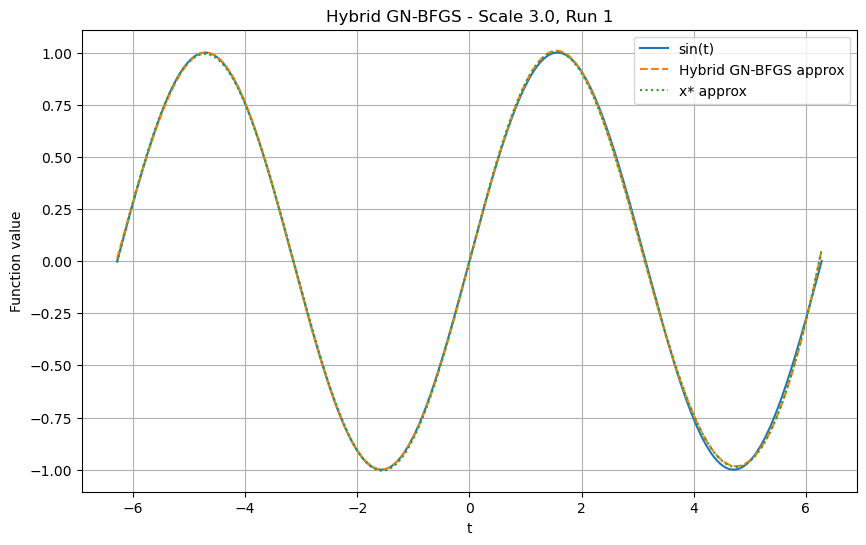


--- Run 2/3 with scale 3.0 ---

Running Standard Newton...
Starting Standard Newton from initial point with norm: 97.3600
Iter 0: f(x) = 5.813637e+02, ||∇f(x)|| = 9.364392e+02
Error: Hessian is singular or ill-conditioned. Standard Newton failed.
Standard Newton failed to converge. Final gradient norm: 78.091585
Runtime: 0.0171 seconds
Convergence rates: Linear=2, Superlinear=0, Quadratic=0


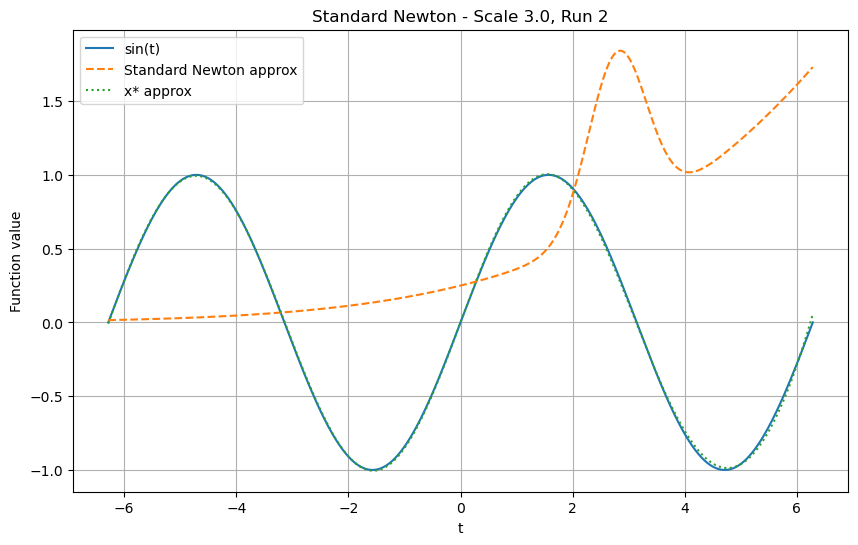


Running Newton with HM...
Starting NM-HM from initial point with norm: 97.3600
Iter 0: f(x) = 5.813637e+02, ||∇f(x)|| = 9.364392e+02
Iter 10: f(x) = 8.459328e-03, ||∇f(x)|| = 7.962724e-03
Iter 20: f(x) = 8.315397e-03, ||∇f(x)|| = 3.169663e-03
Iter 30: f(x) = 8.265585e-03, ||∇f(x)|| = 2.905673e-03
Iter 40: f(x) = 8.211737e-03, ||∇f(x)|| = 5.749438e-03
Iter 50: f(x) = 8.109041e-03, ||∇f(x)|| = 1.069693e-02
Iter 60: f(x) = 7.885037e-03, ||∇f(x)|| = 6.624819e-02
Iter 70: f(x) = 7.636318e-03, ||∇f(x)|| = 2.494178e-03
Iter 80: f(x) = 7.605957e-03, ||∇f(x)|| = 4.791660e-04
Iter 90: f(x) = 7.599375e-03, ||∇f(x)|| = 3.294699e-04
Iter 100: f(x) = 7.593652e-03, ||∇f(x)|| = 1.994741e-04
Iter 110: f(x) = 7.588341e-03, ||∇f(x)|| = 1.321727e-04
Converged in 119 iterations.
Final f(x) = 7.583772e-03, ||∇f(x)|| = 9.918807e-05
Newton with HM converged to a different local minimizer. Distance to x*: 10.841079
Runtime: 0.6919 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


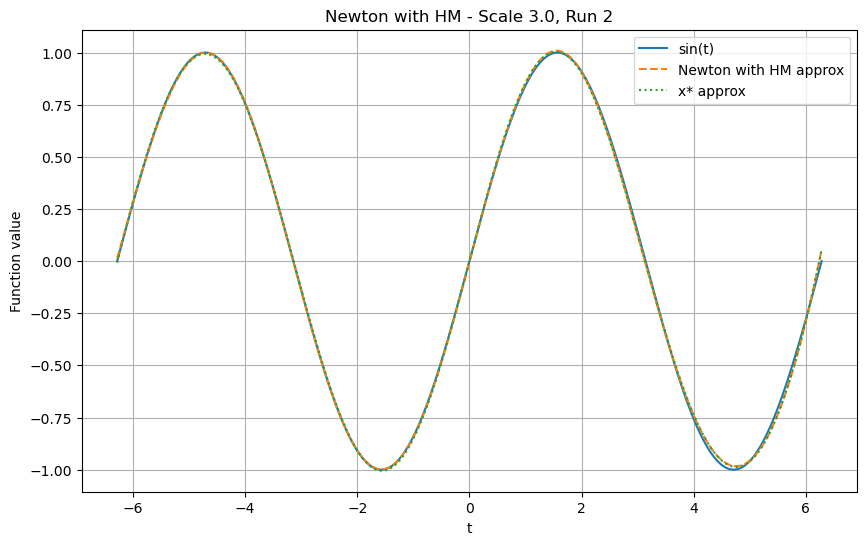


Running Gauss-Newton...
Starting GNM from initial point with norm: 97.3600
Iter 0: f(x) = 5.813637e+02, ||∇f(x)|| = 9.364392e+02
Iter 10: f(x) = 5.813319e+02, ||∇f(x)|| = 9.391625e+02
Iter 20: f(x) = 5.813082e+02, ||∇f(x)|| = 9.419904e+02
Iter 30: f(x) = 5.812942e+02, ||∇f(x)|| = 9.449327e+02
Iter 40: f(x) = 5.812828e+02, ||∇f(x)|| = 9.473626e+02
Iter 50: f(x) = 5.812624e+02, ||∇f(x)|| = 9.488962e+02
Iter 60: f(x) = 5.812440e+02, ||∇f(x)|| = 9.504631e+02
Iter 70: f(x) = 5.812280e+02, ||∇f(x)|| = 9.520646e+02
Iter 80: f(x) = 5.812146e+02, ||∇f(x)|| = 9.537029e+02
Iter 90: f(x) = 5.812044e+02, ||∇f(x)|| = 9.553812e+02
Iter 100: f(x) = 5.811977e+02, ||∇f(x)|| = 9.571016e+02
Iter 110: f(x) = 5.811952e+02, ||∇f(x)|| = 9.588673e+02
Iter 120: f(x) = 5.811844e+02, ||∇f(x)|| = 9.597486e+02
Iter 130: f(x) = 5.811742e+02, ||∇f(x)|| = 9.606411e+02
Iter 140: f(x) = 5.811648e+02, ||∇f(x)|| = 9.615456e+02
Iter 150: f(x) = 5.811561e+02, ||∇f(x)|| = 9.624622e+02
Iter 160: f(x) = 5.811482e+02, ||∇f(x)|

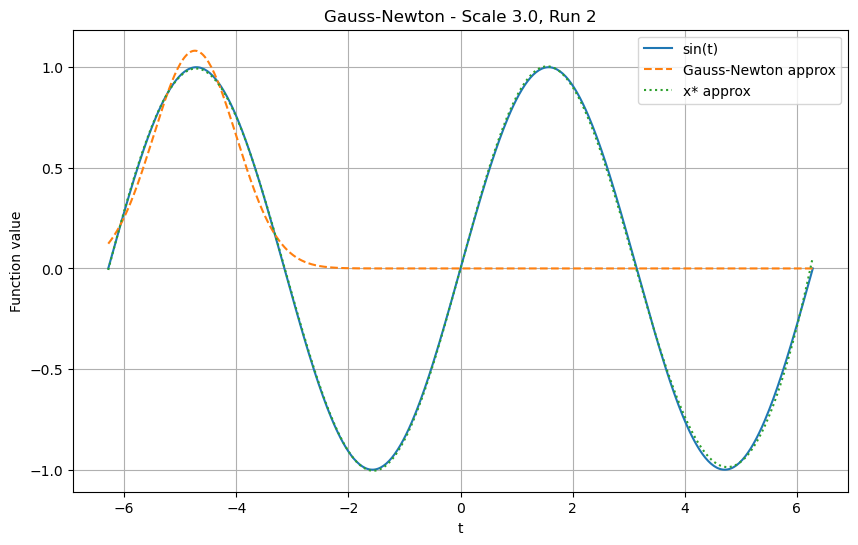


Running Hybrid GN-BFGS...
Starting Hybrid GN-BFGS from initial point with norm: 97.3600
Iter 0: f(x) = 5.813637e+02, ||∇f(x)|| = 9.364392e+02
Iter 10: f(x) = 4.116741e+00, ||∇f(x)|| = 2.196838e+00
Iter 20: f(x) = 1.686636e-01, ||∇f(x)|| = 3.351238e-01
Iter 30: f(x) = 2.513275e-02, ||∇f(x)|| = 1.557414e+00
Iter 40: f(x) = 1.661934e-02, ||∇f(x)|| = 2.027681e-02
Iter 50: f(x) = 1.322361e-02, ||∇f(x)|| = 4.507639e-01
Iter 60: f(x) = 1.101591e-02, ||∇f(x)|| = 2.608857e-01
Iter 70: f(x) = 8.544271e-03, ||∇f(x)|| = 2.424553e-02
Iter 80: f(x) = 8.389504e-03, ||∇f(x)|| = 4.332188e-02
Iter 90: f(x) = 8.380918e-03, ||∇f(x)|| = 1.815162e-04
Iter 100: f(x) = 8.380882e-03, ||∇f(x)|| = 1.329452e-04
Iter 110: f(x) = 8.380846e-03, ||∇f(x)|| = 1.329820e-04
Iter 120: f(x) = 8.380810e-03, ||∇f(x)|| = 1.330189e-04
Iter 130: f(x) = 8.380774e-03, ||∇f(x)|| = 1.330558e-04
Iter 140: f(x) = 8.380739e-03, ||∇f(x)|| = 1.330927e-04
Iter 150: f(x) = 8.380703e-03, ||∇f(x)|| = 1.331297e-04
Iter 160: f(x) = 8.380667e

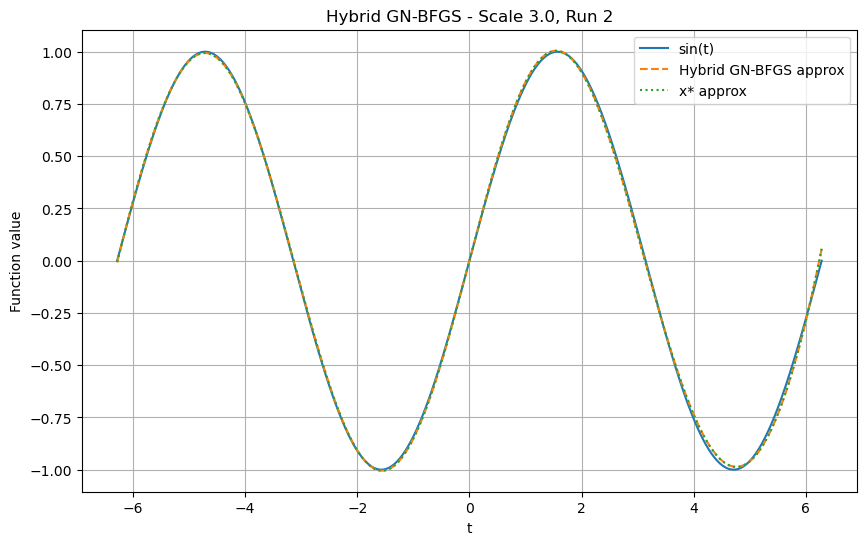


--- Run 3/3 with scale 3.0 ---

Running Standard Newton...
Starting Standard Newton from initial point with norm: 102.7229
Iter 0: f(x) = 8.454156e+02, ||∇f(x)|| = 4.793254e+02
Standard Newton failed to converge. Final gradient norm: 74.697982
Runtime: 0.0272 seconds
Convergence rates: Linear=1, Superlinear=0, Quadratic=0


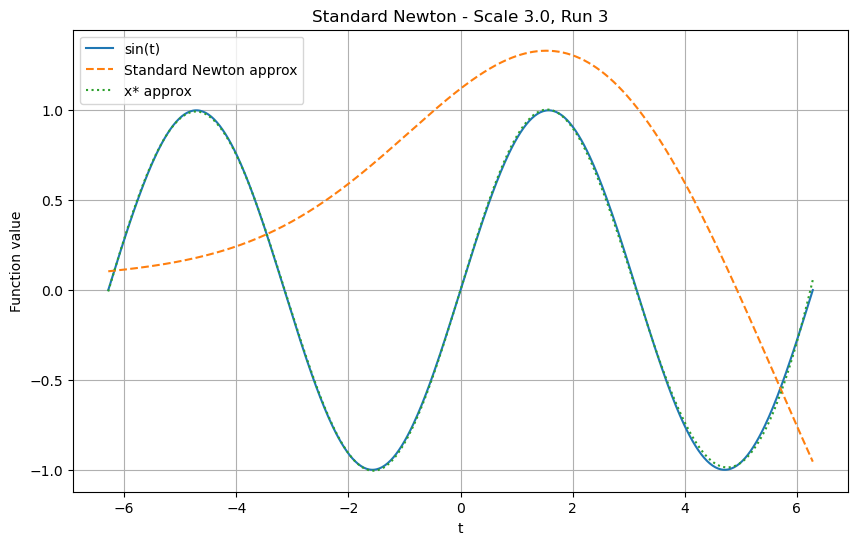


Running Newton with HM...
Starting NM-HM from initial point with norm: 102.7229
Iter 0: f(x) = 8.454156e+02, ||∇f(x)|| = 4.793254e+02
Iter 10: f(x) = 4.481445e+00, ||∇f(x)|| = 1.466021e+01
Iter 20: f(x) = 1.076710e-02, ||∇f(x)|| = 8.785679e-02
Iter 30: f(x) = 9.321458e-03, ||∇f(x)|| = 7.279209e-02
Iter 40: f(x) = 8.619429e-03, ||∇f(x)|| = 3.878242e-02
Iter 50: f(x) = 8.401153e-03, ||∇f(x)|| = 7.625925e-03
Iter 60: f(x) = 8.357660e-03, ||∇f(x)|| = 1.032578e-03
Iter 70: f(x) = 8.338393e-03, ||∇f(x)|| = 1.489973e-03
Iter 80: f(x) = 8.314116e-03, ||∇f(x)|| = 2.782611e-03
Iter 90: f(x) = 8.275302e-03, ||∇f(x)|| = 4.634989e-03
Iter 100: f(x) = 8.203463e-03, ||∇f(x)|| = 7.931597e-03
Iter 110: f(x) = 8.043511e-03, ||∇f(x)|| = 1.437713e-02
Iter 120: f(x) = 7.739462e-03, ||∇f(x)|| = 1.348868e-02
Iter 130: f(x) = 7.605173e-03, ||∇f(x)|| = 1.093325e-03
Iter 140: f(x) = 7.593762e-03, ||∇f(x)|| = 8.136588e-04
Iter 150: f(x) = 7.585451e-03, ||∇f(x)|| = 4.436954e-04
Iter 160: f(x) = 7.578420e-03, ||∇

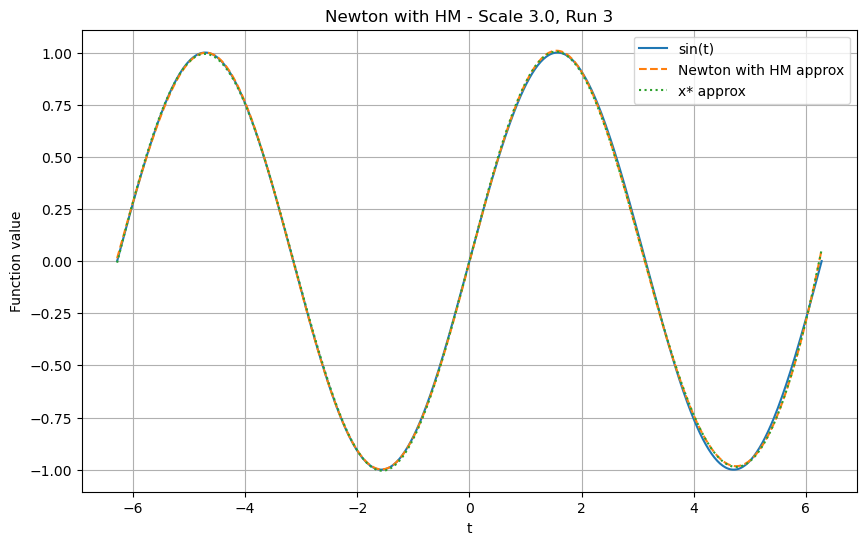


Running Gauss-Newton...
Starting GNM from initial point with norm: 102.7229
Iter 0: f(x) = 8.454156e+02, ||∇f(x)|| = 4.793254e+02
Iter 10: f(x) = 1.869977e+01, ||∇f(x)|| = 1.495579e-01
Iter 20: f(x) = 1.869918e+01, ||∇f(x)|| = 6.486016e-03
Iter 30: f(x) = 1.869918e+01, ||∇f(x)|| = 2.926310e-04
Converged in 34 iterations.
Final f(x) = 1.869918e+01, ||∇f(x)|| = 8.479145e-05
Gauss-Newton converged to a different local minimizer. Distance to x*: 3215.172312
Runtime: 0.0951 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


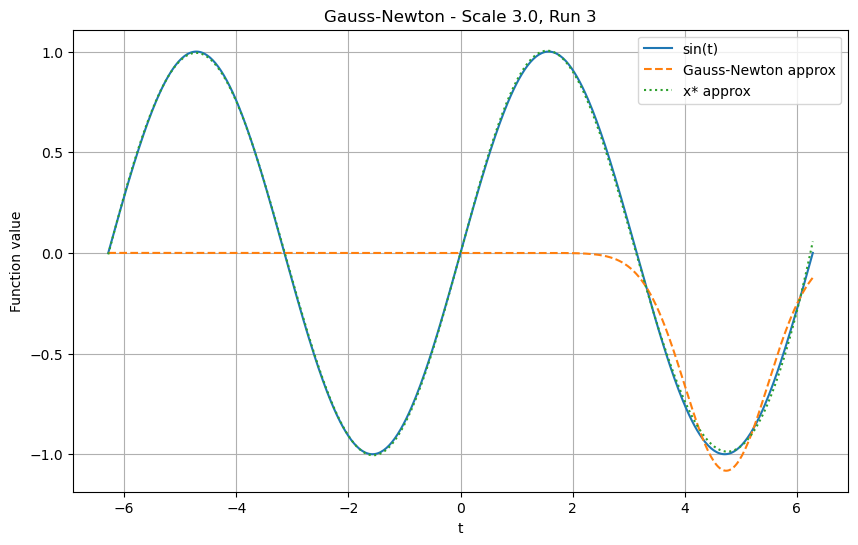


Running Hybrid GN-BFGS...
Starting Hybrid GN-BFGS from initial point with norm: 102.7229
Iter 0: f(x) = 8.454156e+02, ||∇f(x)|| = 4.793254e+02
Iter 10: f(x) = 7.288417e+00, ||∇f(x)|| = 1.590453e+01
Iter 20: f(x) = 3.134832e+00, ||∇f(x)|| = 1.384979e+01
Iter 30: f(x) = 1.990255e-01, ||∇f(x)|| = 3.293928e+00
Iter 40: f(x) = 1.397350e-01, ||∇f(x)|| = 3.246861e+00
Iter 50: f(x) = 3.461381e-02, ||∇f(x)|| = 1.315930e+00
Iter 60: f(x) = 1.367455e-02, ||∇f(x)|| = 1.265937e-02
Iter 70: f(x) = 1.196782e-02, ||∇f(x)|| = 2.237699e-01
Iter 80: f(x) = 8.648571e-03, ||∇f(x)|| = 1.162542e-01
Iter 90: f(x) = 8.317274e-03, ||∇f(x)|| = 2.976491e-03
Converged in 97 iterations.
Final f(x) = 8.314358e-03, ||∇f(x)|| = 9.646985e-05
Hybrid GN-BFGS converged to a different local minimizer. Distance to x*: 9.756154
Runtime: 0.4708 seconds
Convergence rates: Linear=4, Superlinear=0, Quadratic=0


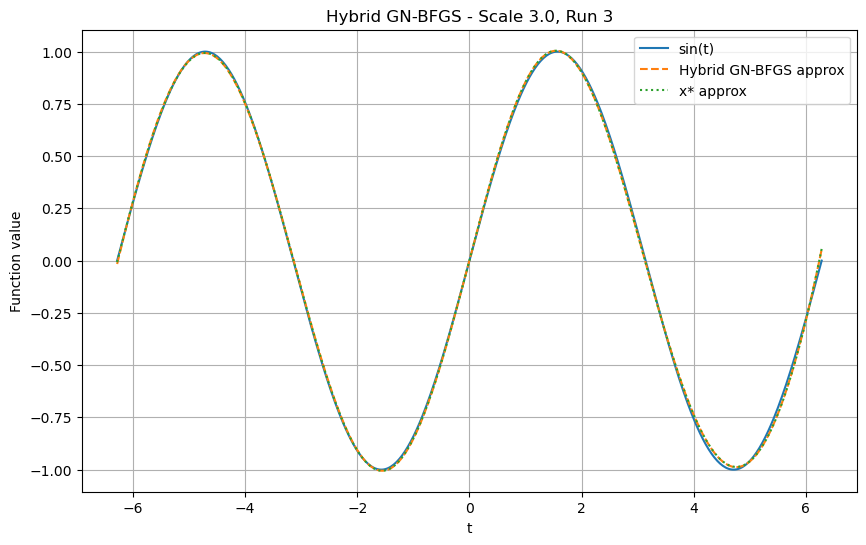


=== ANALYSIS SUMMARY ===

Method               | Success %  | To x*      | To other   | Failed     | Avg Time   | Linear   | Superlin | Quadratic
-----------------------------------------------------------------------------------------------------------------------
Standard Newton      | 0.0        | 0.0        | 0.0        | 100.0      | 0.0541     | 39       | 5        | 0       
Newton with HM       | 100.0      | 0.0        | 100.0      | 0.0        | 0.6266     | 60       | 0        | 0       
Gauss-Newton         | 60.0       | 0.0        | 60.0       | 40.0       | 10.3160    | 58       | 0        | 0       
Hybrid GN-BFGS       | 26.7       | 0.0        | 26.7       | 73.3       | 5.3426     | 60       | 0        | 0       

=== DETAILED ANALYSIS ===


Standard Newton:
  Success rate: 0.0%
  Converged to x*: 0.0%
  Converged to other local minimizer: 0.0%
  Failed to converge: 100.0%
  Average runtime: 0.0541 seconds
Average final gradient norm: 24.258915
  Average iterations:

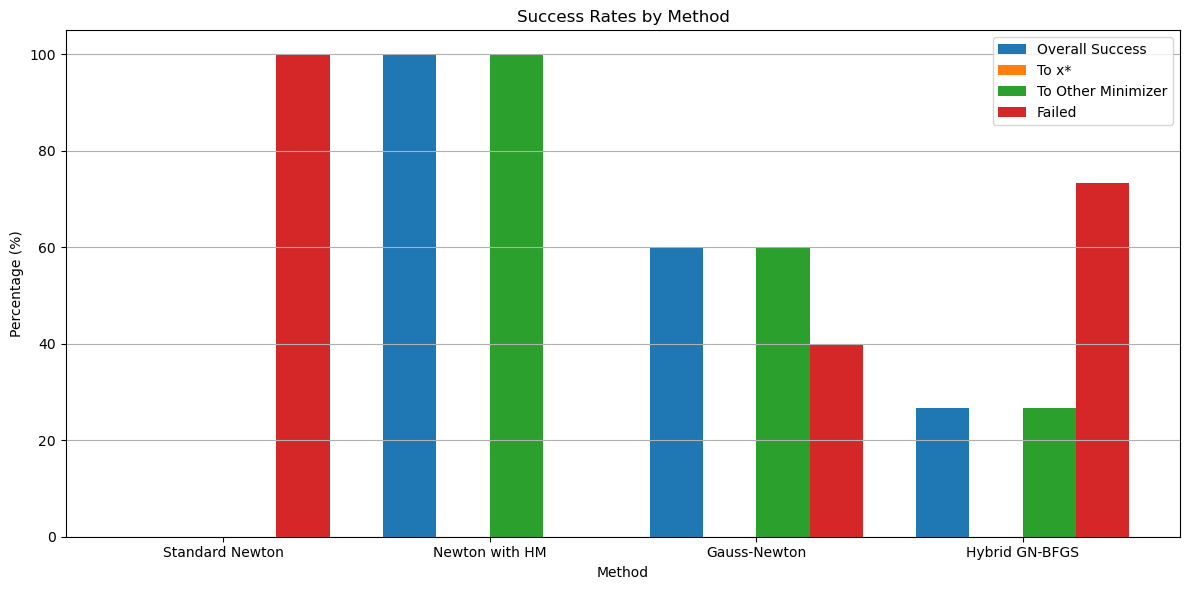

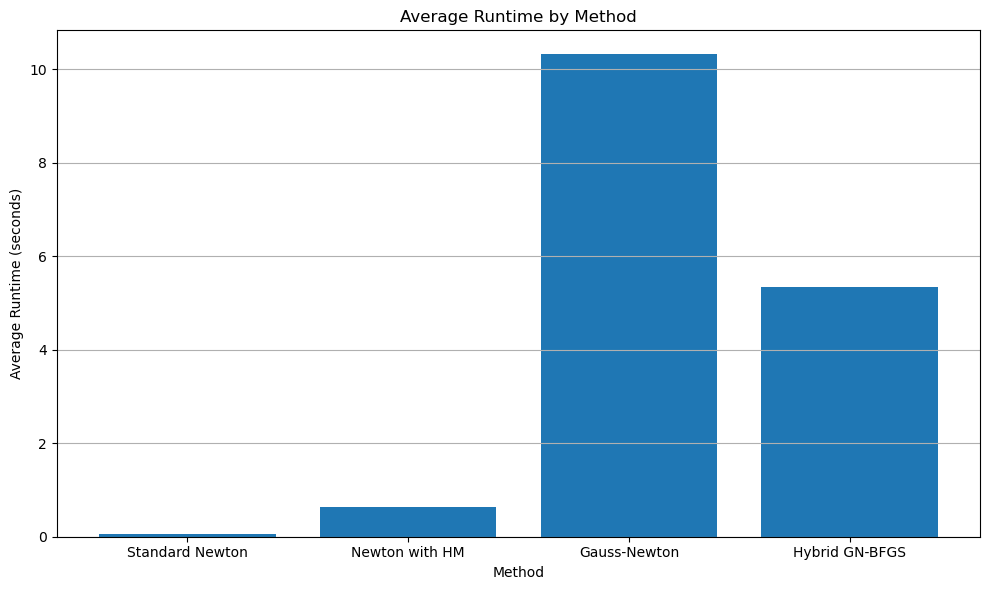

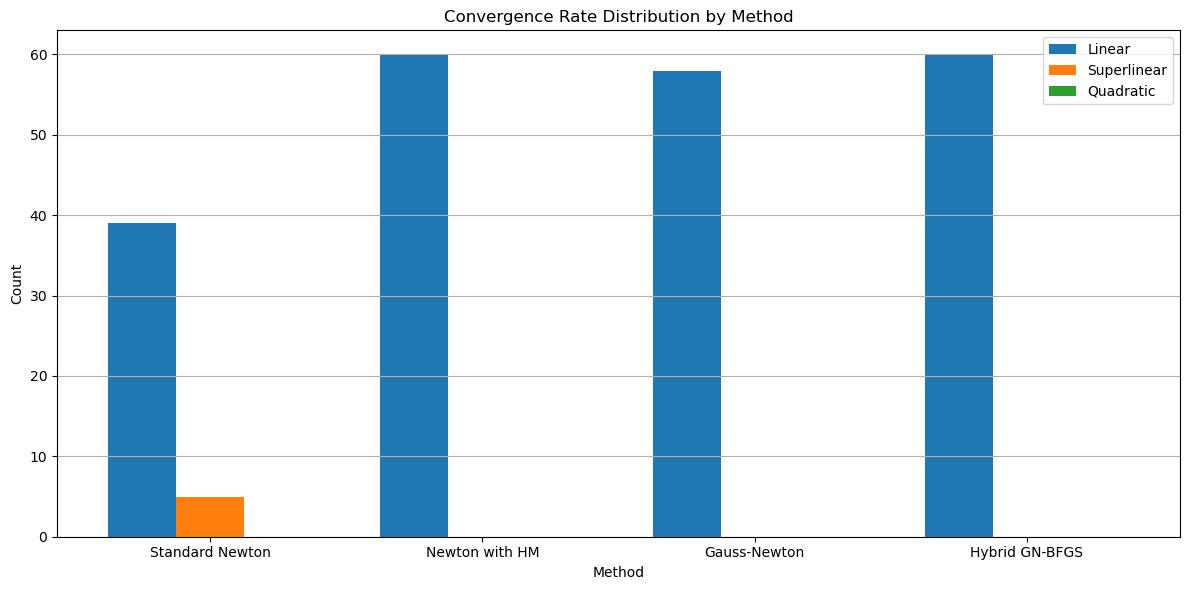

In [39]:
# Initialize a reasonable starting point
np.random.seed(42)
x0_initial = np.zeros(3 * l)
for i in range(l):
    # Set initial alphas around 0.5
    x0_initial[3*i] = 0.5 + 0.1 * np.random.randn()
    # Distribute mu values across the domain
    x0_initial[3*i + 1] = -2*np.pi + i * (4*np.pi)/(l-1)
    # Set positive sigma values
    x0_initial[3*i + 2] = 1.0 + 0.2 * np.random.randn()

print("Finding target solution x_star...")
x_star, _ = hybrid_gn_bfgs(x0_initial, max_iter=1000)
print("Target solution found.")

# Plot the target solution
t_plot = np.linspace(t_min, t_max, 500)
plt.figure(figsize=(10, 6))
plt.plot(t_plot, np.sin(t_plot), label='sin(t)')
plt.plot(t_plot, phi(x_star, t_plot), '--', label='Target approximation')
plt.title("Target Solution x* Approximation")
plt.xlabel("t")
plt.ylabel("Function value")
plt.legend()
plt.grid(True)
plt.show()

print("Target solution parameters:")
for i in range(l):
    print(f"Gaussian {i+1}: alpha={x_star[3*i]:.4f}, mu={x_star[3*i+1]:.4f}, sigma={x_star[3*i+2]:.4f}")

# Define methods to compare
methods = [
    standard_newton_method,
    newton_hessian_modification,
    gauss_newton_method,
    hybrid_gn_bfgs
]

method_names = [
    "Standard Newton",
    "Newton with HM",
    "Gauss-Newton",
    "Hybrid GN-BFGS"
]

# Define scales for initial points - from close to far from x_star
scales = [0.1, 0.5, 1.0, 2.0, 3.0]

# Run comprehensive analysis with 3 runs per scale
print("\nRunning comprehensive analysis...")
results = run_comprehensive_analysis(methods, method_names, x_star, scales, num_runs_per_scale=3, tol=0.0001)

# Print summary
print_analysis_summary(results, method_names)

# Plot comparison charts
plot_comparison_charts(results, method_names)